# topic model

### what is our document?  

I decided that it makes most sense to include the 'lede' in the topic model training, to get more context for the words appearing in the headlines – though I also ran the topic model on just the headlines to see what happens.

A document now corresponds to a test, i.e. a story with all its A/B/C/D headline versions. I concatenate all different headlines for the same story, plus its lede into one document.

Running a topic model on just the headlines might return more stylistic features, whereas running a topic model on the stories should return more semantic clusters/ events/ plots. 

### lemmatize all relevant text

relevant text = several unique headlines + 1 shared lede (I think)

In [5]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatize_text(text):
    doc = nlp(text)
    result = ' '.join([x.lemma_ for x in doc]) 
    return result

# import data

In [6]:
import pandas as pd
pd.set_option('chained_assignment',None) # this allows the pandas apply function to work without problems. Should I double-check with Philipp?

upworthy_df = pd.read_csv('upworthy-archive-exploratory-packages-03.12.2020(1).csv')

upworthy_df.rename(columns={'Unnamed: 0': 'number'}, inplace=True) #rename the first column as "number" 

upworthy_for_topic_model = upworthy_df[['number', 'clickability_test_id', 'headline', 'lede']]

upworthy_for_topic_model

,number,clickability_test_id,headline,lede
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W..."
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W..."
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W..."
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...
...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...


In [7]:
upworthy_for_topic_model['lemmatized_headline'] = upworthy_for_topic_model['headline'].apply(lemmatize_text)
upworthy_for_topic_model['lemmatized_headline']


0        -PRON- be be call ' Walmart 's Worst Nightmare...
1        -PRON- be be call ' Walmart 's Worst Nightmare...
2        -PRON- be be call ' Walmart 's Worst Nightmare...
3               this be what sexism against men sound like
4               this be what sexism against men sound like
                               ...                        
22661    5 reason -PRON- May need to plan a Vacation - ...
22662    the next time -PRON- encounter a small Minded ...
22663    -PRON- have never want to buy a plane ticket M...
22664    3 lady have too much Fun at the Epicenter of a...
22665    -PRON- be be call ' Walmart 's Worst Nightmare...
Name: lemmatized_headline, Length: 22666, dtype: object

In [8]:
upworthy_for_topic_model['lede']

0        <p>When I saw *why* people are calling them "W...
1        <p>When I saw *why* people are calling them "W...
2        <p>When I saw *why* people are calling them "W...
3        <p>DISCLOSURE: I'm a dude. I have cried on mul...
4        <p>DISCLOSURE: I'm a dude. I have cried on mul...
                               ...                        
22661    <p>Travel isn't just a luxury or indulgence an...
22662    <p>Travel isn't just a luxury or indulgence an...
22663    <p>Travel isn't just a luxury or indulgence an...
22664    <p>The Frackettes want to remind you of one im...
22665    <p>When I saw *why* people are calling them "W...
Name: lede, Length: 22666, dtype: object

In [9]:
def lemmatize_lede(lede):
    if type(lede) == str:
        return lemmatize_text(lede)

In [10]:
lemmatize_lede(upworthy_for_topic_model['lede'].iloc[1])
#delete < p > – maybe look up a smart way to delete all HTML formatting, which we clearly still have here.


'< p > when -PRON- see * why * people be call -PRON- " Walmart \'s bad nightmare , " -PRON- find -PRON- wish the nightmare would come true.</p >'

In [11]:
upworthy_for_topic_model['lemmatized_lede'] = upworthy_for_topic_model['lede'].apply(lemmatize_lede)
upworthy_for_topic_model['lemmatized_lede']

0        < p > when -PRON- see * why * people be call -...
1        < p > when -PRON- see * why * people be call -...
2        < p > when -PRON- see * why * people be call -...
3        < p > disclosure : -PRON- be a dude . -PRON- h...
4        < p > disclosure : -PRON- be a dude . -PRON- h...
                               ...                        
22661    < p > Travel be not just a luxury or indulgenc...
22662    < p > Travel be not just a luxury or indulgenc...
22663    < p > Travel be not just a luxury or indulgenc...
22664    < p > the Frackettes want to remind -PRON- of ...
22665    < p > when -PRON- see * why * people be call -...
Name: lemmatized_lede, Length: 22666, dtype: object

In [12]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

def tweet_tokenize(text): 
    tokenized_tweet = tweet_tokenizer.tokenize(text)
    lower = [token.lower() for token in tokenized_tweet]
    return lower

import string

def remove_punct_and_lowercase(text): 
    tokenized_tweet = tweet_tokenizer.tokenize(text)
    lower = [token.lower() for token in tokenized_tweet]
    no_punctuation = [token for token in lower if token not in string.punctuation] 
    return no_punctuation

In [13]:
def preprocess(text):
    if type(text) == str:
        return remove_punct_and_lowercase(text)

In [14]:
upworthy_for_topic_model['preprocessed_headline'] = upworthy_for_topic_model['lemmatized_headline'].apply(preprocess)

upworthy_for_topic_model['preprocessed_headline']

0        [pron, be, be, call, walmart, s, worst, nightm...
1        [pron, be, be, call, walmart, s, worst, nightm...
2        [pron, be, be, call, walmart, s, worst, nightm...
3        [this, be, what, sexism, against, men, sound, ...
4        [this, be, what, sexism, against, men, sound, ...
                               ...                        
22661    [5, reason, pron, may, need, to, plan, a, vaca...
22662    [the, next, time, pron, encounter, a, small, m...
22663    [pron, have, never, want, to, buy, a, plane, t...
22664    [3, lady, have, too, much, fun, at, the, epice...
22665    [pron, be, be, call, walmart, s, worst, nightm...
Name: preprocessed_headline, Length: 22666, dtype: object

In [15]:
upworthy_for_topic_model['preprocessed_lede'] = upworthy_for_topic_model['lemmatized_lede'].apply(preprocess)

upworthy_for_topic_model['preprocessed_lede']

0        [p, when, pron, see, why, people, be, call, pr...
1        [p, when, pron, see, why, people, be, call, pr...
2        [p, when, pron, see, why, people, be, call, pr...
3        [p, disclosure, pron, be, a, dude, pron, have,...
4        [p, disclosure, pron, be, a, dude, pron, have,...
                               ...                        
22661    [p, travel, be, not, just, a, luxury, or, indu...
22662    [p, travel, be, not, just, a, luxury, or, indu...
22663    [p, travel, be, not, just, a, luxury, or, indu...
22664    [p, the, frackettes, want, to, remind, pron, o...
22665    [p, when, pron, see, why, people, be, call, pr...
Name: preprocessed_lede, Length: 22666, dtype: object

In [16]:
upworthy_for_topic_model

,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu..."
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu..."
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu..."
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o..."


# pickle this 

In [17]:
import pickle

upworthy_for_topic_model.to_pickle("./upworthy_preprocessed_for_topic_model_numbered.pkl")

# <code style="background:yellow;color:black"> # if doc == just the headlines, STOP HERE! </code>

# make the documents

get unique headlines for each story id.  
concatenate all unique headlines for the same story and append the story.

In [18]:
def is_list_of_strings(lst):
        return bool(lst) and not isinstance(lst, str) and all(isinstance(elem, str) for elem in lst)
    
    
# remove p's (there's probably more to be removed)
def remove_p(preprocessed_text):
    if preprocessed_text:
        return [token for token in preprocessed_text if not token == 'p']

upworthy_for_topic_model['preprocessed_lede'] = upworthy_for_topic_model['preprocessed_lede'].apply(remove_p)
upworthy_for_topic_model


,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede
0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,..."
1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,..."
2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,..."
3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[disclosure, pron, be, a, dude, pron, have, cr..."
4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[disclosure, pron, be, a, dude, pron, have, cr..."
...,...,...,...,...,...,...,...
22661,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[travel, be, not, just, a, luxury, or, indulge..."
22662,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[travel, be, not, just, a, luxury, or, indulge..."
22663,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[travel, be, not, just, a, luxury, or, indulge..."
22664,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[the, frackettes, want, to, remind, pron, of, ..."


# unlist all

In [19]:
def unlist(preprocessed_text):
    if type(preprocessed_text) == list:
        return ' '.join(preprocessed_text)
        

upworthy_for_topic_model['preprocessed_lede_nolist'] = upworthy_for_topic_model['preprocessed_lede'].apply(unlist)

upworthy_for_topic_model['preprocessed_headline_nolist'] = upworthy_for_topic_model['preprocessed_headline'].apply(unlist)

upworthy_for_topic_model

,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede,preprocessed_lede_nolist,preprocessed_headline_nolist
0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,...",when pron see why people be call pron walmart ...,pron be be call walmart s worst nightmare and ...
1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,...",when pron see why people be call pron walmart ...,pron be be call walmart s worst nightmare and ...
2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[when, pron, see, why, people, be, call, pron,...",when pron see why people be call pron walmart ...,pron be be call walmart s worst nightmare and ...
3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[disclosure, pron, be, a, dude, pron, have, cr...",disclosure pron be a dude pron have cry on mul...,this be what sexism against men sound like
4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[disclosure, pron, be, a, dude, pron, have, cr...",disclosure pron be a dude pron have cry on mul...,this be what sexism against men sound like
...,...,...,...,...,...,...,...,...,...
22661,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[travel, be, not, just, a, luxury, or, indulge...",travel be not just a luxury or indulgence and ...,5 reason pron may need to plan a vacation righ...
22662,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[travel, be, not, just, a, luxury, or, indulge...",travel be not just a luxury or indulgence and ...,the next time pron encounter a small minded bi...
22663,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[travel, be, not, just, a, luxury, or, indulge...",travel be not just a luxury or indulgence and ...,pron have never want to buy a plane ticket mor...
22664,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[the, frackettes, want, to, remind, pron, of, ...",the frackettes want to remind 

In [22]:
all_docs = {} # dictionary which for each clickability_test_id stores the lede + all unique headlines

for id in upworthy_for_topic_model['clickability_test_id'].unique():
    lede = upworthy_for_topic_model[upworthy_for_topic_model['clickability_test_id'] == id]['preprocessed_lede_nolist'].unique()
    lede_list = lede.tolist()
    if is_list_of_strings(lede_list):
        lede_all = ' '.join(lede_list)

    headline = upworthy_for_topic_model[upworthy_for_topic_model['clickability_test_id'] == id]['preprocessed_headline_nolist'].unique()
    headline_list = headline.tolist()
    headline_all = ' '.join(headline_list)
    
    all_docs[id] = lede_all + ' ' + headline_all    # all separated by space
    
all_docs

{'546d88fb84ad38b2ce000024': 'when pron see why people be call pron walmart s bad nightmare pron find pron wish the nightmare would come true pron be be call walmart s worst nightmare and pron really hope pron come true',
 '546d902c26714c6c44000039': 'disclosure pron be a dude pron have cry on multiple occasion this year pron have also yell manly yell at sport event pron be a stay at home parent 1 day a week pron be totally cool with have emotion these be thing than many struggle with because well ... pron will let laci green explain this be what sexism against men sound like',
 '546deb3f26714cd2dd00003a': 'at age 21 yeonmi park be a brand new activist pron ’ also a north korean and pron ’ a survivor listen to pron speak of the horrible thing pron be live through be pretty heartbreaking at 2:00 pron describe the punishment of a friend s mother for a crime that in the u s be just a normal friday night activity at 3:00 when pron talk about what happen to pron mom pron almost lose pron bu

In [23]:
with open('dict_with_lede.pkl', 'wb') as pickle_file: #the 'whit' just makes sure to close the file again
    pickle.dump(all_docs, pickle_file)

# load pickle

In [278]:
with open('lede_and_headline_ldas/dict_with_lede.pkl', 'rb') as pickle_file: 
    all_docs = pickle.load(pickle_file)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [279]:
all_docs_df = pd.DataFrame.from_dict(all_docs, orient='index')
all_docs_df

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
546d88fb84ad38b2ce000024,when pron see why people be call pron walmart ...
546d902c26714c6c44000039,disclosure pron be a dude pron have cry on mul...
546deb3f26714cd2dd00003a,at age 21 yeonmi park be a brand new activist ...
546e009a9ad54ec65b00004b,some decent guy fight for an important cause w...
546dfa4226714c0538000064,in november 2014 singer songerwriter bob geldo...
...,...
546cf7b3fd3617262d000025,pron know pron inclination be to skip over hea...
546cfa32fd361704d100003d,pron all know not em everyone em act like this...
546cfdaf545240e554000035,when cnn s don lemon make the mistake of ask b...
546d082afd36176c99000049,disclosure pron be a dude pron have cry on mul...


# any last preprocsessing? remove stop words etc

In [280]:
spacy_stopwords = nlp.Defaults.stop_words
spacy_stopwords

#add some stopwords. E.g. the lemmatization step turns "he", "she", "it" (all stopwords) into "pron", which is not in stopwords.

additional_stopwords = ['</p>', 'pron', '<br>']
additional_stopwords = set(additional_stopwords)

stopwords = spacy_stopwords | additional_stopwords

def remove_stopwords(text):
    return [token for token in text if not token in stopwords]

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
def list_it(document): #why does it need to be turned into a list again?
    return document.split(" ")

all_docs_df[1] = all_docs_df[0].apply(list_it)
all_docs_df[1]

546d88fb84ad38b2ce000024    [when, pron, see, why, people, be, call, pron,...
546d902c26714c6c44000039    [disclosure, pron, be, a, dude, pron, have, cr...
546deb3f26714cd2dd00003a    [at, age, 21, yeonmi, park, be, a, brand, new,...
546e009a9ad54ec65b00004b    [some, decent, guy, fight, for, an, important,...
546dfa4226714c0538000064    [in, november, 2014, singer, songerwriter, bob...
                                                  ...                        
546cf7b3fd3617262d000025    [pron, know, pron, inclination, be, to, skip, ...
546cfa32fd361704d100003d    [pron, all, know, not, em, everyone, em, act, ...
546cfdaf545240e554000035    [when, cnn, s, don, lemon, make, the, mistake,...
546d082afd36176c99000049    [disclosure, pron, be, a, dude, pron, have, cr...
546c503abadeb51585000003    [sad, but, true, pron, take, the, death, of, s...
Name: 1, Length: 4873, dtype: object

In [52]:
text_data = all_docs_df[1] # save only the documents (texts), each doc is one list 
text_data # list of lists 


546d88fb84ad38b2ce000024    [when, pron, see, why, people, be, call, pron,...
546d902c26714c6c44000039    [disclosure, pron, be, a, dude, pron, have, cr...
546deb3f26714cd2dd00003a    [at, age, 21, yeonmi, park, be, a, brand, new,...
546e009a9ad54ec65b00004b    [some, decent, guy, fight, for, an, important,...
546dfa4226714c0538000064    [in, november, 2014, singer, songerwriter, bob...
                                                  ...                        
546cf7b3fd3617262d000025    [pron, know, pron, inclination, be, to, skip, ...
546cfa32fd361704d100003d    [pron, all, know, not, em, everyone, em, act, ...
546cfdaf545240e554000035    [when, cnn, s, don, lemon, make, the, mistake,...
546d082afd36176c99000049    [disclosure, pron, be, a, dude, pron, have, cr...
546c503abadeb51585000003    [sad, but, true, pron, take, the, death, of, s...
Name: 1, Length: 4873, dtype: object

In [70]:
text_data = text_data.apply(remove_stopwords) #preprocessing can be done at this stage, too 
text_data
#text_data[10]


546d88fb84ad38b2ce000024    [people, walmart, s, bad, nightmare, find, wis...
546d902c26714c6c44000039    [disclosure, dude, cry, multiple, occasion, ye...
546deb3f26714cd2dd00003a    [age, 21, yeonmi, park, brand, new, activist, ...
546e009a9ad54ec65b00004b    [decent, guy, fight, important, cause, learn, ...
546dfa4226714c0538000064    [november, 2014, singer, songerwriter, bob, ge...
                                                  ...                        
546cf7b3fd3617262d000025    [know, inclination, skip, heavy, stuff, online...
546cfa32fd361704d100003d    [know, em, em, act, like, instagram, account, ...
546cfdaf545240e554000035    [cnn, s, don, lemon, mistake, ask, bill, cosby...
546d082afd36176c99000049    [disclosure, dude, cry, multiple, occasion, ye...
546c503abadeb51585000003    [sad, true, death, young, man, people, finally...
Name: 1, Length: 4873, dtype: object

In [71]:
from gensim.models import Phrases
bigram = Phrases(text_data, min_count=10) #only if bigram occurs at least 10 times 

#how many bigrams have we extracted?
bigram.corpus_word_count

203855

In [72]:
trigram = Phrases(bigram[text_data], min_count=10)

trigram.corpus_word_count

195453

In [73]:
print(bigram[text_data[2130]])

['amazing', 'young_woman', 'ainee', 'fatima', 'hijabi', 'feature', 'seventeen', 'magazine', 'ainee', 's', 'poet', 'powerful', 'word', 'secretary', 'clinton', 'handpicke', 'ainee', 'help', 'challenge', 'stereotypes', 'muslim', 'woman', 'u_s', 'pretty', 'great', 'ask', 'woman', 's', 'magazine', 'long', 'feature', 'amazing', 'young_woman', 'hijabi', 'fashion', 'magazine', 'predictably', 'amazing', 'stop', 'smile', 'fashion', 'magazine', 'young_woman', 'fashion', 'magazine', 'grow', 'maybe', 'd', 'read', 'young_woman', 'u_s', 'young_woman', 'young_woman']


In [74]:
for idx in range(len(text_data)):
    for token in trigram[text_data[idx]]: #or trigram?
        if '_' in token:
            # Token is a bigram, add to document.
            text_data[idx].append(token)

In [75]:
import gensim
from gensim import corpora 

dictionary = corpora.Dictionary(text_data) # create term <-> id dictionary
print(len(dictionary)) #why is the dictionary smaller than the bigram count? because it has a threshold? 

14055


In [76]:
corpus = [dictionary.doc2bow(text) for text in text_data] # create a document-term matrix (bag of words representation)

In [77]:
dictionary[1]

'come'

In [78]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [88]:
for n in topic_n: 
    variable = 'upworthy_bigrams_' + str(n)
    print(variable)

upworthy_bigrams_5
upworthy_bigrams_10
upworthy_bigrams_15
upworthy_bigrams_20
upworthy_bigrams_25
upworthy_bigrams_30


/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
variable_name + 'display'

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'upworthy_bigrams_30display'

In [116]:
with open('all_docs_corpus.pkl', 'wb') as pickle_file: 
    pickle.dump(corpus, pickle_file)

with open('all_docs_dictionary.pkl', 'wb') as pickle_file: 
    pickle.dump(dictionary, pickle_file)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
import pyLDAvis.gensim # visualize topic models with pyLDAvis
topic_n = [5, 10, 15, 20, 25, 30]

for n in topic_n: 
    variable_name = 'upworthy_bigrams_' + str(n)
    variable = gensim.models.ldamodel.LdaModel(corpus, num_topics= n, id2word = dictionary, passes=20)

    with open(variable_name + '.pkl', 'wb') as pickle_file: 
        pickle.dump(variable, pickle_file)
        
    variable_lda_display = variable_name + '_display'    
    lda_display = pyLDAvis.gensim.prepare(variable, corpus, dictionary, sort_topics=False)

# save your favourite topic model as html to share with friends 

    pyLDAvis.save_html(lda_display, variable_lda_display + '.html')

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-04-07 11:20:27,696 : INFO : using symmetric alpha at 0.2
2021-04-07 11:20:27,699 : INFO : using symmetric eta at 0.2
2021-04-07 11:20:27,703 : INFO : using serial LDA version on this node
2021-04-07 11:20:27,713 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 4873 documents, updating model once every 2000 documents, evaluating perplexity every 4873 documents, iterating 50x with a convergence threshold of 0.001000
2021-04-07 11:20:27,720 : INFO : PROGRESS: pass 0, at document #2000/4873
2021-04-07 11:20:29,223 : INFO : merging changes from 2000 documents into a model of 

2021-04-07 11:20:34,843 : INFO : topic #4 (0.200): 0.013*"people" + 0.011*"woman" + 0.009*"s" + 0.009*"think" + 0.007*"thing" + 0.007*"way" + 0.007*"like" + 0.006*"good" + 0.006*"..." + 0.006*"know"
2021-04-07 11:20:34,844 : INFO : topic diff=0.482549, rho=0.474766
2021-04-07 11:20:34,846 : INFO : PROGRESS: pass 2, at document #2000/4873
2021-04-07 11:20:35,688 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:20:35,692 : INFO : topic #0 (0.200): 0.012*"like" + 0.008*"people" + 0.007*"think" + 0.007*"year_old" + 0.006*"know" + 0.006*"thing" + 0.005*"way" + 0.005*"time" + 0.005*"year" + 0.005*"</span>"
2021-04-07 11:20:35,694 : INFO : topic #1 (0.200): 0.016*"’" + 0.014*"s" + 0.013*"’_s" + 0.009*"know" + 0.008*"people" + 0.008*"em" + 0.008*"kid" + 0.007*"u_s" + 0.006*"time" + 0.006*"thing"
2021-04-07 11:20:35,695 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.010*"look_like" + 0.008*"look" + 0.007*"way" + 0.007*"life" + 0.006*"woman"

2021-04-07 11:20:40,924 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:20:40,928 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"people" + 0.007*"year_old" + 0.007*"know" + 0.007*"</span>" + 0.007*"think" + 0.006*"thing" + 0.005*"feel_like" + 0.005*"way" + 0.005*"span"
2021-04-07 11:20:40,929 : INFO : topic #1 (0.200): 0.017*"’" + 0.015*"s" + 0.014*"’_s" + 0.009*"know" + 0.008*"people" + 0.008*"kid" + 0.007*"u_s" + 0.007*"em" + 0.006*"thing" + 0.006*"time"
2021-04-07 11:20:40,930 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.010*"look_like" + 0.008*"look" + 0.007*"woman" + 0.007*"way" + 0.007*"life" + 0.007*"thing" + 0.006*"think" + 0.006*"kid"
2021-04-07 11:20:40,931 : INFO : topic #3 (0.200): 0.009*"video" + 0.009*"s" + 0.008*"woman" + 0.008*"jon_stewart" + 0.007*"_blank" + 0.007*"world" + 0.006*"think" + 0.005*"people" + 0.005*"thing" + 0.005*"video_game"
2021-04-07 11:20:40,933 : INFO : topic #4 (0.200): 0.013*"people" + 0.

2021-04-07 11:20:45,787 : INFO : topic #1 (0.200): 0.018*"’" + 0.015*"’_s" + 0.015*"s" + 0.009*"know" + 0.008*"kid" + 0.008*"people" + 0.007*"u_s" + 0.007*"em" + 0.006*"thing" + 0.006*"time"
2021-04-07 11:20:45,788 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.010*"look_like" + 0.008*"look" + 0.007*"woman" + 0.007*"life" + 0.007*"way" + 0.007*"thing" + 0.006*"kid" + 0.006*"think"
2021-04-07 11:20:45,790 : INFO : topic #3 (0.200): 0.010*"video" + 0.008*"s" + 0.008*"woman" + 0.008*"jon_stewart" + 0.008*"_blank" + 0.006*"world" + 0.006*"think" + 0.005*"people" + 0.005*"video_game" + 0.004*"music_video"
2021-04-07 11:20:45,791 : INFO : topic #4 (0.200): 0.013*"people" + 0.011*"woman" + 0.009*"think" + 0.008*"s" + 0.007*"thing" + 0.007*"like" + 0.007*"way" + 0.006*"good" + 0.006*"change" + 0.006*"know"
2021-04-07 11:20:45,792 : INFO : topic diff=0.184899, rho=0.325533
2021-04-07 11:20:45,793 : INFO : PROGRESS: pass 6, at document #4000/4873
2021-04-07 11:20:46,597 : INFO : me

2021-04-07 11:20:50,510 : INFO : topic #3 (0.200): 0.010*"video" + 0.008*"woman" + 0.008*"_blank" + 0.008*"s" + 0.008*"jon_stewart" + 0.006*"world" + 0.005*"think" + 0.005*"video_game" + 0.005*"music_video" + 0.005*"people"
2021-04-07 11:20:50,511 : INFO : topic #4 (0.200): 0.013*"people" + 0.010*"woman" + 0.009*"think" + 0.008*"s" + 0.007*"thing" + 0.007*"like" + 0.007*"way" + 0.006*"good" + 0.006*"change" + 0.006*"..."
2021-04-07 11:20:50,512 : INFO : topic diff=0.157621, rho=0.295701
2021-04-07 11:20:50,515 : INFO : PROGRESS: pass 8, at document #4000/4873
2021-04-07 11:20:51,284 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:20:51,287 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"people" + 0.007*"year_old" + 0.007*"know" + 0.006*"feel_like" + 0.006*"think" + 0.006*"thing" + 0.006*"</span>" + 0.005*"s" + 0.005*"way"
2021-04-07 11:20:51,288 : INFO : topic #1 (0.200): 0.019*"’" + 0.016*"’_s" + 0.014*"s" + 0.009*"know" + 0.008*"people" + 0.

2021-04-07 11:20:56,355 : INFO : topic diff=0.140215, rho=0.272808
2021-04-07 11:20:56,361 : INFO : PROGRESS: pass 10, at document #4000/4873
2021-04-07 11:20:57,341 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:20:57,345 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"people" + 0.007*"year_old" + 0.007*"know" + 0.007*"feel_like" + 0.006*"thing" + 0.006*"think" + 0.006*"</span>" + 0.005*"<span>_</span>" + 0.005*"way"
2021-04-07 11:20:57,346 : INFO : topic #1 (0.200): 0.019*"’" + 0.016*"’_s" + 0.014*"s" + 0.009*"know" + 0.008*"people" + 0.007*"kid" + 0.007*"u_s" + 0.007*"em" + 0.006*"time" + 0.006*"thing"
2021-04-07 11:20:57,347 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.009*"look_like" + 0.008*"woman" + 0.007*"look" + 0.007*"life" + 0.007*"thing" + 0.007*"way" + 0.006*"think" + 0.006*"kid"
2021-04-07 11:20:57,349 : INFO : topic #3 (0.200): 0.010*"video" + 0.009*"woman" + 0.008*"_blank" + 0.008*"s" + 0.007*"jon_stewart" + 0.

2021-04-07 11:21:02,801 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"people" + 0.007*"year_old" + 0.007*"know" + 0.007*"feel_like" + 0.006*"thing" + 0.006*"think" + 0.006*"</span>" + 0.006*"<span>_</span>" + 0.005*"s"
2021-04-07 11:21:02,803 : INFO : topic #1 (0.200): 0.019*"’" + 0.016*"’_s" + 0.014*"s" + 0.009*"know" + 0.008*"people" + 0.007*"kid" + 0.007*"u_s" + 0.007*"em" + 0.006*"time" + 0.006*"thing"
2021-04-07 11:21:02,804 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.009*"look_like" + 0.008*"woman" + 0.007*"look" + 0.007*"life" + 0.007*"thing" + 0.007*"way" + 0.007*"kid" + 0.006*"think"
2021-04-07 11:21:02,807 : INFO : topic #3 (0.200): 0.010*"video" + 0.009*"woman" + 0.008*"_blank" + 0.008*"s" + 0.007*"jon_stewart" + 0.006*"think" + 0.005*"music_video" + 0.005*"world" + 0.005*"people" + 0.004*"like"
2021-04-07 11:21:02,813 : INFO : topic #4 (0.200): 0.012*"people" + 0.010*"woman" + 0.009*"think" + 0.008*"s" + 0.007*"like" + 0.007*"thing" + 0.006*"good" + 0.00

2021-04-07 11:21:07,346 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.009*"look_like" + 0.009*"woman" + 0.007*"life" + 0.007*"look" + 0.007*"thing" + 0.007*"kid" + 0.007*"way" + 0.007*"think"
2021-04-07 11:21:07,347 : INFO : topic #3 (0.200): 0.010*"video" + 0.008*"woman" + 0.008*"_blank" + 0.008*"s" + 0.007*"jon_stewart" + 0.006*"music_video" + 0.006*"think" + 0.005*"world" + 0.005*"people" + 0.004*"like"
2021-04-07 11:21:07,348 : INFO : topic #4 (0.200): 0.012*"people" + 0.009*"woman" + 0.009*"think" + 0.008*"s" + 0.007*"like" + 0.007*"thing" + 0.006*"way" + 0.006*"good" + 0.006*"..." + 0.006*"change"
2021-04-07 11:21:07,349 : INFO : topic diff=0.119486, rho=0.239481
2021-04-07 11:21:07,825 : INFO : -7.699 per-word bound, 207.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:21:07,825 : INFO : PROGRESS: pass 14, at document #4873/4873
2021-04-07 11:21:08,101 : INFO : merging changes from 873 documents into a model of 4873 

2021-04-07 11:21:12,104 : INFO : topic #4 (0.200): 0.012*"people" + 0.009*"woman" + 0.009*"think" + 0.008*"s" + 0.007*"like" + 0.007*"thing" + 0.006*"way" + 0.006*"good" + 0.006*"..." + 0.006*"change"
2021-04-07 11:21:12,107 : INFO : topic diff=0.111433, rho=0.226825
2021-04-07 11:21:12,518 : INFO : -7.691 per-word bound, 206.7 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:21:12,519 : INFO : PROGRESS: pass 16, at document #4873/4873
2021-04-07 11:21:12,788 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:21:12,793 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"people" + 0.008*"feel_like" + 0.008*"year_old" + 0.008*"know" + 0.006*"thing" + 0.006*"s" + 0.006*"way" + 0.006*"</span>" + 0.006*"think"
2021-04-07 11:21:12,794 : INFO : topic #1 (0.200): 0.019*"’" + 0.016*"’_s" + 0.015*"s" + 0.009*"know" + 0.008*"people" + 0.008*"kid" + 0.007*"u_s" + 0.006*"em" + 0.006*"time" + 0.006*"thing"
2021-04-07 11

2021-04-07 11:21:17,921 : INFO : -7.685 per-word bound, 205.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:21:17,923 : INFO : PROGRESS: pass 18, at document #4873/4873
2021-04-07 11:21:18,244 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:21:18,248 : INFO : topic #0 (0.200): 0.011*"like" + 0.008*"feel_like" + 0.008*"people" + 0.008*"year_old" + 0.008*"know" + 0.006*"thing" + 0.006*"s" + 0.006*"</span>" + 0.006*"way" + 0.006*"think"
2021-04-07 11:21:18,250 : INFO : topic #1 (0.200): 0.019*"’" + 0.016*"’_s" + 0.015*"s" + 0.009*"know" + 0.008*"people" + 0.007*"kid" + 0.007*"u_s" + 0.006*"em" + 0.006*"time" + 0.006*"thing"
2021-04-07 11:21:18,252 : INFO : topic #2 (0.200): 0.013*"people" + 0.011*"like" + 0.009*"woman" + 0.009*"look_like" + 0.008*"thing" + 0.007*"life" + 0.007*"look" + 0.007*"know" + 0.007*"kid" + 0.007*"way"
2021-04-07 11:21:18,254 : INFO : topic #3 (0.200): 0.012*"video" + 0.009*"_

2021-04-07 11:21:33,168 : INFO : topic diff=0.538773, rho=0.707107
2021-04-07 11:21:33,847 : INFO : -8.992 per-word bound, 509.3 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:21:33,848 : INFO : PROGRESS: pass 0, at document #4873/4873
2021-04-07 11:21:34,391 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:21:34,401 : INFO : topic #6 (0.100): 0.020*"jon_stewart" + 0.012*"mental_illness" + 0.009*"16_year" + 0.008*"s" + 0.008*"stewart" + 0.008*"jon" + 0.008*"people" + 0.008*"year" + 0.007*"know" + 0.006*"think"
2021-04-07 11:21:34,403 : INFO : topic #7 (0.100): 0.015*"woman" + 0.012*"young_woman" + 0.011*"young" + 0.008*"video" + 0.008*"like" + 0.007*"girl" + 0.006*"people" + 0.006*"know" + 0.006*"world_leader" + 0.005*"thing"
2021-04-07 11:21:34,404 : INFO : topic #3 (0.100): 0.014*"s" + 0.013*"people" + 0.011*"gay" + 0.009*"mom" + 0.009*"know" + 0.008*"like" + 0.007*"u_s" + 0.007*"ask" + 0.007*"wan

2021-04-07 11:21:41,744 : INFO : PROGRESS: pass 2, at document #4873/4873
2021-04-07 11:21:42,202 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:21:42,214 : INFO : topic #4 (0.100): 0.021*"woman" + 0.009*"video" + 0.008*"global_warming" + 0.008*"people" + 0.008*"like" + 0.008*"strong" + 0.007*"think" + 0.006*"know" + 0.006*"science" + 0.006*"tell"
2021-04-07 11:21:42,216 : INFO : topic #2 (0.100): 0.019*"people" + 0.011*"think" + 0.010*"time" + 0.009*"s" + 0.009*"talk" + 0.008*"way" + 0.008*"know" + 0.007*"..." + 0.007*"’" + 0.007*"good"
2021-04-07 11:21:42,218 : INFO : topic #8 (0.100): 0.017*"ice_bucket" + 0.015*"’_s" + 0.011*"minimum_wage" + 0.011*"’" + 0.010*"s" + 0.008*"dog" + 0.007*"map" + 0.007*"bucket" + 0.007*"cool" + 0.007*"woman"
2021-04-07 11:21:42,219 : INFO : topic #7 (0.100): 0.018*"woman" + 0.015*"young" + 0.015*"girl" + 0.012*"young_woman" + 0.008*"united_states" + 0.008*"young_girl" + 0.007*"4_year" + 0.006*"blow_away" + 0.006

2021-04-07 11:21:49,925 : INFO : topic #5 (0.100): 0.017*"people" + 0.013*"like" + 0.012*"feel_like" + 0.012*"way" + 0.012*"change" + 0.011*"thing" + 0.010*"climate_change" + 0.008*"feel" + 0.008*"world" + 0.007*"think"
2021-04-07 11:21:49,928 : INFO : topic #1 (0.100): 0.022*"em" + 0.016*"like" + 0.014*"em_em" + 0.011*"look_like" + 0.010*"people" + 0.010*"look" + 0.009*"thing" + 0.009*"know" + 0.007*"little" + 0.007*"little_girl"
2021-04-07 11:21:49,931 : INFO : topic #7 (0.100): 0.019*"girl" + 0.019*"woman" + 0.016*"young" + 0.012*"young_woman" + 0.009*"young_girl" + 0.009*"united_states" + 0.007*"million_people" + 0.007*"4_year" + 0.007*"man" + 0.006*"old_girl"
2021-04-07 11:21:49,933 : INFO : topic #3 (0.100): 0.018*"gay" + 0.015*"s" + 0.015*"u_s" + 0.013*"people" + 0.011*"mom" + 0.009*"sexual_assault" + 0.009*"_blank" + 0.007*"think" + 0.007*"ask" + 0.006*"parent"
2021-04-07 11:21:49,936 : INFO : topic #9 (0.100): 0.015*"s" + 0.010*"life" + 0.008*"story" + 0.008*"video_game" + 0.0

2021-04-07 11:21:55,444 : INFO : topic #6 (0.100): 0.021*"jon_stewart" + 0.016*"year_ago" + 0.016*"year" + 0.013*"mental_illness" + 0.011*"16_year" + 0.009*"50_year" + 0.009*"stewart" + 0.009*"jon" + 0.008*"s" + 0.008*"ago"
2021-04-07 11:21:55,447 : INFO : topic #0 (0.100): 0.025*"kid" + 0.020*"’_s" + 0.019*"’" + 0.013*"s" + 0.011*"like" + 0.010*"year_old" + 0.010*"know" + 0.009*"thing" + 0.008*"</span>" + 0.007*"year"
2021-04-07 11:21:55,448 : INFO : topic #2 (0.100): 0.019*"people" + 0.011*"think" + 0.010*"time" + 0.009*"way" + 0.008*"..." + 0.008*"know" + 0.008*"s" + 0.008*"talk" + 0.007*"good" + 0.007*"’"
2021-04-07 11:21:55,450 : INFO : topic #5 (0.100): 0.018*"people" + 0.012*"like" + 0.012*"feel_like" + 0.012*"way" + 0.012*"change" + 0.011*"thing" + 0.010*"climate_change" + 0.008*"world" + 0.008*"feel" + 0.008*"think"
2021-04-07 11:21:55,452 : INFO : topic #9 (0.100): 0.014*"s" + 0.011*"life" + 0.008*"story" + 0.008*"year" + 0.008*"john_oliver" + 0.008*"video_game" + 0.007*"hear

2021-04-07 11:22:00,945 : INFO : topic #6 (0.100): 0.022*"jon_stewart" + 0.016*"year_ago" + 0.016*"year" + 0.013*"mental_illness" + 0.011*"16_year" + 0.010*"50_year" + 0.009*"stewart" + 0.009*"jon" + 0.008*"ago" + 0.008*"s"
2021-04-07 11:22:00,947 : INFO : topic #3 (0.100): 0.019*"gay" + 0.016*"u_s" + 0.015*"s" + 0.013*"people" + 0.010*"mom" + 0.010*"_blank" + 0.009*"sexual_assault" + 0.008*"ask" + 0.008*"think" + 0.007*"sexual"
2021-04-07 11:22:00,949 : INFO : topic #7 (0.100): 0.023*"girl" + 0.019*"woman" + 0.016*"young" + 0.012*"young_woman" + 0.011*"united_states" + 0.009*"million_people" + 0.009*"young_girl" + 0.008*"old_girl" + 0.007*"old" + 0.007*"year"
2021-04-07 11:22:00,950 : INFO : topic #1 (0.100): 0.023*"em" + 0.015*"like" + 0.014*"em_em" + 0.012*"look_like" + 0.010*"look" + 0.010*"people" + 0.008*"thing" + 0.008*"know" + 0.007*"little_girl" + 0.007*"little"
2021-04-07 11:22:00,951 : INFO : topic diff=0.099375, rho=0.295701
2021-04-07 11:22:00,954 : INFO : PROGRESS: pass 9

2021-04-07 11:22:09,064 : INFO : topic #6 (0.100): 0.022*"jon_stewart" + 0.016*"year_ago" + 0.016*"year" + 0.013*"mental_illness" + 0.011*"16_year" + 0.010*"50_year" + 0.009*"stewart" + 0.009*"jon" + 0.008*"ago" + 0.008*"s"
2021-04-07 11:22:09,066 : INFO : topic #8 (0.100): 0.015*"ice_bucket" + 0.015*"minimum_wage" + 0.014*"’_s" + 0.010*"’" + 0.009*"dog" + 0.009*"s" + 0.009*"wage" + 0.008*"minimum" + 0.008*"map" + 0.007*"cool"
2021-04-07 11:22:09,068 : INFO : topic #5 (0.100): 0.019*"people" + 0.012*"like" + 0.012*"feel_like" + 0.012*"change" + 0.012*"thing" + 0.011*"way" + 0.010*"climate_change" + 0.008*"world" + 0.008*"feel" + 0.008*"think"
2021-04-07 11:22:09,070 : INFO : topic #9 (0.100): 0.013*"s" + 0.011*"life" + 0.008*"story" + 0.008*"year" + 0.008*"john_oliver" + 0.008*"video_game" + 0.007*"3_minute" + 0.007*"hear" + 0.007*"think" + 0.006*"news"
2021-04-07 11:22:09,072 : INFO : topic diff=0.085630, rho=0.272808
2021-04-07 11:22:09,073 : INFO : PROGRESS: pass 11, at document #20

2021-04-07 11:22:13,987 : INFO : topic #1 (0.100): 0.024*"em" + 0.015*"like" + 0.014*"em_em" + 0.012*"look_like" + 0.011*"look" + 0.010*"people" + 0.008*"thing" + 0.008*"know" + 0.007*"little_girl" + 0.007*"..."
2021-04-07 11:22:13,992 : INFO : topic #2 (0.100): 0.018*"people" + 0.011*"think" + 0.010*"time" + 0.009*"way" + 0.008*"..." + 0.008*"know" + 0.008*"good" + 0.007*"s" + 0.007*"talk" + 0.007*"reason"
2021-04-07 11:22:13,996 : INFO : topic #4 (0.100): 0.024*"woman" + 0.011*"strong" + 0.008*"global_warming" + 0.008*"like" + 0.007*"video" + 0.007*"science" + 0.007*"know" + 0.007*"think" + 0.006*"female_character" + 0.006*"female"
2021-04-07 11:22:13,997 : INFO : topic #3 (0.100): 0.019*"gay" + 0.016*"u_s" + 0.016*"s" + 0.013*"people" + 0.010*"mom" + 0.010*"_blank" + 0.009*"ask" + 0.009*"sexual_assault" + 0.008*"think" + 0.007*"woman"
2021-04-07 11:22:13,998 : INFO : topic diff=0.076651, rho=0.254522
2021-04-07 11:22:13,999 : INFO : PROGRESS: pass 13, at document #2000/4873
2021-04-

2021-04-07 11:22:18,751 : INFO : topic #8 (0.100): 0.015*"minimum_wage" + 0.015*"ice_bucket" + 0.013*"’_s" + 0.010*"’" + 0.010*"dog" + 0.009*"wage" + 0.009*"s" + 0.008*"minimum" + 0.008*"map" + 0.007*"cool"
2021-04-07 11:22:18,758 : INFO : topic #1 (0.100): 0.024*"em" + 0.015*"like" + 0.014*"em_em" + 0.012*"look_like" + 0.011*"look" + 0.010*"people" + 0.008*"thing" + 0.008*"know" + 0.007*"little_girl" + 0.007*"..."
2021-04-07 11:22:18,763 : INFO : topic #4 (0.100): 0.024*"woman" + 0.011*"strong" + 0.008*"global_warming" + 0.008*"like" + 0.007*"video" + 0.007*"science" + 0.007*"know" + 0.007*"think" + 0.006*"female_character" + 0.006*"female"
2021-04-07 11:22:18,768 : INFO : topic diff=0.069886, rho=0.239481
2021-04-07 11:22:18,771 : INFO : PROGRESS: pass 15, at document #2000/4873
2021-04-07 11:22:19,462 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:22:19,471 : INFO : topic #4 (0.100): 0.025*"woman" + 0.010*"strong" + 0.008*"global_warming" +

2021-04-07 11:22:23,625 : INFO : topic #4 (0.100): 0.024*"woman" + 0.011*"strong" + 0.008*"global_warming" + 0.008*"like" + 0.007*"video" + 0.007*"science" + 0.007*"know" + 0.007*"think" + 0.006*"female_character" + 0.006*"female"
2021-04-07 11:22:23,627 : INFO : topic #3 (0.100): 0.019*"gay" + 0.016*"u_s" + 0.016*"s" + 0.012*"people" + 0.010*"_blank" + 0.010*"mom" + 0.009*"ask" + 0.008*"sexual_assault" + 0.008*"think" + 0.007*"woman"
2021-04-07 11:22:23,631 : INFO : topic #6 (0.100): 0.021*"jon_stewart" + 0.017*"year_ago" + 0.016*"year" + 0.013*"mental_illness" + 0.011*"16_year" + 0.010*"50_year" + 0.009*"stewart" + 0.009*"jon" + 0.008*"ago" + 0.008*"2_minutes"
2021-04-07 11:22:23,632 : INFO : topic diff=0.064810, rho=0.226825
2021-04-07 11:22:23,633 : INFO : PROGRESS: pass 17, at document #2000/4873
2021-04-07 11:22:24,384 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:22:24,391 : INFO : topic #0 (0.100): 0.026*"kid" + 0.021*"’_s" + 0.021*"’

2021-04-07 11:22:28,897 : INFO : topic #7 (0.100): 0.025*"girl" + 0.019*"woman" + 0.015*"young" + 0.012*"united_states" + 0.011*"young_woman" + 0.011*"million_people" + 0.010*"old" + 0.010*"year" + 0.009*"young_girl" + 0.008*"old_girl"
2021-04-07 11:22:28,898 : INFO : topic #6 (0.100): 0.021*"jon_stewart" + 0.017*"year_ago" + 0.016*"year" + 0.013*"mental_illness" + 0.011*"16_year" + 0.010*"50_year" + 0.009*"stewart" + 0.009*"jon" + 0.008*"ago" + 0.008*"2_minutes"
2021-04-07 11:22:28,902 : INFO : topic #3 (0.100): 0.019*"gay" + 0.016*"u_s" + 0.016*"s" + 0.012*"people" + 0.010*"_blank" + 0.010*"mom" + 0.009*"ask" + 0.008*"sexual_assault" + 0.008*"think" + 0.007*"woman"
2021-04-07 11:22:28,905 : INFO : topic diff=0.060692, rho=0.215985
2021-04-07 11:22:28,906 : INFO : PROGRESS: pass 19, at document #2000/4873
2021-04-07 11:22:29,539 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:22:29,545 : INFO : topic #1 (0.100): 0.025*"em" + 0.015*"like" + 0.0

2021-04-07 11:22:37,707 : INFO : topic #13 (0.067): 0.017*"people" + 0.013*"life" + 0.011*"video" + 0.010*"way" + 0.009*"like" + 0.008*"video_game" + 0.008*"talk" + 0.008*"music_video" + 0.008*"s" + 0.006*"hear"
2021-04-07 11:22:37,708 : INFO : topic #7 (0.067): 0.016*"year" + 0.012*"17_year" + 0.011*"old" + 0.010*"old_girl" + 0.009*"way_possible" + 0.009*"s" + 0.008*"girl" + 0.008*"talk" + 0.008*"fact_check" + 0.007*"people"
2021-04-07 11:22:37,710 : INFO : topic #1 (0.067): 0.021*"jon_stewart" + 0.015*"s" + 0.010*"u_s" + 0.009*"people" + 0.009*"stewart" + 0.008*"jon" + 0.008*"think" + 0.008*"’" + 0.007*"little_bit" + 0.007*"watch"
2021-04-07 11:22:37,712 : INFO : topic #14 (0.067): 0.011*"people" + 0.011*"background_color" + 0.010*"year_old" + 0.009*"people_color" + 0.009*"football_player" + 0.008*"woman" + 0.008*"color" + 0.007*"s" + 0.007*"question" + 0.007*"5_minute"
2021-04-07 11:22:37,713 : INFO : topic #4 (0.067): 0.015*"people" + 0.015*"em" + 0.012*"video" + 0.011*"time" + 0.0

2021-04-07 11:22:44,922 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:22:44,932 : INFO : topic #4 (0.067): 0.026*"em" + 0.021*"em_em" + 0.017*"people" + 0.012*"united_states" + 0.012*"video" + 0.011*"woman" + 0.010*"time" + 0.010*"global_warming" + 0.009*"ask" + 0.009*"like"
2021-04-07 11:22:44,932 : INFO : topic #13 (0.067): 0.016*"people" + 0.016*"video" + 0.014*"life" + 0.010*"way" + 0.009*"talk" + 0.009*"music_video" + 0.008*"like" + 0.008*"video_game" + 0.008*"trigger_warning" + 0.008*"s"
2021-04-07 11:22:44,933 : INFO : topic #11 (0.067): 0.051*"look_like" + 0.027*"look" + 0.014*"like" + 0.013*"s" + 0.011*"people" + 0.009*"think" + 0.008*"jennifer_lawrence" + 0.007*"4_year" + 0.007*"life" + 0.007*"skin"
2021-04-07 11:22:44,934 : INFO : topic #12 (0.067): 0.018*"people" + 0.016*"climate_change" + 0.014*"change" + 0.011*"good_reason" + 0.010*"like" + 0.008*"know" + 0.008*"reason" + 0.008*"woman" + 0.008*"think" + 0.008*"want"
2021-04-07 11

2021-04-07 11:22:49,426 : INFO : PROGRESS: pass 4, at document #4873/4873
2021-04-07 11:22:49,749 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:22:49,758 : INFO : topic #3 (0.067): 0.014*"school" + 0.010*"know" + 0.010*"kid" + 0.010*"2" + 0.009*"think" + 0.009*"people" + 0.008*"way" + 0.008*"thing" + 0.008*"like" + 0.008*"minute"
2021-04-07 11:22:49,759 : INFO : topic #12 (0.067): 0.019*"people" + 0.018*"climate_change" + 0.016*"change" + 0.012*"good_reason" + 0.010*"like" + 0.009*"reason" + 0.008*"world" + 0.008*"good" + 0.008*"know" + 0.008*"climate"
2021-04-07 11:22:49,760 : INFO : topic #7 (0.067): 0.036*"year" + 0.033*"old" + 0.032*"year_old" + 0.015*"girl" + 0.014*"17_year" + 0.013*"old_girl" + 0.012*"movie" + 0.011*"sound_like" + 0.010*"s" + 0.009*"fact_check"
2021-04-07 11:22:49,761 : INFO : topic #13 (0.067): 0.018*"video" + 0.016*"people" + 0.014*"life" + 0.010*"way" + 0.009*"music_video" + 0.009*"talk" + 0.009*"strong" + 0.008*"vide

2021-04-07 11:22:53,997 : INFO : PROGRESS: pass 6, at document #4873/4873
2021-04-07 11:22:54,287 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:22:54,296 : INFO : topic #1 (0.067): 0.028*"u_s" + 0.025*"jon_stewart" + 0.020*"s" + 0.015*"little_bit" + 0.011*"u" + 0.011*"young_woman" + 0.011*"stewart" + 0.011*"jon" + 0.010*"think" + 0.009*"watch"
2021-04-07 11:22:54,297 : INFO : topic #2 (0.067): 0.017*"little_girl" + 0.016*"girl" + 0.012*"little" + 0.011*"know" + 0.010*"s" + 0.009*"pretty" + 0.008*"..." + 0.008*"think" + 0.007*"like" + 0.007*"people"
2021-04-07 11:22:54,298 : INFO : topic #0 (0.067): 0.024*"kid" + 0.011*"gay" + 0.010*"parent" + 0.010*"people" + 0.010*"know" + 0.009*"s" + 0.009*"ice_bucket" + 0.009*"thing" + 0.009*"think" + 0.008*"—"
2021-04-07 11:22:54,301 : INFO : topic #4 (0.067): 0.041*"em" + 0.032*"em_em" + 0.016*"people" + 0.013*"united_states" + 0.012*"video" + 0.011*"woman" + 0.010*"global_warming" + 0.009*"like" + 0.009*

2021-04-07 11:22:58,420 : INFO : PROGRESS: pass 8, at document #4873/4873
2021-04-07 11:22:58,690 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:22:58,699 : INFO : topic #1 (0.067): 0.031*"u_s" + 0.025*"jon_stewart" + 0.021*"s" + 0.015*"little_bit" + 0.012*"u" + 0.012*"young_woman" + 0.011*"stewart" + 0.011*"jon" + 0.010*"think" + 0.009*"news"
2021-04-07 11:22:58,700 : INFO : topic #11 (0.067): 0.059*"look_like" + 0.036*"look" + 0.020*"like" + 0.013*"s" + 0.012*"think" + 0.010*"real_life" + 0.009*"people" + 0.009*"life" + 0.009*"judge" + 0.009*"body"
2021-04-07 11:22:58,701 : INFO : topic #2 (0.067): 0.017*"girl" + 0.017*"little_girl" + 0.012*"little" + 0.011*"know" + 0.010*"s" + 0.009*"pretty" + 0.008*"..." + 0.008*"think" + 0.007*"like" + 0.007*"ted_talk"
2021-04-07 11:22:58,702 : INFO : topic #7 (0.067): 0.045*"year" + 0.040*"old" + 0.036*"year_old" + 0.016*"girl" + 0.013*"old_girl" + 0.013*"17_year" + 0.013*"movie" + 0.011*"10_year" + 0.011

2021-04-07 11:23:02,717 : INFO : PROGRESS: pass 10, at document #4873/4873
2021-04-07 11:23:02,997 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:03,007 : INFO : topic #3 (0.067): 0.015*"school" + 0.010*"kid" + 0.010*"know" + 0.010*"2" + 0.009*"minute" + 0.009*"way" + 0.009*"thing" + 0.008*"time" + 0.008*"2_minute" + 0.008*"think"
2021-04-07 11:23:03,007 : INFO : topic #11 (0.067): 0.058*"look_like" + 0.036*"look" + 0.021*"like" + 0.014*"s" + 0.012*"think" + 0.012*"real_life" + 0.009*"life" + 0.009*"ad" + 0.009*"people" + 0.009*"body"
2021-04-07 11:23:03,008 : INFO : topic #6 (0.067): 0.041*"_blank" + 0.027*"john_oliver" + 0.024*"3_minute" + 0.020*"john" + 0.016*"watch" + 0.016*"target" + 0.016*"ferguson" + 0.016*"href" + 0.015*"100_year" + 0.014*"target__blank"
2021-04-07 11:23:03,010 : INFO : topic #1 (0.067): 0.032*"u_s" + 0.025*"jon_stewart" + 0.022*"s" + 0.015*"little_bit" + 0.013*"young_woman" + 0.013*"u" + 0.011*"stewart" + 0.011*"jon

2021-04-07 11:23:06,968 : INFO : PROGRESS: pass 12, at document #4873/4873
2021-04-07 11:23:07,247 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:07,256 : INFO : topic #4 (0.067): 0.049*"em" + 0.033*"em_em" + 0.017*"people" + 0.014*"united_states" + 0.011*"video" + 0.011*"woman" + 0.009*"global_warming" + 0.009*"like" + 0.008*"time" + 0.007*"ask"
2021-04-07 11:23:07,257 : INFO : topic #11 (0.067): 0.058*"look_like" + 0.036*"look" + 0.021*"like" + 0.014*"real_life" + 0.014*"s" + 0.013*"think" + 0.010*"life" + 0.009*"ad" + 0.009*"people" + 0.009*"body"
2021-04-07 11:23:07,258 : INFO : topic #3 (0.067): 0.015*"school" + 0.010*"2" + 0.010*"kid" + 0.010*"know" + 0.009*"minute" + 0.009*"thing" + 0.008*"way" + 0.008*"time" + 0.008*"2_minute" + 0.008*"like"
2021-04-07 11:23:07,259 : INFO : topic #8 (0.067): 0.032*"</span>" + 0.029*"<span>_</span>" + 0.027*"class" + 0.026*"span" + 0.021*"<span>" + 0.019*"span_class" + 0.018*"</span>_<span>" + 0.016*"

2021-04-07 11:23:11,180 : INFO : PROGRESS: pass 14, at document #4873/4873
2021-04-07 11:23:11,470 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:11,482 : INFO : topic #0 (0.067): 0.027*"kid" + 0.012*"gay" + 0.011*"people" + 0.010*"parent" + 0.010*"s" + 0.009*"know" + 0.009*"think" + 0.008*"love" + 0.008*"like" + 0.008*"thing"
2021-04-07 11:23:11,483 : INFO : topic #8 (0.067): 0.032*"</span>" + 0.029*"<span>_</span>" + 0.027*"class" + 0.026*"span" + 0.022*"<span>" + 0.019*"span_class" + 0.018*"</span>_<span>" + 0.016*"fox_news" + 0.013*"news" + 0.011*"span_</span>"
2021-04-07 11:23:11,485 : INFO : topic #5 (0.067): 0.020*"woman" + 0.018*"people" + 0.017*"thing" + 0.016*"like" + 0.013*"way" + 0.012*"man" + 0.011*"feel" + 0.011*"know" + 0.010*"feel_like" + 0.010*"hear"
2021-04-07 11:23:11,486 : INFO : topic #2 (0.067): 0.018*"girl" + 0.017*"little_girl" + 0.013*"little" + 0.011*"know" + 0.009*"pretty" + 0.009*"s" + 0.008*"..." + 0.008*"think" 

2021-04-07 11:23:15,307 : INFO : -8.874 per-word bound, 469.1 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:15,307 : INFO : PROGRESS: pass 16, at document #4873/4873
2021-04-07 11:23:15,561 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:15,571 : INFO : topic #9 (0.067): 0.015*"dog" + 0.014*"s" + 0.012*"guy" + 0.009*"spend" + 0.009*"new" + 0.008*"holiday" + 0.008*"cat" + 0.008*"11_year" + 0.008*"spend_money" + 0.007*"money"
2021-04-07 11:23:15,572 : INFO : topic #14 (0.067): 0.016*"color" + 0.015*"ask_question" + 0.015*"question" + 0.015*"ask" + 0.013*"people_color" + 0.012*"background_color" + 0.012*"style" + 0.011*"supreme_court" + 0.011*"<p>_<strong>" + 0.010*"<p>"
2021-04-07 11:23:15,573 : INFO : topic #13 (0.067): 0.020*"video" + 0.016*"people" + 0.012*"life" + 0.010*"strong" + 0.010*"way" + 0.010*"music_video" + 0.009*"talk" + 0.009*"sexual_assault" + 0.009*"trigger_warning" + 0.008*"v

2021-04-07 11:23:19,006 : INFO : topic diff=0.033302, rho=0.215985
2021-04-07 11:23:19,452 : INFO : -8.864 per-word bound, 465.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:19,452 : INFO : PROGRESS: pass 18, at document #4873/4873
2021-04-07 11:23:19,724 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:19,736 : INFO : topic #9 (0.067): 0.015*"dog" + 0.014*"s" + 0.012*"guy" + 0.009*"spend" + 0.009*"new" + 0.008*"holiday" + 0.008*"cat" + 0.008*"11_year" + 0.008*"spend_money" + 0.008*"hear"
2021-04-07 11:23:19,738 : INFO : topic #11 (0.067): 0.058*"look_like" + 0.036*"look" + 0.022*"like" + 0.016*"real_life" + 0.013*"s" + 0.013*"think" + 0.011*"life" + 0.010*"ad" + 0.009*"real" + 0.009*"body"
2021-04-07 11:23:19,739 : INFO : topic #10 (0.067): 0.085*"’" + 0.071*"’_s" + 0.032*"s" + 0.015*"’_d" + 0.012*"year_ago" + 0.008*"hip_hop" + 0.008*"map" + 0.008*"america" + 0.007*"interactive_map" + 0.007

2021-04-07 11:23:28,016 : INFO : topic #7 (0.050): 0.016*"people" + 0.014*"know" + 0.013*"story" + 0.009*"world" + 0.009*"thing" + 0.008*"woman" + 0.007*"girl" + 0.007*"kid" + 0.006*"time" + 0.005*"—"
2021-04-07 11:23:28,017 : INFO : topic #4 (0.050): 0.017*"like" + 0.014*"look_like" + 0.014*"think" + 0.014*"woman" + 0.012*"look" + 0.009*"people" + 0.008*"good" + 0.007*"love" + 0.007*"way" + 0.007*"s"
2021-04-07 11:23:28,019 : INFO : topic diff=0.427492, rho=0.707107
2021-04-07 11:23:28,681 : INFO : -9.971 per-word bound, 1003.4 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:28,682 : INFO : PROGRESS: pass 0, at document #4873/4873
2021-04-07 11:23:29,162 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:29,173 : INFO : topic #6 (0.050): 0.015*"video" + 0.012*"video_game" + 0.011*"thing" + 0.011*"play" + 0.010*"video_games" + 0.009*"life" + 0.008*"know" + 0.008*"like" + 0.008*"people" + 0.008*"p

2021-04-07 11:23:33,371 : INFO : topic #0 (0.050): 0.043*"u_s" + 0.023*"jon_stewart" + 0.022*"s" + 0.016*"u" + 0.012*"3_minute" + 0.011*"3" + 0.010*"stewart" + 0.010*"jon" + 0.009*"thing" + 0.008*"little_boy"
2021-04-07 11:23:33,373 : INFO : topic diff=0.203112, rho=0.428884
2021-04-07 11:23:33,880 : INFO : -9.493 per-word bound, 720.5 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:33,880 : INFO : PROGRESS: pass 2, at document #4873/4873
2021-04-07 11:23:34,238 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:34,251 : INFO : topic #7 (0.050): 0.030*"story" + 0.018*"know" + 0.017*"people" + 0.011*"thing" + 0.010*"talk" + 0.009*"—" + 0.008*"song" + 0.008*"tell" + 0.008*"kid" + 0.007*"woman"
2021-04-07 11:23:34,252 : INFO : topic #16 (0.050): 0.031*"gay" + 0.030*"parent" + 0.029*"music_video" + 0.025*"video" + 0.021*"music" + 0.017*"family" + 0.017*"dad" + 0.016*"people" + 0.015*"thing" + 0.015*"

2021-04-07 11:23:38,133 : INFO : topic #15 (0.050): 0.044*"’_s" + 0.023*"s" + 0.023*"’" + 0.021*"woman" + 0.015*"strong" + 0.014*"john_oliver" + 0.011*"trigger_warning" + 0.010*"people" + 0.009*"supreme_court" + 0.008*"women_s"
2021-04-07 11:23:38,135 : INFO : topic diff=0.105973, rho=0.366704
2021-04-07 11:23:38,606 : INFO : -9.400 per-word bound, 675.4 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:38,607 : INFO : PROGRESS: pass 4, at document #4873/4873
2021-04-07 11:23:38,914 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:38,926 : INFO : topic #15 (0.050): 0.042*"’_s" + 0.024*"’" + 0.024*"s" + 0.020*"woman" + 0.016*"strong" + 0.015*"john_oliver" + 0.014*"trigger_warning" + 0.011*"domestic_violence" + 0.010*"violence" + 0.010*"people"
2021-04-07 11:23:38,927 : INFO : topic #6 (0.050): 0.017*"video" + 0.017*"video_game" + 0.014*"play" + 0.012*"game" + 0.011*"thing" + 0.011*"big_deal" + 0.0

2021-04-07 11:23:42,747 : INFO : topic #16 (0.050): 0.041*"gay" + 0.033*"parent" + 0.024*"family" + 0.023*"video" + 0.021*"music_video" + 0.020*"music" + 0.019*"dad" + 0.018*"love" + 0.016*"people" + 0.014*"kid"
2021-04-07 11:23:42,748 : INFO : topic diff=0.072513, rho=0.325533
2021-04-07 11:23:43,228 : INFO : -9.359 per-word bound, 656.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:43,229 : INFO : PROGRESS: pass 6, at document #4873/4873
2021-04-07 11:23:43,544 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:43,557 : INFO : topic #10 (0.050): 0.025*"people" + 0.014*"way" + 0.014*"climate_change" + 0.012*"change" + 0.011*"like" + 0.010*"food" + 0.009*"world" + 0.009*"help" + 0.009*"’" + 0.008*"save"
2021-04-07 11:23:43,558 : INFO : topic #6 (0.050): 0.017*"video" + 0.016*"video_game" + 0.014*"play" + 0.013*"game" + 0.011*"mental_illness" + 0.011*"big_deal" + 0.011*"know" + 0.011*"thing" + 0

2021-04-07 11:23:47,102 : INFO : topic #19 (0.050): 0.035*"woman" + 0.018*"guy" + 0.011*"watch" + 0.010*"president_obama" + 0.010*"man" + 0.009*"president" + 0.009*"thing" + 0.009*"want" + 0.008*"video" + 0.008*"girl"
2021-04-07 11:23:47,104 : INFO : topic diff=0.056893, rho=0.295701
2021-04-07 11:23:47,559 : INFO : -9.337 per-word bound, 646.5 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:47,560 : INFO : PROGRESS: pass 8, at document #4873/4873
2021-04-07 11:23:47,837 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:47,848 : INFO : topic #14 (0.050): 0.037*"background_color" + 0.031*"style" + 0.029*"style_font" + 0.023*"color" + 0.022*"background" + 0.021*"line_height" + 0.019*"size_15px" + 0.018*"size" + 0.018*"initial" + 0.016*"font"
2021-04-07 11:23:47,849 : INFO : topic #19 (0.050): 0.035*"woman" + 0.018*"guy" + 0.010*"watch" + 0.010*"man" + 0.010*"video" + 0.010*"_blank" + 0.009*"thing"

2021-04-07 11:23:51,386 : INFO : topic #18 (0.050): 0.064*"em" + 0.042*"em_em" + 0.025*"ask" + 0.021*"question" + 0.014*"answer" + 0.013*"people" + 0.011*"know" + 0.010*"ask_question" + 0.009*"fact" + 0.009*"think"
2021-04-07 11:23:51,389 : INFO : topic diff=0.048670, rho=0.272808
2021-04-07 11:23:51,851 : INFO : -9.322 per-word bound, 640.1 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:51,851 : INFO : PROGRESS: pass 10, at document #4873/4873
2021-04-07 11:23:52,145 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:52,156 : INFO : topic #18 (0.050): 0.066*"em" + 0.043*"em_em" + 0.024*"ask" + 0.020*"question" + 0.013*"answer" + 0.012*"people" + 0.011*"know" + 0.009*"ebola" + 0.009*"ask_question" + 0.009*"think"
2021-04-07 11:23:52,157 : INFO : topic #1 (0.050): 0.029*"year_old" + 0.021*"ice_bucket" + 0.018*"strong" + 0.014*"year" + 0.012*"s" + 0.011*"old" + 0.011*"body" + 0.010*"<p>" + 0.010*"

2021-04-07 11:23:55,634 : INFO : topic #19 (0.050): 0.036*"woman" + 0.019*"guy" + 0.011*"watch" + 0.010*"man" + 0.010*"president_obama" + 0.010*"president" + 0.009*"video" + 0.009*"want" + 0.009*"thing" + 0.008*"girl"
2021-04-07 11:23:55,635 : INFO : topic diff=0.043230, rho=0.254522
2021-04-07 11:23:56,070 : INFO : -9.313 per-word bound, 635.9 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:23:56,071 : INFO : PROGRESS: pass 12, at document #4873/4873
2021-04-07 11:23:56,341 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:23:56,353 : INFO : topic #12 (0.050): 0.039*"year" + 0.026*"good_reason" + 0.022*"old" + 0.016*"good" + 0.016*"10_year" + 0.013*"old_girl" + 0.012*"17_year" + 0.012*"reason" + 0.011*"100_year" + 0.011*"4_year"
2021-04-07 11:23:56,354 : INFO : topic #4 (0.050): 0.039*"like" + 0.035*"look_like" + 0.028*"look" + 0.022*"feel_like" + 0.022*"woman" + 0.018*"feel" + 0.018*"think" + 0.012*

2021-04-07 11:24:00,219 : INFO : topic #13 (0.050): 0.026*"minimum_wage" + 0.020*"2_minute" + 0.019*"wage" + 0.018*"change_world" + 0.016*"minimum" + 0.016*"_blank" + 0.013*"health_care" + 0.012*"s" + 0.012*"minute" + 0.011*"vote"
2021-04-07 11:24:00,220 : INFO : topic diff=0.039341, rho=0.239481
2021-04-07 11:24:00,758 : INFO : -9.305 per-word bound, 632.6 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:00,760 : INFO : PROGRESS: pass 14, at document #4873/4873
2021-04-07 11:24:01,176 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:24:01,197 : INFO : topic #17 (0.050): 0.036*"</span>" + 0.032*"span" + 0.030*"<span>_</span>" + 0.024*"class" + 0.022*"<span>" + 0.019*"span_class" + 0.019*"</span>_<span>" + 0.011*"span_</span>" + 0.010*"s" + 0.009*"s1"
2021-04-07 11:24:01,197 : INFO : topic #19 (0.050): 0.035*"woman" + 0.019*"guy" + 0.011*"watch" + 0.010*"man" + 0.010*"video" + 0.009*"_blank" + 0.009

2021-04-07 11:24:05,388 : INFO : topic #2 (0.050): 0.025*"sexual_assault" + 0.017*"assault" + 0.017*"sexual" + 0.016*"teacher" + 0.016*"rape" + 0.013*"talk" + 0.012*"s" + 0.011*"1_minute" + 0.010*"jennifer_lawrence" + 0.010*"holiday"
2021-04-07 11:24:05,389 : INFO : topic diff=0.036370, rho=0.226825
2021-04-07 11:24:05,876 : INFO : -9.299 per-word bound, 629.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:05,876 : INFO : PROGRESS: pass 16, at document #4873/4873
2021-04-07 11:24:06,257 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:24:06,273 : INFO : topic #1 (0.050): 0.030*"year_old" + 0.021*"ice_bucket" + 0.019*"strong" + 0.015*"year" + 0.012*"s" + 0.012*"old" + 0.011*"body" + 0.011*"<p>" + 0.010*"bucket" + 0.009*"thing"
2021-04-07 11:24:06,274 : INFO : topic #14 (0.050): 0.035*"background_color" + 0.033*"style" + 0.029*"style_font" + 0.028*"color" + 0.026*"background" + 0.021*"line_height" 

2021-04-07 11:24:10,444 : INFO : topic #10 (0.050): 0.025*"people" + 0.013*"way" + 0.013*"change" + 0.013*"climate_change" + 0.012*"like" + 0.012*"food" + 0.010*"world" + 0.010*"help" + 0.009*"think" + 0.009*"’"
2021-04-07 11:24:10,445 : INFO : topic diff=0.033980, rho=0.215985
2021-04-07 11:24:11,010 : INFO : -9.294 per-word bound, 627.6 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:11,011 : INFO : PROGRESS: pass 18, at document #4873/4873
2021-04-07 11:24:11,291 : INFO : merging changes from 873 documents into a model of 4873 documents
2021-04-07 11:24:11,303 : INFO : topic #12 (0.050): 0.040*"year" + 0.026*"good_reason" + 0.022*"old" + 0.016*"good" + 0.016*"10_year" + 0.013*"old_girl" + 0.013*"reason" + 0.012*"17_year" + 0.012*"100_year" + 0.011*"4_year"
2021-04-07 11:24:11,303 : INFO : topic #6 (0.050): 0.018*"video" + 0.016*"video_game" + 0.014*"mental_illness" + 0.014*"game" + 0.012*"play" + 0.012*"big_deal" + 0.011*"16_year" + 

2021-04-07 11:24:21,525 : INFO : topic #14 (0.040): 0.017*"em" + 0.013*"s" + 0.013*"em_em" + 0.011*"div" + 0.010*"jon_stewart" + 0.009*"’" + 0.009*"high_school" + 0.008*"change_world" + 0.008*"’_s" + 0.008*"2_minute"
2021-04-07 11:24:21,526 : INFO : topic #21 (0.040): 0.021*"minimum_wage" + 0.016*"wage" + 0.013*"minimum" + 0.012*"speak_truth" + 0.010*"plastic_bottle" + 0.009*"raise_minimum" + 0.009*"thing" + 0.008*"way" + 0.007*"raise" + 0.006*"teach_hate"
2021-04-07 11:24:21,528 : INFO : topic #17 (0.040): 0.015*"people" + 0.011*"tell" + 0.011*"thing" + 0.010*"s" + 0.008*"story" + 0.007*"hear" + 0.006*"time" + 0.006*"good" + 0.006*"feel" + 0.006*"like"
2021-04-07 11:24:21,529 : INFO : topic diff=0.415188, rho=0.707107
2021-04-07 11:24:22,183 : INFO : -10.422 per-word bound, 1372.0 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:22,184 : INFO : PROGRESS: pass 0, at document #4873/4873
2021-04-07 11:24:22,680 : INFO : merging changes fro

2021-04-07 11:24:27,024 : INFO : topic #0 (0.040): 0.034*"food" + 0.017*"people" + 0.016*"think" + 0.013*"eat" + 0.013*"fast_food" + 0.013*"food_stamp" + 0.010*"<p>_<p>" + 0.010*"race" + 0.009*"know" + 0.009*"thing"
2021-04-07 11:24:27,025 : INFO : topic #3 (0.040): 0.021*"music_video" + 0.019*"teacher" + 0.014*"gay" + 0.014*"music" + 0.010*"student" + 0.010*"hear" + 0.010*"graduate_college" + 0.010*"blow_away" + 0.009*"19_year" + 0.007*"video"
2021-04-07 11:24:27,026 : INFO : topic #4 (0.040): 0.018*"think" + 0.018*"know" + 0.015*"sex" + 0.015*"guy" + 0.015*"woman" + 0.014*"good_friend" + 0.010*"health_care" + 0.010*"abortion" + 0.010*"man" + 0.010*"like"
2021-04-07 11:24:27,028 : INFO : topic diff=0.209997, rho=0.428884
2021-04-07 11:24:27,489 : INFO : -9.907 per-word bound, 959.8 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:27,490 : INFO : PROGRESS: pass 2, at document #4873/4873
2021-04-07 11:24:27,831 : INFO : merging changes fr

2021-04-07 11:24:32,594 : INFO : topic #7 (0.040): 0.031*"like" + 0.029*"feel_like" + 0.018*"_blank" + 0.017*"feel" + 0.017*"real_life" + 0.013*"sound_like" + 0.010*"real" + 0.010*"s" + 0.009*"story" + 0.009*"<p>"
2021-04-07 11:24:32,597 : INFO : topic #17 (0.040): 0.019*"people" + 0.016*"story" + 0.012*"thing" + 0.012*"tell" + 0.012*"gay_marriage" + 0.010*"s" + 0.010*"marriage" + 0.009*"big" + 0.008*"song" + 0.008*"hear"
2021-04-07 11:24:32,603 : INFO : topic #21 (0.040): 0.038*"minimum_wage" + 0.027*"wage" + 0.024*"sexual_assault" + 0.023*"minimum" + 0.020*"sexual" + 0.016*"rape" + 0.015*"raise_minimum" + 0.013*"assault" + 0.013*"hip_hop" + 0.012*"speak_truth"
2021-04-07 11:24:32,605 : INFO : topic diff=0.110329, rho=0.366704
2021-04-07 11:24:33,341 : INFO : -9.804 per-word bound, 893.9 perplexity estimate based on a held-out corpus of 873 documents with 42673 words
2021-04-07 11:24:33,341 : INFO : PROGRESS: pass 4, at document #4873/4873
2021-04-07 11:24:34,206 : INFO : merging chan

2021-04-07 11:24:43,039 : INFO : topic #5 (0.040): 0.046*"girl" + 0.040*"little_girl" + 0.024*"play" + 0.020*"president_obama" + 0.019*"game" + 0.018*"video_game" + 0.017*"president" + 0.016*"female" + 0.016*"little" + 0.016*"female_character"
2021-04-07 11:24:43,040 : INFO : topic #1 (0.040): 0.073*"woman" + 0.029*"strong" + 0.011*"trigger_warning" + 0.010*"violence" + 0.010*"men" + 0.009*"s" + 0.009*"warning" + 0.009*"way" + 0.009*"man" + 0.009*"women_s"
2021-04-07 11:24:43,041 : INFO : topic #19 (0.040): 0.028*"united_states" + 0.020*"country" + 0.016*"big_deal" + 0.016*"people" + 0.015*"prison" + 0.014*"good_reason" + 0.013*"problem" + 0.012*"reason" + 0.012*"big" + 0.011*"bad_idea"
2021-04-07 11:24:43,042 : INFO : topic #22 (0.040): 0.050*"</span>" + 0.047*"<span>_</span>" + 0.043*"span" + 0.033*"<span>" + 0.031*"class" + 0.030*"3_minute" + 0.026*"span_class" + 0.024*"</span>_<span>" + 0.018*"wait_till" + 0.016*"social_medium"
2021-04-07 11:24:43,043 : INFO : topic diff=0.073806, 

2021-04-07 11:24:47,136 : INFO : topic #19 (0.040): 0.028*"united_states" + 0.021*"country" + 0.016*"good_reason" + 0.016*"big_deal" + 0.016*"people" + 0.015*"prison" + 0.014*"reason" + 0.013*"problem" + 0.012*"big" + 0.011*"bad_idea"
2021-04-07 11:24:47,137 : INFO : topic #4 (0.040): 0.023*"think" + 0.021*"sex" + 0.020*"guy" + 0.016*"know" + 0.016*"health_care" + 0.014*"woman" + 0.013*"good_friend" + 0.012*"street" + 0.011*"like" + 0.011*"need"
2021-04-07 11:24:47,138 : INFO : topic #6 (0.040): 0.038*"people" + 0.023*"work" + 0.017*"company" + 0.016*"good" + 0.015*"money" + 0.014*"right" + 0.013*"—" + 0.012*"use" + 0.012*"..." + 0.011*"like"
2021-04-07 11:24:47,139 : INFO : topic #14 (0.040): 0.034*"em" + 0.028*"jon_stewart" + 0.027*"em_em" + 0.025*"2_minute" + 0.023*"change_world" + 0.022*"high_school" + 0.018*"minute" + 0.017*"s" + 0.016*"2" + 0.013*"stewart"
2021-04-07 11:24:47,140 : INFO : topic diff=0.057804, rho=0.295701
2021-04-07 11:24:47,566 : INFO : -9.735 per-word bound, 85

2021-04-07 11:24:51,031 : INFO : topic #21 (0.040): 0.040*"minimum_wage" + 0.029*"wage" + 0.027*"sexual_assault" + 0.024*"minimum" + 0.022*"rape" + 0.020*"sexual" + 0.016*"raise_minimum" + 0.015*"hip_hop" + 0.013*"assault" + 0.012*"speak_truth"
2021-04-07 11:24:51,032 : INFO : topic #12 (0.040): 0.039*"climate_change" + 0.030*"change" + 0.017*"climate" + 0.017*"young_girl" + 0.014*"know" + 0.014*"100_year" + 0.014*"pay_attention" + 0.014*"girl" + 0.011*"future" + 0.011*"year"
2021-04-07 11:24:51,033 : INFO : topic #13 (0.040): 0.017*"mental_illness" + 0.016*"song" + 0.012*"br_br" + 0.011*"background_color" + 0.011*"style_font" + 0.011*"people" + 0.010*"1" + 0.010*"br" + 0.009*"style" + 0.008*"music"
2021-04-07 11:24:51,034 : INFO : topic #8 (0.040): 0.052*"’" + 0.041*"’_s" + 0.019*"s" + 0.014*"like" + 0.013*"life" + 0.013*"people" + 0.012*"think" + 0.011*"way" + 0.011*"day" + 0.010*"know"
2021-04-07 11:24:51,035 : INFO : topic #2 (0.040): 0.025*"ice_bucket" + 0.020*"challenge" + 0.013*

2021-04-07 11:24:54,221 : INFO : PROGRESS: pass 12, at document #4000/4873
2021-04-07 11:24:54,870 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:24:54,885 : INFO : topic #0 (0.040): 0.034*"food" + 0.014*"people" + 0.014*"eat" + 0.014*"think" + 0.013*"fast_food" + 0.012*"thing" + 0.011*"<p>" + 0.011*"food_stamp" + 0.010*"race" + 0.010*"know"
2021-04-07 11:24:54,886 : INFO : topic #17 (0.040): 0.020*"people" + 0.017*"story" + 0.012*"thing" + 0.012*"gay_marriage" + 0.012*"s" + 0.011*"tell" + 0.011*"marriage" + 0.011*"gay" + 0.009*"come" + 0.009*"big"
2021-04-07 11:24:54,886 : INFO : topic #22 (0.040): 0.050*"</span>" + 0.048*"<span>_</span>" + 0.043*"span" + 0.034*"<span>" + 0.031*"class" + 0.031*"3_minute" + 0.027*"span_class" + 0.025*"</span>_<span>" + 0.017*"social_medium" + 0.017*"ebola"
2021-04-07 11:24:54,887 : INFO : topic #3 (0.040): 0.031*"gay" + 0.026*"teacher" + 0.022*"music_video" + 0.015*"music" + 0.013*"student" + 0.012*"straight" 

2021-04-07 11:24:58,119 : INFO : topic diff=0.048714, rho=0.239481
2021-04-07 11:24:58,121 : INFO : PROGRESS: pass 14, at document #4000/4873
2021-04-07 11:24:58,744 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:24:58,758 : INFO : topic #2 (0.040): 0.026*"ice_bucket" + 0.020*"challenge" + 0.013*"bucket" + 0.011*"ice" + 0.011*"medium" + 0.011*"sit" + 0.011*"s" + 0.010*"soldier" + 0.010*"attack" + 0.010*"let"
2021-04-07 11:24:58,759 : INFO : topic #20 (0.040): 0.074*"em" + 0.055*"em_em" + 0.016*"woman" + 0.014*"know" + 0.014*"science" + 0.013*"thing" + 0.012*"time" + 0.012*"want" + 0.011*"16_year" + 0.010*"man"
2021-04-07 11:24:58,760 : INFO : topic #1 (0.040): 0.083*"woman" + 0.031*"strong" + 0.012*"trigger_warning" + 0.011*"way" + 0.011*"men" + 0.011*"violence" + 0.010*"man" + 0.010*"warning" + 0.009*"domestic_violence" + 0.009*"s"
2021-04-07 11:24:58,762 : INFO : topic #21 (0.040): 0.040*"minimum_wage" + 0.029*"wage" + 0.027*"sexual_assault"

2021-04-07 11:25:01,882 : INFO : topic #3 (0.040): 0.032*"gay" + 0.026*"teacher" + 0.024*"music_video" + 0.015*"music" + 0.013*"straight" + 0.012*"video" + 0.012*"student" + 0.011*"big_problem" + 0.011*"learn" + 0.010*"science"
2021-04-07 11:25:01,884 : INFO : topic diff=0.044888, rho=0.226825
2021-04-07 11:25:01,885 : INFO : PROGRESS: pass 16, at document #4000/4873
2021-04-07 11:25:02,505 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:02,519 : INFO : topic #9 (0.040): 0.027*"year_old" + 0.017*"year" + 0.016*"old" + 0.016*"million_people" + 0.013*"global_warming" + 0.012*"like" + 0.010*"anti_gay" + 0.010*"people" + 0.008*"come" + 0.008*"million"
2021-04-07 11:25:02,520 : INFO : topic #18 (0.040): 0.023*"parent" + 0.022*"kid" + 0.021*"love" + 0.020*"year" + 0.018*"s" + 0.015*"mom" + 0.014*"family" + 0.012*"dad" + 0.011*"10_year" + 0.011*"hear"
2021-04-07 11:25:02,521 : INFO : topic #10 (0.040): 0.052*"ask" + 0.037*"question" + 0.024*"answer

2021-04-07 11:25:05,633 : INFO : topic #7 (0.040): 0.034*"like" + 0.032*"feel_like" + 0.023*"feel" + 0.022*"_blank" + 0.015*"real_life" + 0.013*"sound_like" + 0.013*"thing" + 0.011*"real" + 0.011*"story" + 0.009*"think"
2021-04-07 11:25:05,635 : INFO : topic diff=0.042052, rho=0.215985
2021-04-07 11:25:05,637 : INFO : PROGRESS: pass 18, at document #4000/4873
2021-04-07 11:25:06,252 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:06,267 : INFO : topic #18 (0.040): 0.023*"parent" + 0.022*"kid" + 0.021*"love" + 0.020*"year" + 0.018*"s" + 0.016*"mom" + 0.014*"family" + 0.012*"dad" + 0.011*"10_year" + 0.011*"hear"
2021-04-07 11:25:06,267 : INFO : topic #17 (0.040): 0.020*"people" + 0.018*"story" + 0.013*"thing" + 0.012*"s" + 0.012*"gay_marriage" + 0.012*"gay" + 0.011*"marriage" + 0.011*"tell" + 0.010*"come" + 0.009*"big"
2021-04-07 11:25:06,268 : INFO : topic #4 (0.040): 0.024*"think" + 0.024*"sex" + 0.018*"guy" + 0.016*"know" + 0.015*"health_ca

2021-04-07 11:25:13,838 : INFO : topic #3 (0.033): 0.026*"em" + 0.021*"em_em" + 0.012*"people" + 0.010*"woman" + 0.009*"s" + 0.009*"way" + 0.008*"like" + 0.008*"know" + 0.007*"’" + 0.006*"kid"
2021-04-07 11:25:13,839 : INFO : topic #20 (0.033): 0.015*"talk" + 0.011*"kid" + 0.009*"time" + 0.007*"think" + 0.006*"people" + 0.006*"russell_brand" + 0.006*"need" + 0.006*"tell" + 0.006*"life" + 0.005*"thing"
2021-04-07 11:25:13,841 : INFO : topic #12 (0.033): 0.019*"people" + 0.011*"parent" + 0.009*"s" + 0.009*"thing" + 0.008*"talk" + 0.008*"think" + 0.007*"good" + 0.006*"mentally_ill" + 0.005*"feel_free" + 0.005*"life"
2021-04-07 11:25:13,842 : INFO : topic diff=25.621283, rho=1.000000
2021-04-07 11:25:13,844 : INFO : PROGRESS: pass 0, at document #4000/4873
2021-04-07 11:25:14,926 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:14,943 : INFO : topic #25 (0.033): 0.022*"john_oliver" + 0.013*"rape_culture" + 0.011*"woman" + 0.010*"thing" + 0.009*"g

2021-04-07 11:25:19,189 : INFO : topic #2 (0.033): 0.029*"hear" + 0.019*"feminist" + 0.015*"people" + 0.015*"s" + 0.013*"women_s" + 0.009*"feminism" + 0.008*"19_year" + 0.008*"story" + 0.008*"man" + 0.008*"military"
2021-04-07 11:25:19,190 : INFO : topic #13 (0.033): 0.017*"s" + 0.012*"’" + 0.012*"teacher" + 0.010*"know" + 0.010*"day" + 0.010*"video" + 0.009*"’_s" + 0.009*"thing" + 0.009*"woman" + 0.008*"love"
2021-04-07 11:25:19,192 : INFO : topic #14 (0.033): 0.016*"look_like" + 0.013*"like" + 0.012*"look" + 0.011*"4" + 0.011*"4_year" + 0.010*"video_games" + 0.009*"people" + 0.009*"tell" + 0.009*"s" + 0.009*"happy_ending"
2021-04-07 11:25:19,193 : INFO : topic diff=0.266058, rho=0.428884
2021-04-07 11:25:19,195 : INFO : PROGRESS: pass 2, at document #4000/4873
2021-04-07 11:25:19,968 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:19,995 : INFO : topic #18 (0.033): 0.059*"gay" + 0.020*"gay_marriage" + 0.019*"thing" + 0.016*"people" + 0.014

2021-04-07 11:25:23,548 : INFO : topic #8 (0.033): 0.022*"music_video" + 0.019*"song" + 0.017*"think" + 0.015*"ask" + 0.013*"music" + 0.012*"people" + 0.011*"love" + 0.010*"new" + 0.010*"video" + 0.008*"watch"
2021-04-07 11:25:23,549 : INFO : topic #3 (0.033): 0.107*"em" + 0.062*"em_em" + 0.017*"global_warming" + 0.013*"like" + 0.012*"birth_control" + 0.012*"strong" + 0.009*"people" + 0.009*"know" + 0.009*"control" + 0.009*"</em>"
2021-04-07 11:25:23,551 : INFO : topic #5 (0.033): 0.046*"<span>_</span>" + 0.045*"</span>" + 0.032*"<span>" + 0.028*"2_minute" + 0.027*"span_class" + 0.027*"span" + 0.026*"minute" + 0.024*"</span>_<span>" + 0.023*"3_minute" + 0.021*"2"
2021-04-07 11:25:23,552 : INFO : topic diff=0.138309, rho=0.366704
2021-04-07 11:25:23,554 : INFO : PROGRESS: pass 4, at document #4000/4873
2021-04-07 11:25:24,262 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:24,279 : INFO : topic #8 (0.033): 0.021*"song" + 0.019*"music_video" +

2021-04-07 11:25:27,717 : INFO : topic #20 (0.033): 0.051*"_blank" + 0.051*"jon_stewart" + 0.026*"talk" + 0.023*"ted_talk" + 0.022*"jon" + 0.022*"stewart" + 0.020*"href" + 0.020*"target" + 0.018*"pay_attention" + 0.017*"target__blank"
2021-04-07 11:25:27,718 : INFO : topic #0 (0.033): 0.031*"life" + 0.029*"ice_bucket" + 0.022*"save" + 0.021*"state" + 0.020*"save_life" + 0.018*"death" + 0.014*"ice" + 0.013*"challenge" + 0.013*"sex" + 0.013*"bucket"
2021-04-07 11:25:27,719 : INFO : topic #12 (0.033): 0.032*"people" + 0.027*"parent" + 0.021*"mental_illness" + 0.020*"comedian" + 0.017*"br_br" + 0.016*"br" + 0.015*"15_year" + 0.014*"talk" + 0.012*"jennifer_lawrence" + 0.010*"joke"
2021-04-07 11:25:27,720 : INFO : topic #19 (0.033): 0.049*"look_like" + 0.036*"like" + 0.026*"look" + 0.018*"people" + 0.016*"’" + 0.016*"’_d" + 0.015*"kid" + 0.014*"time" + 0.012*"life" + 0.011*"work"
2021-04-07 11:25:27,721 : INFO : topic diff=0.089005, rho=0.325533
2021-04-07 11:25:27,723 : INFO : PROGRESS: pas

2021-04-07 11:25:31,728 : INFO : topic #5 (0.033): 0.048*"</span>" + 0.048*"<span>_</span>" + 0.035*"span" + 0.034*"<span>" + 0.030*"2_minute" + 0.029*"minute" + 0.028*"span_class" + 0.026*"</span>_<span>" + 0.025*"2" + 0.025*"3_minute"
2021-04-07 11:25:31,729 : INFO : topic #6 (0.033): 0.029*"boy" + 0.022*"news" + 0.022*"high_school" + 0.021*"school" + 0.019*"fox_news" + 0.015*"high" + 0.013*"<p>_<strong>" + 0.013*"want" + 0.012*"little_boy" + 0.011*"people"
2021-04-07 11:25:31,730 : INFO : topic #29 (0.033): 0.029*"feel" + 0.027*"feel_like" + 0.025*"like" + 0.013*"good" + 0.012*"way" + 0.012*"thing" + 0.012*"young_woman" + 0.011*"word" + 0.011*"guy" + 0.010*"young"
2021-04-07 11:25:31,731 : INFO : topic #25 (0.033): 0.030*"john_oliver" + 0.028*"ask" + 0.023*"ask_question" + 0.023*"question" + 0.017*"john" + 0.015*"street" + 0.015*"oliver" + 0.014*"good_friend" + 0.013*"style_font" + 0.011*"friend"
2021-04-07 11:25:31,732 : INFO : topic #20 (0.033): 0.053*"_blank" + 0.051*"jon_stewart

2021-04-07 11:25:35,915 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:35,932 : INFO : topic #4 (0.033): 0.064*"year_old" + 0.029*"year" + 0.028*"domestic_violence" + 0.028*"old" + 0.019*"ray_rice" + 0.016*"interactive_map" + 0.016*"football_player" + 0.014*"map" + 0.014*"football" + 0.014*"nfl"
2021-04-07 11:25:35,933 : INFO : topic #23 (0.033): 0.033*"good_reason" + 0.032*"year" + 0.024*"year_ago" + 0.021*"reason" + 0.016*"16_year" + 0.016*"hip_hop" + 0.015*"ago" + 0.015*"good" + 0.013*"know" + 0.013*"maya_angelou"
2021-04-07 11:25:35,933 : INFO : topic #21 (0.033): 0.017*"people" + 0.016*"sexual_assault" + 0.015*"trigger_warning" + 0.014*"strong" + 0.012*"s" + 0.012*"sexual" + 0.012*"know" + 0.011*"help" + 0.011*"talk" + 0.010*"way"
2021-04-07 11:25:35,934 : INFO : topic #16 (0.033): 0.016*"mind" + 0.016*"social_medium" + 0.015*"way" + 0.015*"s" + 0.014*"world" + 0.014*"huge_problem" + 0.013*"ferguson" + 0.012*"medium" + 0.012*"water" + 

2021-04-07 11:25:39,381 : INFO : topic diff=0.048779, rho=0.263190
2021-04-07 11:25:39,383 : INFO : PROGRESS: pass 12, at document #2000/4873
2021-04-07 11:25:39,922 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:39,939 : INFO : topic #3 (0.033): 0.118*"em" + 0.067*"em_em" + 0.018*"global_warming" + 0.014*"strong" + 0.013*"like" + 0.012*"birth_control" + 0.010*"video" + 0.010*"control" + 0.009*"think" + 0.009*"</em>"
2021-04-07 11:25:39,940 : INFO : topic #21 (0.033): 0.018*"people" + 0.016*"sexual_assault" + 0.015*"trigger_warning" + 0.014*"strong" + 0.012*"sexual" + 0.012*"s" + 0.012*"know" + 0.011*"help" + 0.011*"talk" + 0.011*"rape"
2021-04-07 11:25:39,941 : INFO : topic #23 (0.033): 0.033*"year" + 0.033*"good_reason" + 0.024*"year_ago" + 0.021*"reason" + 0.016*"16_year" + 0.016*"ago" + 0.015*"hip_hop" + 0.015*"good" + 0.013*"bad" + 0.013*"know"
2021-04-07 11:25:39,942 : INFO : topic #6 (0.033): 0.031*"boy" + 0.023*"news" + 0.022*"schoo

2021-04-07 11:25:43,786 : INFO : topic diff=0.044064, rho=0.246658
2021-04-07 11:25:43,788 : INFO : PROGRESS: pass 14, at document #2000/4873
2021-04-07 11:25:44,349 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:44,367 : INFO : topic #1 (0.033): 0.117*"woman" + 0.026*"man" + 0.019*"men" + 0.013*"want" + 0.010*"think" + 0.009*"1_minute" + 0.008*"women" + 0.008*"1" + 0.007*"message" + 0.007*"body"
2021-04-07 11:25:44,368 : INFO : topic #5 (0.033): 0.049*"</span>" + 0.048*"<span>_</span>" + 0.037*"span" + 0.034*"<span>" + 0.031*"2_minute" + 0.031*"minute" + 0.029*"span_class" + 0.027*"2" + 0.027*"</span>_<span>" + 0.026*"3_minute"
2021-04-07 11:25:44,369 : INFO : topic #18 (0.033): 0.066*"gay" + 0.021*"people" + 0.019*"gay_marriage" + 0.018*"straight" + 0.016*"thing" + 0.015*"prison" + 0.015*"cop" + 0.014*"black_man" + 0.014*"marriage" + 0.013*"science"
2021-04-07 11:25:44,371 : INFO : topic #10 (0.033): 0.021*"dog" + 0.018*"10_year" + 0.017*

2021-04-07 11:25:48,745 : INFO : topic diff=0.040349, rho=0.232895
2021-04-07 11:25:48,747 : INFO : PROGRESS: pass 16, at document #2000/4873
2021-04-07 11:25:49,281 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:49,298 : INFO : topic #29 (0.033): 0.030*"feel" + 0.028*"like" + 0.027*"feel_like" + 0.013*"way" + 0.013*"good" + 0.012*"word" + 0.012*"young_woman" + 0.011*"thing" + 0.011*"guy" + 0.011*"young"
2021-04-07 11:25:49,298 : INFO : topic #19 (0.033): 0.050*"look_like" + 0.041*"like" + 0.031*"look" + 0.020*"people" + 0.015*"kid" + 0.015*"’_d" + 0.015*"time" + 0.013*"life" + 0.013*"way" + 0.012*"’"
2021-04-07 11:25:49,299 : INFO : topic #25 (0.033): 0.048*"ask" + 0.035*"question" + 0.030*"john_oliver" + 0.023*"ask_question" + 0.018*"john" + 0.016*"street" + 0.015*"oliver" + 0.014*"good_friend" + 0.013*"style_font" + 0.011*"answer"
2021-04-07 11:25:49,300 : INFO : topic #22 (0.033): 0.019*"people" + 0.015*"—" + 0.013*"president" + 0.013*"

2021-04-07 11:25:52,643 : INFO : topic diff=0.037571, rho=0.221206
2021-04-07 11:25:52,645 : INFO : PROGRESS: pass 18, at document #2000/4873
2021-04-07 11:25:53,179 : INFO : merging changes from 2000 documents into a model of 4873 documents
2021-04-07 11:25:53,196 : INFO : topic #24 (0.033): 0.039*"food" + 0.022*"eat" + 0.018*"answer_question" + 0.014*"fast_food" + 0.014*"people" + 0.013*"answer" + 0.012*"big" + 0.012*"question" + 0.011*"think" + 0.010*"1"
2021-04-07 11:25:53,197 : INFO : topic #10 (0.033): 0.020*"dog" + 0.019*"10_year" + 0.017*"ad" + 0.011*"day" + 0.011*"think" + 0.011*"10" + 0.011*"wait" + 0.011*"year" + 0.010*"space" + 0.010*"company"
2021-04-07 11:25:53,198 : INFO : topic #19 (0.033): 0.050*"look_like" + 0.041*"like" + 0.031*"look" + 0.020*"people" + 0.015*"’_d" + 0.015*"time" + 0.015*"kid" + 0.014*"way" + 0.013*"life" + 0.012*"’"
2021-04-07 11:25:53,199 : INFO : topic #11 (0.033): 0.019*"sound_like" + 0.017*"like" + 0.013*"day" + 0.012*"anti_gay" + 0.012*"17_year

2021-04-07 11:25:56,424 : INFO : topic diff=0.035238, rho=0.211117


In [91]:
# upworthy_bigrams_5 = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)


/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
with open('upworthy_bigrams_25' + '.pkl', 'rb') as pickle_file: 
        upworthy_bigrams = pickle.load(pickle_file)
    

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
import pyLDAvis.gensim # visualize topic models with pyLDAvis

    
lda_display = pyLDAvis.gensim.prepare(upworthy_bigrams, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# save your favourite topic model as html to share with friends 

pyLDAvis.save_html(lda_display_20, 'upworthy_bigrams_20_topics.html')

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### some comments

with 5 and λ = 0.14, there seems to be a sexual violence, and a racist police topic

lda_display_20

8: climate_change, president_obama, science, history  
9: little_girl, x_year_old  
11: job market  
12: sexual assault, rape victim   
13: movies?  
16: social equality: gay_marriage, racism, immigration  
17: insignificant topic   
19: junk topic – preprocess better! 

#### 25 topics
climate changge (1), feminism? (2), sexual assault/rape (12), gay marraige? (15), music (video) (16), school (17), ice bucket challenge (18), 


#### with 15 topics
there's a music topic (8), a school topic (3), a sexual assault topic (4), gay marriage (6), domestic violence and video games (13)?, 

#### at 10 topics
interpretability breaks down again 

# on headline level

# unplickle df

In [18]:
import pickle

upworthy_for_topic_model = pd.read_pickle("./upworthy_preprocessed_for_topic_model_numbered.pkl")
upworthy_for_topic_model 

,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu..."
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu..."
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu..."
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o..."


In [152]:
def unlist(preprocessed_text):
    if type(preprocessed_text) == list:
        return ' '.join(preprocessed_text)
        

upworthy_for_topic_model['preprocessed_headline_nolist'] = upworthy_for_topic_model['preprocessed_headline'].apply(unlist)

upworthy_for_topic_model

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede,preprocessed_headline_nolist
0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",pron be be call walmart s worst nightmare and ...
1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",pron be be call walmart s worst nightmare and ...
2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",pron be be call walmart s worst nightmare and ...
3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",this be what sexism against men sound like
4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",this be what sexism against men sound like
...,...,...,...,...,...,...,...,...
22661,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu...",5 reason pron may need to plan a vacation righ...
22662,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu...",the next time pron encounter a small minded bi...
22663,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu...",pron have never want to buy a plane ticket mor...
22664,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o...",3 lady have too much fun at the epicenter of a...


In [158]:
unique_hls = upworthy_for_topic_model['preprocessed_headline_nolist'].unique()
unique_hls_df = pd.DataFrame(unique_hls)
unique_hls_df

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,pron be be call walmart s worst nightmare and ...
1,this be what sexism against men sound like
2,kim jong un would really hate for pron to watc...
3,what pron learn from the scientist be terrify ...
4,a bunch of celebrities record a song to raise ...
...,...
12301,a pen paper and watercolor tell one of the mos...
12302,newsflash black people travel too here be why
12303,5 reason pron may need to plan a vacation righ...
12304,the next time pron encounter a small minded bi...


In [160]:
def list_it(document): #why does it need to be turned into a list again?
    return document.split(" ")

unique_hls_df[1] = unique_hls_df[0].apply(list_it)
unique_hls_df[1]

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        [pron, be, be, call, walmart, s, worst, nightm...
1        [this, be, what, sexism, against, men, sound, ...
2        [kim, jong, un, would, really, hate, for, pron...
3        [what, pron, learn, from, the, scientist, be, ...
4        [a, bunch, of, celebrities, record, a, song, t...
                               ...                        
12301    [a, pen, paper, and, watercolor, tell, one, of...
12302    [newsflash, black, people, travel, too, here, ...
12303    [5, reason, pron, may, need, to, plan, a, vaca...
12304    [the, next, time, pron, encounter, a, small, m...
12305    [pron, have, never, want, to, buy, a, plane, t...
Name: 1, Length: 12306, dtype: object

In [161]:
text_data = unique_hls_df[1] # save only the documents (texts), each doc is one list 
text_data # list of lists 


/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        [pron, be, be, call, walmart, s, worst, nightm...
1        [this, be, what, sexism, against, men, sound, ...
2        [kim, jong, un, would, really, hate, for, pron...
3        [what, pron, learn, from, the, scientist, be, ...
4        [a, bunch, of, celebrities, record, a, song, t...
                               ...                        
12301    [a, pen, paper, and, watercolor, tell, one, of...
12302    [newsflash, black, people, travel, too, here, ...
12303    [5, reason, pron, may, need, to, plan, a, vaca...
12304    [the, next, time, pron, encounter, a, small, m...
12305    [pron, have, never, want, to, buy, a, plane, t...
Name: 1, Length: 12306, dtype: object

In [162]:
#text_data = text_data.apply(remove_stopwords) #preprocessing can be done at this stage, too 
#text_data
#text_data[10]

from gensim.models import Phrases
bigram = Phrases(text_data, min_count=10) #only if bigram occurs at least 10 times 

#how many bigrams have we extracted?
bigram.corpus_word_count

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-04-07 12:28:56,884 : INFO : collecting all words and their counts
2021-04-07 12:28:56,894 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-04-07 12:28:57,216 : INFO : PROGRESS: at sentence #10000, processed 154216 words and 61324 word types
2021-04-07 12:28:57,285 : INFO : collected 71088 word types from a corpus of 191495 words (unigram + bigrams) and 12306 sentences
2021-04-07 12:28:57,285 : INFO : using 71088 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


191495

In [163]:
trigram = Phrases(bigram[text_data], min_count=10)

trigram.corpus_word_count

print(bigram[text_data[2130]])

for idx in range(len(text_data)):
    for token in trigram[text_data[idx]]: #or trigram?
        if '_' in token:
            # Token is a bigram, add to document.
            text_data[idx].append(token)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-04-07 12:29:06,187 : INFO : collecting all words and their counts
2021-04-07 12:29:06,191 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-04-07 12:29:07,072 : INFO : PROGRESS: at sentence #10000, processed 148950 words and 62897 word types
2021-04-07 12:29:07,432 : INFO : collected 73000 word types from a corpus of 185054 words (unigram + bigrams) and 12306 sentences
2021-04-07 12:29:07,433 : INFO : using 73000 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


['a', 'french', 'film', 'show', 'men', 'what', 'be', 'a', 'woman', 'feel_like']


In [164]:
import gensim
from gensim import corpora 

dictionary = corpora.Dictionary(text_data) # create term <-> id dictionary
print(len(dictionary)) #why is the dictionary smaller than the bigram count? because it has a threshold? 

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-04-07 12:29:21,215 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-04-07 12:29:21,483 : INFO : adding document #10000 to Dictionary(8265 unique tokens: ['and', 'be', 'call', 'come', 'hope']...)
2021-04-07 12:29:21,534 : INFO : built Dictionary(9018 unique tokens: ['and', 'be', 'call', 'come', 'hope']...) from 12306 documents (total 198343 corpus positions)


9018


In [165]:
corpus = [dictionary.doc2bow(text) for text in text_data] # create a document-term matrix (bag of words representation)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/nltk/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [167]:
for n in topic_n: 
    variable = 'upworthy_bigrams_hls' + str(n)
    print(variable)

upworthy_bigrams_hls5
upworthy_bigrams_hls10
upworthy_bigrams_hls15
upworthy_bigrams_hls20
upworthy_bigrams_hls25
upworthy_bigrams_hls30


/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'upworthy_bigrams_30display'

In [168]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


with open('just_hls_corpus.pkl', 'wb') as pickle_file: 
    pickle.dump(corpus, pickle_file)

with open('just_hls__dictionary.pkl', 'wb') as pickle_file: 
    pickle.dump(dictionary, pickle_file)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
import pyLDAvis.gensim # visualize topic models with pyLDAvis
topic_n = [5, 10, 15, 20, 25, 30]

for n in topic_n: 
    variable_name = 'upworthy_bigrams_hls' + str(n)
    variable = gensim.models.ldamodel.LdaModel(corpus, num_topics= n, id2word = dictionary, passes=20)

    with open(variable_name + '.pkl', 'wb') as pickle_file: 
        pickle.dump(variable, pickle_file)
        
    variable_lda_display = variable_name + '_display'    
    lda_display = pyLDAvis.gensim.prepare(variable, corpus, dictionary, sort_topics=False)

# save your favourite topic model as html to share with friends 

    pyLDAvis.save_html(lda_display, variable_lda_display + '.html')

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-04-07 13:36:18,303 : INFO : using symmetric alpha at 0.2
2021-04-07 13:36:18,307 : INFO : using symmetric eta at 0.2
2021-04-07 13:36:18,313 : INFO : using serial LDA version on this node
2021-04-07 13:36:18,325 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 12306 documents, updating model once every 2000 documents, evaluating perplexity every 12306 documents, iterating 50x with a convergence threshold of 0.001000
2021-04-07 13:36:18,326 : INFO : PROGRESS: pass 0, at document #2000/12306
2021-04-07 13:36:19,994 : INFO : merging changes from 2000 documents into a model 

2021-04-07 13:36:26,180 : INFO : topic #0 (0.200): 0.052*"of" + 0.050*"a" + 0.030*"the" + 0.024*"in" + 0.022*"pron" + 0.014*"be" + 0.012*"s" + 0.012*"for" + 0.010*"one" + 0.010*"good"
2021-04-07 13:36:26,181 : INFO : topic #1 (0.200): 0.139*"pron" + 0.047*"be" + 0.029*"to" + 0.026*"the" + 0.021*"not" + 0.021*"do" + 0.019*"a" + 0.013*"what" + 0.012*"this" + 0.012*"and"
2021-04-07 13:36:26,182 : INFO : topic #2 (0.200): 0.050*"the" + 0.043*"be" + 0.032*"a" + 0.028*"pron" + 0.027*"of" + 0.020*"to" + 0.018*"that" + 0.014*"in" + 0.012*"about" + 0.011*"and"
2021-04-07 13:36:26,183 : INFO : topic #3 (0.200): 0.064*"pron" + 0.052*"a" + 0.043*"to" + 0.033*"be" + 0.019*"and" + 0.019*"the" + 0.018*"about" + 0.012*"this" + 0.010*"of" + 0.009*"make"
2021-04-07 13:36:26,184 : INFO : topic #4 (0.200): 0.086*"pron" + 0.077*"be" + 0.036*"the" + 0.022*"a" + 0.017*"to" + 0.016*"and" + 0.015*"this" + 0.015*"that" + 0.014*"in" + 0.013*"have"
2021-04-07 13:36:26,185 : INFO : topic diff=0.343288, rho=0.37796

2021-04-07 13:36:31,596 : INFO : PROGRESS: pass 1, at document #12306/12306
2021-04-07 13:36:31,720 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:31,723 : INFO : topic #0 (0.200): 0.055*"a" + 0.054*"of" + 0.030*"the" + 0.024*"in" + 0.015*"s" + 0.013*"pron" + 0.012*"for" + 0.010*"good" + 0.010*"be" + 0.009*"one"
2021-04-07 13:36:31,724 : INFO : topic #1 (0.200): 0.142*"pron" + 0.049*"be" + 0.031*"to" + 0.025*"the" + 0.023*"not" + 0.022*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"and"
2021-04-07 13:36:31,726 : INFO : topic #2 (0.200): 0.054*"the" + 0.042*"be" + 0.030*"a" + 0.028*"of" + 0.022*"pron" + 0.018*"that" + 0.017*"to" + 0.015*"in" + 0.012*"about" + 0.011*"and"
2021-04-07 13:36:31,727 : INFO : topic #3 (0.200): 0.059*"pron" + 0.053*"a" + 0.041*"to" + 0.030*"be" + 0.019*"about" + 0.019*"and" + 0.018*"the" + 0.013*"this" + 0.011*"talk" + 0.010*"of"
2021-04-07 13:36:31,729 : INFO : topic #4 (0.200): 0.083*"pron" + 0.074*"be" 

2021-04-07 13:36:36,768 : INFO : -6.325 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:36,771 : INFO : PROGRESS: pass 2, at document #12306/12306
2021-04-07 13:36:36,888 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:36,892 : INFO : topic #0 (0.200): 0.058*"a" + 0.056*"of" + 0.030*"the" + 0.024*"in" + 0.017*"s" + 0.012*"for" + 0.011*"good" + 0.009*"pron" + 0.009*"lot" + 0.008*"one"
2021-04-07 13:36:36,893 : INFO : topic #1 (0.200): 0.143*"pron" + 0.050*"be" + 0.032*"to" + 0.024*"the" + 0.023*"not" + 0.022*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"and"
2021-04-07 13:36:36,894 : INFO : topic #2 (0.200): 0.057*"the" + 0.041*"be" + 0.030*"a" + 0.029*"of" + 0.018*"pron" + 0.017*"that" + 0.016*"to" + 0.016*"in" + 0.012*"and" + 0.011*"about"
2021-04-07 13:36:36,896 : INFO : topic #3 (0.200): 0.055*"pron" + 0.054*"a" + 0.040*"to" + 0.028*"be" + 0.019*"about" + 0.01

2021-04-07 13:36:41,387 : INFO : topic diff=0.227196, rho=0.313836
2021-04-07 13:36:41,537 : INFO : -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:41,537 : INFO : PROGRESS: pass 3, at document #12306/12306
2021-04-07 13:36:41,638 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:41,641 : INFO : topic #0 (0.200): 0.059*"a" + 0.057*"of" + 0.029*"the" + 0.024*"in" + 0.018*"s" + 0.012*"for" + 0.011*"good" + 0.010*"lot" + 0.009*"’" + 0.008*"an"
2021-04-07 13:36:41,644 : INFO : topic #1 (0.200): 0.144*"pron" + 0.051*"be" + 0.033*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:36:41,645 : INFO : topic #2 (0.200): 0.058*"the" + 0.041*"be" + 0.030*"of" + 0.029*"a" + 0.016*"that" + 0.016*"in" + 0.015*"pron" + 0.015*"to" + 0.012*"and" + 0.011*"more"
2021-04-07 13:36:41,646 : INFO : topic #3 (0.200): 0.055*"a" 

2021-04-07 13:36:45,812 : INFO : topic diff=0.201935, rho=0.299436
2021-04-07 13:36:45,958 : INFO : -6.280 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:45,959 : INFO : PROGRESS: pass 4, at document #12306/12306
2021-04-07 13:36:46,070 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:46,074 : INFO : topic #0 (0.200): 0.059*"a" + 0.057*"of" + 0.029*"the" + 0.024*"in" + 0.019*"s" + 0.012*"for" + 0.012*"good" + 0.011*"lot" + 0.010*"’" + 0.008*"an"
2021-04-07 13:36:46,076 : INFO : topic #1 (0.200): 0.145*"pron" + 0.052*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:36:46,079 : INFO : topic #2 (0.200): 0.059*"the" + 0.040*"be" + 0.030*"of" + 0.029*"a" + 0.016*"that" + 0.016*"in" + 0.014*"to" + 0.013*"pron" + 0.012*"and" + 0.012*"more"
2021-04-07 13:36:46,081 : INFO : topic #3 (0.200): 0.055*"a" 

2021-04-07 13:36:50,248 : INFO : topic diff=0.183626, rho=0.286852
2021-04-07 13:36:50,377 : INFO : -6.267 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:50,377 : INFO : PROGRESS: pass 5, at document #12306/12306
2021-04-07 13:36:50,494 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:50,497 : INFO : topic #0 (0.200): 0.060*"a" + 0.057*"of" + 0.028*"the" + 0.023*"in" + 0.020*"s" + 0.012*"for" + 0.011*"good" + 0.011*"lot" + 0.010*"’" + 0.008*"an"
2021-04-07 13:36:50,499 : INFO : topic #1 (0.200): 0.145*"pron" + 0.052*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:36:50,499 : INFO : topic #2 (0.200): 0.060*"the" + 0.039*"be" + 0.030*"of" + 0.029*"a" + 0.016*"that" + 0.016*"in" + 0.013*"to" + 0.013*"more" + 0.013*"and" + 0.011*"than"
2021-04-07 13:36:50,501 : INFO : topic #3 (0.200): 0.056*"a" 

2021-04-07 13:36:54,633 : INFO : topic diff=0.169639, rho=0.275732
2021-04-07 13:36:54,767 : INFO : -6.257 per-word bound, 76.5 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:54,768 : INFO : PROGRESS: pass 6, at document #12306/12306
2021-04-07 13:36:54,884 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:54,887 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.020*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"good" + 0.011*"’" + 0.009*"an"
2021-04-07 13:36:54,888 : INFO : topic #1 (0.200): 0.145*"pron" + 0.052*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:36:54,889 : INFO : topic #2 (0.200): 0.060*"the" + 0.038*"be" + 0.030*"of" + 0.029*"a" + 0.016*"that" + 0.016*"in" + 0.013*"more" + 0.013*"and" + 0.012*"to" + 0.012*"than"
2021-04-07 13:36:54,891 : INFO : topic #3 (0.200): 0.057*"a" 

2021-04-07 13:36:58,939 : INFO : topic diff=0.158383, rho=0.265813
2021-04-07 13:36:59,083 : INFO : -6.250 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:36:59,084 : INFO : PROGRESS: pass 7, at document #12306/12306
2021-04-07 13:36:59,200 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:36:59,203 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"good" + 0.011*"’" + 0.009*"an"
2021-04-07 13:36:59,206 : INFO : topic #1 (0.200): 0.145*"pron" + 0.053*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:36:59,207 : INFO : topic #2 (0.200): 0.060*"the" + 0.037*"be" + 0.030*"of" + 0.029*"a" + 0.016*"in" + 0.016*"that" + 0.013*"more" + 0.013*"and" + 0.012*"than" + 0.012*"to"
2021-04-07 13:36:59,209 : INFO : topic #3 (0.200): 0.057*"a" 

2021-04-07 13:37:03,421 : INFO : topic diff=0.149006, rho=0.256892
2021-04-07 13:37:03,640 : INFO : -6.244 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:03,641 : INFO : PROGRESS: pass 8, at document #12306/12306
2021-04-07 13:37:03,737 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:03,741 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"good" + 0.011*"’" + 0.009*"an"
2021-04-07 13:37:03,742 : INFO : topic #1 (0.200): 0.145*"pron" + 0.053*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:37:03,743 : INFO : topic #2 (0.200): 0.060*"the" + 0.037*"be" + 0.030*"of" + 0.029*"a" + 0.016*"in" + 0.016*"that" + 0.013*"more" + 0.013*"than" + 0.013*"and" + 0.012*"to"
2021-04-07 13:37:03,746 : INFO : topic #3 (0.200): 0.057*"a" 

2021-04-07 13:37:08,743 : INFO : topic diff=0.141064, rho=0.248813
2021-04-07 13:37:08,937 : INFO : -6.237 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:08,938 : INFO : PROGRESS: pass 9, at document #12306/12306
2021-04-07 13:37:09,056 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:09,059 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"good" + 0.011*"’" + 0.009*"an"
2021-04-07 13:37:09,061 : INFO : topic #1 (0.200): 0.145*"pron" + 0.053*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.012*"this" + 0.012*"have"
2021-04-07 13:37:09,063 : INFO : topic #2 (0.200): 0.060*"the" + 0.036*"be" + 0.030*"of" + 0.029*"a" + 0.016*"in" + 0.016*"that" + 0.014*"more" + 0.013*"than" + 0.013*"and" + 0.011*"to"
2021-04-07 13:37:09,065 : INFO : topic #3 (0.200): 0.058*"a" 

2021-04-07 13:37:13,512 : INFO : topic diff=0.134207, rho=0.241452
2021-04-07 13:37:13,655 : INFO : -6.231 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:13,656 : INFO : PROGRESS: pass 10, at document #12306/12306
2021-04-07 13:37:13,742 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:13,744 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"’" + 0.011*"good" + 0.009*"an"
2021-04-07 13:37:13,745 : INFO : topic #1 (0.200): 0.145*"pron" + 0.053*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:13,746 : INFO : topic #2 (0.200): 0.061*"the" + 0.036*"be" + 0.030*"of" + 0.029*"a" + 0.016*"in" + 0.016*"that" + 0.014*"more" + 0.013*"than" + 0.013*"and" + 0.011*"to"
2021-04-07 13:37:13,748 : INFO : topic #3 (0.200): 0.058*"a"

2021-04-07 13:37:17,431 : INFO : topic #4 (0.200): 0.072*"be" + 0.070*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.016*"this" + 0.016*"and" + 0.015*"have" + 0.013*"that" + 0.012*"to"
2021-04-07 13:37:17,434 : INFO : topic diff=0.128247, rho=0.234707
2021-04-07 13:37:17,584 : INFO : -6.225 per-word bound, 74.8 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:17,585 : INFO : PROGRESS: pass 11, at document #12306/12306
2021-04-07 13:37:17,681 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:17,683 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.028*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.011*"’" + 0.011*"good" + 0.009*"on"
2021-04-07 13:37:17,685 : INFO : topic #1 (0.200): 0.145*"pron" + 0.053*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:17,686 : INFO : topic #2 (0.200): 0.061*"

2021-04-07 13:37:26,848 : INFO : topic #4 (0.200): 0.072*"be" + 0.070*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.016*"this" + 0.016*"and" + 0.015*"have" + 0.013*"that" + 0.012*"to"
2021-04-07 13:37:26,853 : INFO : topic diff=0.123111, rho=0.228498
2021-04-07 13:37:27,013 : INFO : -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:27,014 : INFO : PROGRESS: pass 12, at document #12306/12306
2021-04-07 13:37:27,110 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:27,113 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.027*"the" + 0.023*"in" + 0.021*"s" + 0.012*"for" + 0.012*"lot" + 0.012*"’" + 0.011*"good" + 0.009*"on"
2021-04-07 13:37:27,115 : INFO : topic #1 (0.200): 0.145*"pron" + 0.054*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:27,116 : INFO : topic #2 (0.200): 0.061*"

2021-04-07 13:37:31,178 : INFO : topic #4 (0.200): 0.072*"be" + 0.069*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.016*"this" + 0.016*"and" + 0.015*"have" + 0.013*"that" + 0.012*"to"
2021-04-07 13:37:31,179 : INFO : topic diff=0.118631, rho=0.222756
2021-04-07 13:37:31,309 : INFO : -6.216 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:31,310 : INFO : PROGRESS: pass 13, at document #12306/12306
2021-04-07 13:37:31,401 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:31,404 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.027*"the" + 0.022*"in" + 0.021*"s" + 0.012*"for" + 0.012*"’" + 0.012*"lot" + 0.010*"good" + 0.009*"on"
2021-04-07 13:37:31,405 : INFO : topic #1 (0.200): 0.145*"pron" + 0.054*"be" + 0.034*"to" + 0.023*"not" + 0.023*"the" + 0.023*"do" + 0.018*"a" + 0.014*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:31,406 : INFO : topic #2 (0.200): 0.061*"

2021-04-07 13:37:35,189 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.020*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-07 13:37:35,190 : INFO : topic #4 (0.200): 0.072*"be" + 0.069*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.017*"this" + 0.016*"and" + 0.015*"have" + 0.013*"that" + 0.012*"to"
2021-04-07 13:37:35,191 : INFO : topic diff=0.114578, rho=0.217427
2021-04-07 13:37:35,321 : INFO : -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:35,321 : INFO : PROGRESS: pass 14, at document #12306/12306
2021-04-07 13:37:35,405 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:35,408 : INFO : topic #0 (0.200): 0.060*"a" + 0.058*"of" + 0.027*"the" + 0.022*"in" + 0.021*"s" + 0.012*"for" + 0.012*"’" + 0.012*"lot" + 0.010*"good" + 0.009*"on"
2021-04-07 13:37:35,409 : INFO : topic #1 (0.200): 0.14

2021-04-07 13:37:39,016 : INFO : topic #2 (0.200): 0.061*"the" + 0.033*"be" + 0.032*"of" + 0.028*"a" + 0.016*"in" + 0.015*"that" + 0.014*"than" + 0.013*"and" + 0.013*"more" + 0.011*"s"
2021-04-07 13:37:39,018 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.019*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-07 13:37:39,019 : INFO : topic #4 (0.200): 0.071*"be" + 0.069*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.017*"this" + 0.016*"and" + 0.015*"have" + 0.012*"that" + 0.012*"to"
2021-04-07 13:37:39,020 : INFO : topic diff=0.111026, rho=0.212463
2021-04-07 13:37:39,139 : INFO : -6.209 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:39,140 : INFO : PROGRESS: pass 15, at document #12306/12306
2021-04-07 13:37:39,222 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:37:39,225 : INFO : topic #0 (0.200): 

2021-04-07 13:37:42,943 : INFO : topic #1 (0.200): 0.143*"pron" + 0.053*"be" + 0.034*"to" + 0.024*"the" + 0.023*"not" + 0.022*"do" + 0.019*"a" + 0.013*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:42,944 : INFO : topic #2 (0.200): 0.061*"the" + 0.034*"be" + 0.031*"of" + 0.028*"a" + 0.016*"in" + 0.015*"that" + 0.014*"than" + 0.013*"and" + 0.013*"more" + 0.011*"s"
2021-04-07 13:37:42,945 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.019*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-07 13:37:42,947 : INFO : topic #4 (0.200): 0.071*"be" + 0.069*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.017*"this" + 0.016*"and" + 0.015*"have" + 0.012*"that" + 0.012*"to"
2021-04-07 13:37:42,948 : INFO : topic diff=0.107728, rho=0.207824
2021-04-07 13:37:43,079 : INFO : -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:37:43,080 : INFO : PROGRES

2021-04-07 13:37:48,968 : INFO : topic #0 (0.200): 0.059*"a" + 0.058*"of" + 0.029*"the" + 0.023*"in" + 0.021*"s" + 0.014*"’" + 0.012*"lot" + 0.011*"for" + 0.010*"good" + 0.009*"’_s"
2021-04-07 13:37:48,970 : INFO : topic #1 (0.200): 0.143*"pron" + 0.053*"be" + 0.034*"to" + 0.024*"the" + 0.023*"not" + 0.022*"do" + 0.019*"a" + 0.013*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:48,972 : INFO : topic #2 (0.200): 0.061*"the" + 0.034*"be" + 0.031*"of" + 0.028*"a" + 0.016*"in" + 0.015*"that" + 0.015*"than" + 0.013*"more" + 0.013*"and" + 0.011*"s"
2021-04-07 13:37:48,986 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.019*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-07 13:37:48,988 : INFO : topic #4 (0.200): 0.071*"be" + 0.069*"pron" + 0.039*"the" + 0.021*"a" + 0.017*"in" + 0.017*"this" + 0.016*"and" + 0.015*"have" + 0.012*"that" + 0.012*"to"
2021-04-07 13:37:49,006 : INFO : topic diff=0.104758, rho=0.203477

2021-04-07 13:37:52,725 : INFO : PROGRESS: pass 18, at document #12000/12306
2021-04-07 13:37:53,337 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:37:53,340 : INFO : topic #0 (0.200): 0.059*"a" + 0.058*"of" + 0.029*"the" + 0.023*"in" + 0.021*"s" + 0.014*"’" + 0.012*"lot" + 0.011*"for" + 0.010*"good" + 0.009*"’_s"
2021-04-07 13:37:53,341 : INFO : topic #1 (0.200): 0.143*"pron" + 0.053*"be" + 0.034*"to" + 0.024*"the" + 0.023*"not" + 0.022*"do" + 0.019*"a" + 0.013*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:53,343 : INFO : topic #2 (0.200): 0.061*"the" + 0.034*"be" + 0.031*"of" + 0.028*"a" + 0.016*"in" + 0.015*"that" + 0.015*"than" + 0.013*"more" + 0.013*"and" + 0.011*"s"
2021-04-07 13:37:53,344 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.019*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-07 13:37:53,345 : INFO : topic #4 (0.200): 0.071*"be" + 0.069*"pron"

2021-04-07 13:37:56,512 : INFO : topic diff=0.105916, rho=0.195542
2021-04-07 13:37:56,514 : INFO : PROGRESS: pass 19, at document #12000/12306
2021-04-07 13:37:57,095 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:37:57,098 : INFO : topic #0 (0.200): 0.059*"a" + 0.058*"of" + 0.029*"the" + 0.023*"in" + 0.021*"s" + 0.014*"’" + 0.012*"lot" + 0.011*"for" + 0.010*"good" + 0.009*"’_s"
2021-04-07 13:37:57,099 : INFO : topic #1 (0.200): 0.143*"pron" + 0.053*"be" + 0.034*"to" + 0.024*"the" + 0.023*"not" + 0.022*"do" + 0.019*"a" + 0.013*"what" + 0.013*"this" + 0.012*"have"
2021-04-07 13:37:57,099 : INFO : topic #2 (0.200): 0.061*"the" + 0.034*"be" + 0.031*"of" + 0.028*"a" + 0.016*"in" + 0.015*"that" + 0.015*"than" + 0.013*"more" + 0.013*"and" + 0.011*"s"
2021-04-07 13:37:57,100 : INFO : topic #3 (0.200): 0.062*"a" + 0.041*"pron" + 0.037*"to" + 0.020*"and" + 0.019*"be" + 0.019*"the" + 0.018*"about" + 0.014*"this" + 0.012*"talk" + 0.012*"girl"
2021-04-0

2021-04-07 13:38:12,043 : INFO : topic #0 (0.100): 0.032*"pron" + 0.021*"guy" + 0.018*"to" + 0.014*"this" + 0.014*"ice" + 0.014*"expect" + 0.013*"the" + 0.012*"president" + 0.012*"while" + 0.012*"with"
2021-04-07 13:38:12,044 : INFO : topic #1 (0.100): 0.150*"pron" + 0.067*"be" + 0.027*"a" + 0.027*"to" + 0.017*"not" + 0.017*"the" + 0.017*"do" + 0.015*"and" + 0.015*"have" + 0.012*"about"
2021-04-07 13:38:12,046 : INFO : topic #2 (0.100): 0.072*"pron" + 0.054*"the" + 0.045*"a" + 0.037*"to" + 0.033*"be" + 0.022*"of" + 0.019*"in" + 0.019*"and" + 0.011*"for" + 0.008*"one"
2021-04-07 13:38:12,047 : INFO : topic diff=0.229850, rho=0.447214
2021-04-07 13:38:12,049 : INFO : PROGRESS: pass 0, at document #12000/12306
2021-04-07 13:38:12,914 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:12,919 : INFO : topic #3 (0.100): 0.045*"a" + 0.032*"s" + 0.023*"pron" + 0.021*"of" + 0.018*"in" + 0.018*"’" + 0.018*"for" + 0.015*"’_s" + 0.015*"be" + 0.015*"and"
2

2021-04-07 13:38:17,327 : INFO : topic #4 (0.100): 0.130*"pron" + 0.039*"be" + 0.030*"the" + 0.029*"do" + 0.027*"not" + 0.024*"a" + 0.020*"to" + 0.016*"this" + 0.015*"what" + 0.014*"do_not"
2021-04-07 13:38:17,329 : INFO : topic #7 (0.100): 0.086*"be" + 0.070*"pron" + 0.038*"the" + 0.034*"a" + 0.023*"of" + 0.021*"and" + 0.015*"why" + 0.014*"that" + 0.013*"to" + 0.012*"people"
2021-04-07 13:38:17,335 : INFO : topic #5 (0.100): 0.057*"pron" + 0.054*"a" + 0.041*"be" + 0.025*"to" + 0.024*"this" + 0.020*"the" + 0.016*"not" + 0.012*"what" + 0.011*"for" + 0.010*"do"
2021-04-07 13:38:17,336 : INFO : topic #8 (0.100): 0.100*"the" + 0.064*"of" + 0.023*"pron" + 0.022*"be" + 0.021*"ever" + 0.018*"to" + 0.017*"have" + 0.016*"a" + 0.014*"s" + 0.014*"and"
2021-04-07 13:38:17,339 : INFO : topic diff=0.158615, rho=0.350220
2021-04-07 13:38:17,342 : INFO : PROGRESS: pass 1, at document #12000/12306
2021-04-07 13:38:18,261 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-

2021-04-07 13:38:22,200 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:22,204 : INFO : topic #8 (0.100): 0.104*"the" + 0.068*"of" + 0.023*"ever" + 0.021*"be" + 0.019*"have" + 0.017*"pron" + 0.015*"s" + 0.014*"to" + 0.014*"on" + 0.014*"most"
2021-04-07 13:38:22,205 : INFO : topic #1 (0.100): 0.159*"pron" + 0.069*"be" + 0.033*"to" + 0.020*"a" + 0.018*"not" + 0.017*"do" + 0.017*"have" + 0.015*"the" + 0.014*"and" + 0.013*"this"
2021-04-07 13:38:22,206 : INFO : topic #4 (0.100): 0.134*"pron" + 0.039*"be" + 0.033*"do" + 0.031*"not" + 0.028*"the" + 0.021*"a" + 0.021*"to" + 0.017*"this" + 0.017*"what" + 0.016*"do_not"
2021-04-07 13:38:22,208 : INFO : topic #9 (0.100): 0.056*"to" + 0.046*"pron" + 0.030*"a" + 0.030*"the" + 0.028*"about" + 0.024*"that" + 0.019*"be" + 0.015*"this" + 0.013*"one" + 0.013*"want"
2021-04-07 13:38:22,209 : INFO : topic #5 (0.100): 0.059*"a" + 0.049*"pron" + 0.040*"be" + 0.023*"to" + 0.022*"this" + 0.019*"the" + 0.013*"not"

2021-04-07 13:38:25,789 : INFO : topic #2 (0.100): 0.062*"the" + 0.055*"a" + 0.051*"pron" + 0.028*"of" + 0.027*"to" + 0.025*"be" + 0.025*"in" + 0.022*"and" + 0.012*"for" + 0.009*"world"
2021-04-07 13:38:25,790 : INFO : topic diff=0.104132, rho=0.313836
2021-04-07 13:38:25,790 : INFO : PROGRESS: pass 3, at document #10000/12306
2021-04-07 13:38:26,435 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:26,439 : INFO : topic #6 (0.100): 0.081*"look" + 0.044*"like" + 0.037*"a" + 0.032*"at" + 0.025*"look_like" + 0.023*"look_at" + 0.016*"real" + 0.013*"what" + 0.011*"other" + 0.010*"woman"
2021-04-07 13:38:26,440 : INFO : topic #5 (0.100): 0.063*"a" + 0.044*"pron" + 0.038*"be" + 0.021*"to" + 0.021*"this" + 0.019*"the" + 0.013*"girl" + 0.012*"for" + 0.011*"of" + 0.010*"not"
2021-04-07 13:38:26,441 : INFO : topic #7 (0.100): 0.084*"be" + 0.063*"pron" + 0.039*"the" + 0.038*"a" + 0.025*"of" + 0.022*"and" + 0.017*"why" + 0.016*"that" + 0.013*"to" + 0.013

2021-04-07 13:38:30,004 : INFO : topic #8 (0.100): 0.105*"the" + 0.070*"of" + 0.026*"ever" + 0.020*"have" + 0.019*"be" + 0.018*"on" + 0.016*"s" + 0.016*"most" + 0.013*"pron" + 0.012*"kind"
2021-04-07 13:38:30,005 : INFO : topic #0 (0.100): 0.104*"guy" + 0.042*"this_guy" + 0.025*"pay" + 0.021*"every" + 0.018*"expect" + 0.018*"awful" + 0.016*"president" + 0.015*"these_guy" + 0.014*"how" + 0.014*"obama"
2021-04-07 13:38:30,007 : INFO : topic #2 (0.100): 0.063*"the" + 0.057*"a" + 0.049*"pron" + 0.030*"of" + 0.026*"to" + 0.025*"in" + 0.024*"be" + 0.023*"and" + 0.012*"for" + 0.009*"world"
2021-04-07 13:38:30,009 : INFO : topic diff=0.093012, rho=0.299436
2021-04-07 13:38:30,011 : INFO : PROGRESS: pass 4, at document #10000/12306
2021-04-07 13:38:30,660 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:30,666 : INFO : topic #0 (0.100): 0.107*"guy" + 0.045*"this_guy" + 0.026*"pay" + 0.022*"awful" + 0.022*"every" + 0.019*"expect" + 0.014*"these_guy" +

2021-04-07 13:38:34,329 : INFO : topic #4 (0.100): 0.138*"pron" + 0.043*"be" + 0.040*"not" + 0.039*"do" + 0.025*"to" + 0.025*"the" + 0.020*"this" + 0.019*"what" + 0.018*"do_not" + 0.017*"a"
2021-04-07 13:38:34,331 : INFO : topic #7 (0.100): 0.082*"be" + 0.061*"pron" + 0.041*"a" + 0.038*"the" + 0.024*"of" + 0.021*"and" + 0.017*"why" + 0.016*"that" + 0.015*"to" + 0.014*"here"
2021-04-07 13:38:34,331 : INFO : topic #9 (0.100): 0.060*"to" + 0.042*"pron" + 0.036*"about" + 0.031*"a" + 0.028*"the" + 0.023*"that" + 0.021*"be" + 0.015*"one" + 0.014*"this" + 0.014*"talk"
2021-04-07 13:38:34,333 : INFO : topic #8 (0.100): 0.106*"the" + 0.071*"of" + 0.027*"ever" + 0.021*"have" + 0.019*"be" + 0.018*"on" + 0.016*"s" + 0.016*"most" + 0.012*"kind" + 0.012*"this"
2021-04-07 13:38:34,335 : INFO : topic #6 (0.100): 0.084*"look" + 0.044*"like" + 0.035*"a" + 0.033*"at" + 0.025*"look_like" + 0.023*"look_at" + 0.014*"real" + 0.014*"men" + 0.014*"what" + 0.013*"other"
2021-04-07 13:38:34,336 : INFO : topic di

2021-04-07 13:38:38,060 : INFO : topic diff=0.088195, rho=0.275732
2021-04-07 13:38:38,061 : INFO : PROGRESS: pass 6, at document #8000/12306
2021-04-07 13:38:38,824 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:38,831 : INFO : topic #1 (0.100): 0.156*"pron" + 0.071*"be" + 0.035*"to" + 0.020*"a" + 0.018*"have" + 0.015*"the" + 0.015*"this" + 0.014*"not" + 0.014*"and" + 0.013*"do"
2021-04-07 13:38:38,832 : INFO : topic #2 (0.100): 0.064*"the" + 0.058*"a" + 0.047*"pron" + 0.031*"of" + 0.026*"in" + 0.024*"to" + 0.023*"and" + 0.022*"be" + 0.012*"for" + 0.010*"world"
2021-04-07 13:38:38,833 : INFO : topic #8 (0.100): 0.106*"the" + 0.072*"of" + 0.028*"ever" + 0.021*"have" + 0.019*"on" + 0.019*"be" + 0.016*"s" + 0.015*"most" + 0.012*"this" + 0.012*"kind"
2021-04-07 13:38:38,835 : INFO : topic #6 (0.100): 0.084*"look" + 0.045*"like" + 0.034*"a" + 0.033*"at" + 0.025*"look_like" + 0.024*"look_at" + 0.017*"men" + 0.014*"what" + 0.013*"other" + 0.013*

2021-04-07 13:38:43,646 : INFO : topic #8 (0.100): 0.105*"the" + 0.072*"of" + 0.028*"ever" + 0.021*"have" + 0.020*"on" + 0.019*"be" + 0.018*"s" + 0.015*"most" + 0.013*"this" + 0.013*"see"
2021-04-07 13:38:43,647 : INFO : topic diff=0.083594, rho=0.265813
2021-04-07 13:38:43,649 : INFO : PROGRESS: pass 7, at document #8000/12306
2021-04-07 13:38:44,307 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:44,312 : INFO : topic #9 (0.100): 0.060*"to" + 0.041*"pron" + 0.038*"about" + 0.032*"a" + 0.028*"the" + 0.022*"that" + 0.021*"be" + 0.015*"talk" + 0.014*"one" + 0.013*"this"
2021-04-07 13:38:44,312 : INFO : topic #5 (0.100): 0.075*"a" + 0.032*"be" + 0.030*"pron" + 0.018*"this" + 0.018*"to" + 0.017*"the" + 0.014*"girl" + 0.013*"for" + 0.012*"of" + 0.011*"little"
2021-04-07 13:38:44,313 : INFO : topic #4 (0.100): 0.141*"pron" + 0.045*"not" + 0.044*"do" + 0.043*"be" + 0.026*"to" + 0.024*"the" + 0.021*"do_not" + 0.020*"this" + 0.019*"what" + 0.016*"a

2021-04-07 13:38:49,157 : INFO : topic #5 (0.100): 0.073*"a" + 0.032*"be" + 0.028*"pron" + 0.019*"this" + 0.017*"the" + 0.016*"to" + 0.013*"girl" + 0.013*"for" + 0.013*"of" + 0.010*"little"
2021-04-07 13:38:49,160 : INFO : topic #1 (0.100): 0.158*"pron" + 0.073*"be" + 0.034*"to" + 0.020*"a" + 0.018*"have" + 0.016*"this" + 0.015*"the" + 0.013*"and" + 0.013*"what" + 0.012*"not"
2021-04-07 13:38:49,161 : INFO : topic #9 (0.100): 0.061*"to" + 0.043*"pron" + 0.039*"about" + 0.031*"a" + 0.029*"the" + 0.022*"be" + 0.021*"that" + 0.017*"talk" + 0.014*"one" + 0.014*"this"
2021-04-07 13:38:49,162 : INFO : topic diff=0.080161, rho=0.256892
2021-04-07 13:38:49,164 : INFO : PROGRESS: pass 8, at document #8000/12306
2021-04-07 13:38:50,078 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:38:50,084 : INFO : topic #1 (0.100): 0.155*"pron" + 0.072*"be" + 0.035*"to" + 0.020*"a" + 0.018*"have" + 0.015*"this" + 0.015*"the" + 0.014*"and" + 0.012*"not" + 0.012*"what

2021-04-07 13:38:57,457 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.033*"at" + 0.031*"a" + 0.026*"look_like" + 0.024*"look_at" + 0.022*"men" + 0.017*"other" + 0.016*"what" + 0.013*"woman"
2021-04-07 13:38:57,458 : INFO : topic #7 (0.100): 0.081*"be" + 0.059*"pron" + 0.043*"a" + 0.039*"the" + 0.024*"of" + 0.021*"and" + 0.018*"that" + 0.017*"why" + 0.015*"to" + 0.015*"here"
2021-04-07 13:38:57,459 : INFO : topic #3 (0.100): 0.050*"s" + 0.028*"’" + 0.027*"in" + 0.024*"’_s" + 0.020*"a" + 0.017*"of" + 0.017*"3" + 0.014*"minute" + 0.013*"on" + 0.012*"and"
2021-04-07 13:38:57,461 : INFO : topic #1 (0.100): 0.158*"pron" + 0.074*"be" + 0.034*"to" + 0.020*"a" + 0.018*"have" + 0.016*"this" + 0.016*"the" + 0.014*"and" + 0.013*"what" + 0.012*"but"
2021-04-07 13:38:57,462 : INFO : topic diff=0.076724, rho=0.248813
2021-04-07 13:38:57,463 : INFO : PROGRESS: pass 9, at document #8000/12306
2021-04-07 13:38:58,558 : INFO : merging changes from 2000 documents into a model of 12306 documen

2021-04-07 13:39:03,921 : INFO : PROGRESS: pass 10, at document #6000/12306
2021-04-07 13:39:04,698 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:04,703 : INFO : topic #1 (0.100): 0.157*"pron" + 0.074*"be" + 0.034*"to" + 0.020*"a" + 0.017*"have" + 0.016*"this" + 0.016*"the" + 0.014*"and" + 0.013*"what" + 0.011*"but"
2021-04-07 13:39:04,704 : INFO : topic #0 (0.100): 0.108*"guy" + 0.043*"this_guy" + 0.023*"pay" + 0.018*"awful" + 0.018*"every" + 0.017*"president" + 0.016*"expect" + 0.016*"how" + 0.014*"obama" + 0.013*"day"
2021-04-07 13:39:04,705 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.033*"at" + 0.030*"a" + 0.027*"look_like" + 0.024*"look_at" + 0.022*"men" + 0.017*"other" + 0.016*"what" + 0.013*"woman"
2021-04-07 13:39:04,706 : INFO : topic #4 (0.100): 0.147*"pron" + 0.047*"do" + 0.046*"not" + 0.044*"be" + 0.027*"to" + 0.024*"the" + 0.023*"do_not" + 0.021*"this" + 0.020*"what" + 0.015*"a"
2021-04-07 13:39:04,708 : INFO :

2021-04-07 13:39:08,506 : INFO : topic #8 (0.100): 0.104*"the" + 0.074*"of" + 0.027*"ever" + 0.021*"on" + 0.020*"have" + 0.020*"be" + 0.018*"s" + 0.014*"kind" + 0.012*"most" + 0.012*"one"
2021-04-07 13:39:08,507 : INFO : topic diff=0.062185, rho=0.234707
2021-04-07 13:39:08,508 : INFO : PROGRESS: pass 11, at document #6000/12306
2021-04-07 13:39:09,394 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:09,402 : INFO : topic #2 (0.100): 0.067*"the" + 0.058*"a" + 0.046*"pron" + 0.032*"of" + 0.027*"in" + 0.023*"and" + 0.022*"to" + 0.018*"be" + 0.012*"for" + 0.010*"world"
2021-04-07 13:39:09,402 : INFO : topic #8 (0.100): 0.104*"the" + 0.073*"of" + 0.030*"ever" + 0.022*"have" + 0.020*"on" + 0.019*"be" + 0.018*"s" + 0.015*"most" + 0.013*"this" + 0.013*"see"
2021-04-07 13:39:09,403 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.033*"at" + 0.029*"a" + 0.027*"look_like" + 0.024*"look_at" + 0.023*"men" + 0.017*"other" + 0.016*"what" + 0.013

2021-04-07 13:39:13,155 : INFO : topic #3 (0.100): 0.048*"s" + 0.028*"in" + 0.023*"’" + 0.020*"’_s" + 0.018*"a" + 0.017*"of" + 0.016*"minute" + 0.016*"3" + 0.013*"on" + 0.013*"from"
2021-04-07 13:39:13,156 : INFO : topic #2 (0.100): 0.068*"the" + 0.058*"a" + 0.047*"pron" + 0.031*"of" + 0.027*"in" + 0.024*"and" + 0.022*"to" + 0.017*"be" + 0.012*"for" + 0.011*"out"
2021-04-07 13:39:13,158 : INFO : topic diff=0.060471, rho=0.228498
2021-04-07 13:39:13,159 : INFO : PROGRESS: pass 12, at document #6000/12306
2021-04-07 13:39:13,848 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:13,855 : INFO : topic #0 (0.100): 0.108*"guy" + 0.042*"this_guy" + 0.023*"pay" + 0.018*"awful" + 0.017*"every" + 0.017*"how" + 0.017*"president" + 0.016*"expect" + 0.014*"obama" + 0.013*"day"
2021-04-07 13:39:13,856 : INFO : topic #9 (0.100): 0.061*"to" + 0.043*"pron" + 0.040*"about" + 0.033*"a" + 0.028*"the" + 0.022*"be" + 0.021*"that" + 0.019*"talk" + 0.013*"this" + 0.

2021-04-07 13:39:17,331 : INFO : topic #5 (0.100): 0.076*"a" + 0.029*"be" + 0.023*"pron" + 0.017*"this" + 0.016*"the" + 0.016*"girl" + 0.015*"to" + 0.013*"for" + 0.013*"of" + 0.012*"little"
2021-04-07 13:39:17,333 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.032*"at" + 0.030*"a" + 0.028*"look_like" + 0.027*"men" + 0.023*"look_at" + 0.016*"what" + 0.016*"other" + 0.014*"woman"
2021-04-07 13:39:17,334 : INFO : topic #2 (0.100): 0.068*"the" + 0.058*"a" + 0.046*"pron" + 0.031*"of" + 0.027*"in" + 0.024*"and" + 0.022*"to" + 0.017*"be" + 0.012*"for" + 0.011*"out"
2021-04-07 13:39:17,335 : INFO : topic diff=0.058675, rho=0.222756
2021-04-07 13:39:17,336 : INFO : PROGRESS: pass 13, at document #6000/12306
2021-04-07 13:39:17,968 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:17,973 : INFO : topic #9 (0.100): 0.061*"to" + 0.043*"pron" + 0.040*"about" + 0.033*"a" + 0.028*"the" + 0.022*"be" + 0.021*"that" + 0.019*"talk" + 0.013*"one" + 0

2021-04-07 13:39:21,522 : INFO : topic #2 (0.100): 0.068*"the" + 0.058*"a" + 0.046*"pron" + 0.032*"of" + 0.027*"in" + 0.024*"and" + 0.022*"to" + 0.017*"be" + 0.012*"for" + 0.011*"out"
2021-04-07 13:39:21,523 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.032*"at" + 0.029*"a" + 0.028*"look_like" + 0.027*"men" + 0.023*"look_at" + 0.016*"what" + 0.016*"other" + 0.014*"woman"
2021-04-07 13:39:21,524 : INFO : topic #0 (0.100): 0.110*"guy" + 0.040*"this_guy" + 0.024*"pay" + 0.019*"every" + 0.016*"awful" + 0.016*"president" + 0.015*"how" + 0.015*"every_day" + 0.014*"expect" + 0.013*"these_guy"
2021-04-07 13:39:21,526 : INFO : topic #1 (0.100): 0.158*"pron" + 0.074*"be" + 0.034*"to" + 0.021*"a" + 0.017*"have" + 0.016*"the" + 0.015*"and" + 0.015*"this" + 0.013*"what" + 0.012*"but"
2021-04-07 13:39:21,528 : INFO : topic #8 (0.100): 0.104*"the" + 0.074*"of" + 0.027*"ever" + 0.021*"on" + 0.020*"have" + 0.020*"be" + 0.018*"s" + 0.014*"kind" + 0.012*"most" + 0.012*"this"
2021-04-07 13:39

2021-04-07 13:39:25,034 : INFO : topic diff=0.052256, rho=0.212463
2021-04-07 13:39:25,035 : INFO : PROGRESS: pass 15, at document #4000/12306
2021-04-07 13:39:25,652 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:25,657 : INFO : topic #7 (0.100): 0.082*"be" + 0.057*"pron" + 0.045*"a" + 0.040*"the" + 0.024*"of" + 0.020*"and" + 0.019*"why" + 0.017*"that" + 0.016*"to" + 0.015*"here"
2021-04-07 13:39:25,658 : INFO : topic #1 (0.100): 0.158*"pron" + 0.074*"be" + 0.034*"to" + 0.021*"a" + 0.017*"have" + 0.016*"the" + 0.015*"and" + 0.015*"this" + 0.013*"what" + 0.012*"but"
2021-04-07 13:39:25,658 : INFO : topic #6 (0.100): 0.086*"look" + 0.043*"like" + 0.032*"at" + 0.029*"a" + 0.028*"look_like" + 0.027*"men" + 0.023*"look_at" + 0.016*"other" + 0.016*"what" + 0.014*"woman"
2021-04-07 13:39:25,659 : INFO : topic #5 (0.100): 0.076*"a" + 0.028*"be" + 0.022*"pron" + 0.017*"this" + 0.016*"girl" + 0.015*"the" + 0.015*"to" + 0.013*"of" + 0.013*"for" + 0.

2021-04-07 13:39:29,572 : INFO : topic #9 (0.100): 0.060*"to" + 0.045*"pron" + 0.042*"about" + 0.034*"a" + 0.028*"the" + 0.023*"be" + 0.021*"talk" + 0.021*"that" + 0.014*"talk_about" + 0.014*"and"
2021-04-07 13:39:29,573 : INFO : topic #2 (0.100): 0.068*"the" + 0.057*"a" + 0.046*"pron" + 0.032*"of" + 0.026*"in" + 0.024*"and" + 0.022*"to" + 0.016*"be" + 0.012*"for" + 0.011*"out"
2021-04-07 13:39:29,573 : INFO : topic diff=0.051122, rho=0.207824
2021-04-07 13:39:29,574 : INFO : PROGRESS: pass 16, at document #4000/12306
2021-04-07 13:39:30,228 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:30,235 : INFO : topic #2 (0.100): 0.069*"the" + 0.058*"a" + 0.046*"pron" + 0.032*"of" + 0.027*"in" + 0.024*"and" + 0.022*"to" + 0.016*"be" + 0.012*"for" + 0.011*"out"
2021-04-07 13:39:30,236 : INFO : topic #4 (0.100): 0.149*"pron" + 0.047*"not" + 0.046*"do" + 0.046*"be" + 0.028*"to" + 0.023*"the" + 0.022*"do_not" + 0.020*"what" + 0.018*"this" + 0.014*"can"

2021-04-07 13:39:33,968 : INFO : topic #5 (0.100): 0.077*"a" + 0.029*"be" + 0.022*"pron" + 0.017*"this" + 0.016*"girl" + 0.016*"the" + 0.015*"to" + 0.013*"of" + 0.013*"for" + 0.012*"little"
2021-04-07 13:39:33,969 : INFO : topic #3 (0.100): 0.049*"s" + 0.030*"in" + 0.022*"’" + 0.018*"’_s" + 0.017*"3" + 0.016*"a" + 0.015*"of" + 0.015*"minute" + 0.013*"from" + 0.012*"on"
2021-04-07 13:39:33,972 : INFO : topic #9 (0.100): 0.060*"to" + 0.045*"pron" + 0.042*"about" + 0.034*"a" + 0.028*"the" + 0.023*"be" + 0.021*"talk" + 0.021*"that" + 0.014*"talk_about" + 0.014*"and"
2021-04-07 13:39:33,973 : INFO : topic diff=0.049932, rho=0.203477
2021-04-07 13:39:33,974 : INFO : PROGRESS: pass 17, at document #4000/12306
2021-04-07 13:39:34,664 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:34,673 : INFO : topic #8 (0.100): 0.104*"the" + 0.074*"of" + 0.027*"ever" + 0.021*"on" + 0.021*"have" + 0.020*"be" + 0.018*"s" + 0.014*"kind" + 0.013*"most" + 0.012*"this

2021-04-07 13:39:38,368 : INFO : topic #9 (0.100): 0.060*"to" + 0.045*"pron" + 0.042*"about" + 0.034*"a" + 0.028*"the" + 0.023*"be" + 0.021*"talk" + 0.020*"that" + 0.014*"talk_about" + 0.014*"and"
2021-04-07 13:39:38,369 : INFO : topic #5 (0.100): 0.077*"a" + 0.028*"be" + 0.022*"pron" + 0.017*"this" + 0.016*"girl" + 0.015*"the" + 0.015*"to" + 0.013*"of" + 0.012*"for" + 0.012*"little"
2021-04-07 13:39:38,371 : INFO : topic #8 (0.100): 0.105*"the" + 0.074*"of" + 0.027*"ever" + 0.022*"have" + 0.021*"on" + 0.019*"be" + 0.016*"s" + 0.014*"most" + 0.014*"kind" + 0.013*"this"
2021-04-07 13:39:38,372 : INFO : topic #7 (0.100): 0.081*"be" + 0.059*"pron" + 0.045*"a" + 0.039*"the" + 0.023*"of" + 0.021*"and" + 0.018*"why" + 0.018*"that" + 0.015*"to" + 0.015*"here"
2021-04-07 13:39:38,372 : INFO : topic diff=0.048507, rho=0.199391
2021-04-07 13:39:38,374 : INFO : PROGRESS: pass 18, at document #4000/12306
2021-04-07 13:39:39,063 : INFO : merging changes from 2000 documents into a model of 12306 doc

2021-04-07 13:39:42,185 : INFO : PROGRESS: pass 19, at document #2000/12306
2021-04-07 13:39:42,811 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:42,817 : INFO : topic #0 (0.100): 0.106*"guy" + 0.037*"this_guy" + 0.023*"pay" + 0.018*"every" + 0.016*"awful" + 0.016*"how" + 0.015*"expect" + 0.015*"these_guy" + 0.015*"president" + 0.013*"every_day"
2021-04-07 13:39:42,818 : INFO : topic #5 (0.100): 0.077*"a" + 0.028*"be" + 0.022*"pron" + 0.017*"this" + 0.016*"girl" + 0.015*"the" + 0.015*"to" + 0.013*"of" + 0.012*"for" + 0.012*"little"
2021-04-07 13:39:42,820 : INFO : topic #1 (0.100): 0.158*"pron" + 0.074*"be" + 0.034*"to" + 0.021*"a" + 0.017*"have" + 0.016*"the" + 0.015*"and" + 0.015*"this" + 0.013*"but" + 0.012*"what"
2021-04-07 13:39:42,822 : INFO : topic #2 (0.100): 0.068*"the" + 0.058*"a" + 0.046*"pron" + 0.033*"of" + 0.026*"in" + 0.024*"and" + 0.022*"to" + 0.016*"be" + 0.012*"for" + 0.012*"out"
2021-04-07 13:39:42,824 : INFO : topic #3

2021-04-07 13:39:47,358 : INFO : topic #9 (0.100): 0.060*"to" + 0.044*"pron" + 0.043*"about" + 0.034*"a" + 0.028*"the" + 0.024*"be" + 0.021*"talk" + 0.020*"that" + 0.014*"and" + 0.013*"talk_about"
2021-04-07 13:39:47,360 : INFO : topic diff=0.065819, rho=0.195542
2021-04-07 13:39:53,125 : INFO : using symmetric alpha at 0.06666666666666667
2021-04-07 13:39:53,126 : INFO : using symmetric eta at 0.06666666666666667
2021-04-07 13:39:53,127 : INFO : using serial LDA version on this node
2021-04-07 13:39:53,145 : INFO : running online (multi-pass) LDA training, 15 topics, 20 passes over the supplied corpus of 12306 documents, updating model once every 2000 documents, evaluating perplexity every 12306 documents, iterating 50x with a convergence threshold of 0.001000
2021-04-07 13:39:53,145 : INFO : PROGRESS: pass 0, at document #2000/12306
2021-04-07 13:39:54,236 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:39:54,242 : INFO : topic #8 (0.067): 0

2021-04-07 13:39:59,981 : INFO : topic #9 (0.067): 0.090*"pron" + 0.057*"be" + 0.039*"the" + 0.035*"to" + 0.027*"a" + 0.027*"this" + 0.019*"have" + 0.016*"not" + 0.015*"for" + 0.014*"of"
2021-04-07 13:39:59,984 : INFO : topic #11 (0.067): 0.077*"pron" + 0.062*"the" + 0.042*"to" + 0.036*"be" + 0.031*"of" + 0.023*"a" + 0.020*"in" + 0.014*"do" + 0.014*"news" + 0.013*"have"
2021-04-07 13:39:59,992 : INFO : topic #6 (0.067): 0.087*"be" + 0.067*"pron" + 0.026*"more" + 0.026*"than" + 0.025*"a" + 0.024*"the" + 0.023*"so" + 0.018*"much" + 0.017*"this" + 0.017*"just"
2021-04-07 13:40:00,018 : INFO : topic #1 (0.067): 0.135*"pron" + 0.091*"be" + 0.043*"the" + 0.022*"but" + 0.017*"and" + 0.016*"to" + 0.016*"this" + 0.015*"not" + 0.014*"of" + 0.014*"think"
2021-04-07 13:40:00,022 : INFO : topic diff=0.114920, rho=0.377964
2021-04-07 13:40:00,024 : INFO : PROGRESS: pass 1, at document #2000/12306
2021-04-07 13:40:01,225 : INFO : merging changes from 2000 documents into a model of 12306 documents
202

2021-04-07 13:40:07,505 : INFO : topic #3 (0.067): 0.033*"the" + 0.032*"against" + 0.031*"common" + 0.031*"in" + 0.026*"have" + 0.024*"s" + 0.020*"power" + 0.020*"of" + 0.018*"in_common" + 0.018*"scary"
2021-04-07 13:40:07,507 : INFO : topic #1 (0.067): 0.138*"pron" + 0.099*"be" + 0.045*"the" + 0.021*"but" + 0.017*"there" + 0.016*"not" + 0.016*"and" + 0.015*"this" + 0.015*"of" + 0.014*"to"
2021-04-07 13:40:07,507 : INFO : topic #12 (0.067): 0.121*"pron" + 0.023*"be" + 0.023*"to" + 0.022*"this" + 0.020*"and" + 0.019*"a" + 0.017*"have" + 0.014*"many" + 0.014*"take" + 0.013*"for"
2021-04-07 13:40:07,509 : INFO : topic #0 (0.067): 0.048*"the" + 0.038*"happen" + 0.034*"pron" + 0.030*"2" + 0.030*"be" + 0.027*"in" + 0.024*"when" + 0.024*"what" + 0.023*"of" + 0.019*"up"
2021-04-07 13:40:07,511 : INFO : topic #13 (0.067): 0.060*"pron" + 0.037*"a" + 0.033*"to" + 0.031*"the" + 0.026*"from" + 0.024*"and" + 0.024*"at" + 0.022*"very" + 0.021*"face" + 0.020*"in"
2021-04-07 13:40:07,520 : INFO : topic

2021-04-07 13:40:13,515 : INFO : PROGRESS: pass 2, at document #12306/12306
2021-04-07 13:40:13,668 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:40:13,689 : INFO : topic #6 (0.067): 0.094*"be" + 0.052*"pron" + 0.052*"more" + 0.044*"than" + 0.032*"much" + 0.029*"so" + 0.023*"a" + 0.016*"why" + 0.016*"just" + 0.015*"friendly"
2021-04-07 13:40:13,691 : INFO : topic #2 (0.067): 0.079*"the" + 0.039*"be" + 0.032*"first" + 0.026*"pron" + 0.024*"in" + 0.023*"up" + 0.020*"at" + 0.019*"that" + 0.019*"second" + 0.018*"by"
2021-04-07 13:40:13,694 : INFO : topic #5 (0.067): 0.075*"a" + 0.047*"pron" + 0.042*"year" + 0.029*"and" + 0.023*"old" + 0.019*"the" + 0.016*"be" + 0.015*"to" + 0.014*"in" + 0.014*"an"
2021-04-07 13:40:13,706 : INFO : topic #8 (0.067): 0.085*"a" + 0.038*"pron" + 0.034*"for" + 0.028*"to" + 0.028*"of" + 0.027*"have" + 0.024*"no" + 0.023*"ever" + 0.021*"one" + 0.020*"the"
2021-04-07 13:40:13,709 : INFO : topic #13 (0.067): 0.055*"pron" +

2021-04-07 13:40:18,522 : INFO : topic diff=0.041379, rho=0.313836
2021-04-07 13:40:18,678 : INFO : -7.374 per-word bound, 165.9 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:40:18,678 : INFO : PROGRESS: pass 3, at document #12306/12306
2021-04-07 13:40:18,776 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:40:18,782 : INFO : topic #8 (0.067): 0.093*"a" + 0.036*"pron" + 0.034*"for" + 0.031*"of" + 0.027*"to" + 0.027*"have" + 0.025*"ever" + 0.023*"no" + 0.023*"one" + 0.021*"lot"
2021-04-07 13:40:18,783 : INFO : topic #5 (0.067): 0.077*"a" + 0.046*"year" + 0.040*"pron" + 0.030*"and" + 0.025*"old" + 0.017*"the" + 0.015*"in" + 0.014*"an" + 0.013*"to" + 0.013*"be"
2021-04-07 13:40:18,784 : INFO : topic #12 (0.067): 0.118*"pron" + 0.024*"and" + 0.023*"to" + 0.020*"be" + 0.020*"take" + 0.017*"this" + 0.017*"off" + 0.017*"many" + 0.017*"a" + 0.016*"for"
2021-04-07 13:40:18,785 : INFO : topic #2 (0.067): 0.

2021-04-07 13:40:22,502 : INFO : topic #12 (0.067): 0.118*"pron" + 0.024*"and" + 0.022*"to" + 0.019*"be" + 0.018*"off" + 0.018*"many" + 0.017*"on" + 0.016*"take" + 0.015*"this" + 0.015*"a"
2021-04-07 13:40:22,503 : INFO : topic diff=0.034883, rho=0.299436
2021-04-07 13:40:22,663 : INFO : -7.360 per-word bound, 164.3 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:40:22,664 : INFO : PROGRESS: pass 4, at document #12306/12306
2021-04-07 13:40:22,758 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:40:22,765 : INFO : topic #4 (0.067): 0.065*"about" + 0.049*"be" + 0.046*"to" + 0.046*"pron" + 0.034*"a" + 0.033*"talk" + 0.028*"the" + 0.023*"talk_about" + 0.018*"and" + 0.016*"here"
2021-04-07 13:40:22,766 : INFO : topic #8 (0.067): 0.098*"a" + 0.035*"for" + 0.035*"pron" + 0.032*"of" + 0.028*"have" + 0.027*"to" + 0.025*"ever" + 0.025*"one" + 0.023*"no" + 0.021*"lot"
2021-04-07 13:40:22,768 : INFO : topic #2 

2021-04-07 13:40:26,463 : INFO : topic #2 (0.067): 0.079*"the" + 0.038*"first" + 0.033*"be" + 0.027*"up" + 0.025*"in" + 0.024*"by" + 0.022*"second" + 0.021*"end" + 0.019*"at" + 0.018*"pron"
2021-04-07 13:40:26,464 : INFO : topic #5 (0.067): 0.082*"a" + 0.053*"year" + 0.033*"and" + 0.031*"pron" + 0.030*"old" + 0.015*"the" + 0.014*"in" + 0.013*"on" + 0.013*"an" + 0.012*"year_old"
2021-04-07 13:40:26,465 : INFO : topic diff=0.031419, rho=0.286852
2021-04-07 13:40:26,616 : INFO : -7.350 per-word bound, 163.2 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:40:26,617 : INFO : PROGRESS: pass 5, at document #12306/12306
2021-04-07 13:40:26,722 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:40:26,729 : INFO : topic #14 (0.067): 0.083*"a" + 0.067*"pron" + 0.038*"like" + 0.033*"be" + 0.032*"of" + 0.028*"look" + 0.027*"what" + 0.026*"and" + 0.020*"make" + 0.016*"to"
2021-04-07 13:40:26,729 : INFO : topic #4 (0

2021-04-07 13:40:30,423 : INFO : topic #13 (0.067): 0.041*"a" + 0.040*"pron" + 0.034*"at" + 0.029*"to" + 0.028*"ask" + 0.023*"question" + 0.023*"the" + 0.021*"and" + 0.021*"look" + 0.019*"very"
2021-04-07 13:40:30,424 : INFO : topic #1 (0.067): 0.144*"pron" + 0.118*"be" + 0.048*"the" + 0.019*"but" + 0.018*"not" + 0.017*"in" + 0.017*"of" + 0.016*"there" + 0.016*"if" + 0.016*"this"
2021-04-07 13:40:30,425 : INFO : topic #4 (0.067): 0.061*"about" + 0.049*"be" + 0.044*"to" + 0.042*"pron" + 0.036*"a" + 0.030*"talk" + 0.028*"the" + 0.018*"talk_about" + 0.018*"and" + 0.017*"here"
2021-04-07 13:40:30,426 : INFO : topic diff=0.028484, rho=0.275732
2021-04-07 13:40:30,607 : INFO : -7.342 per-word bound, 162.3 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:40:30,608 : INFO : PROGRESS: pass 6, at document #12306/12306
2021-04-07 13:40:30,707 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:40:30,713 : INFO : to

2021-04-07 13:40:34,465 : INFO : topic #13 (0.067): 0.041*"a" + 0.039*"pron" + 0.034*"at" + 0.029*"to" + 0.029*"ask" + 0.023*"question" + 0.021*"look" + 0.021*"the" + 0.021*"and" + 0.019*"very"
2021-04-07 13:40:34,466 : INFO : topic #11 (0.067): 0.100*"the" + 0.045*"pron" + 0.043*"of" + 0.038*"to" + 0.036*"be" + 0.030*"in" + 0.021*"a" + 0.019*"out" + 0.016*"on" + 0.015*"world"
2021-04-07 13:40:34,468 : INFO : topic #1 (0.067): 0.145*"pron" + 0.119*"be" + 0.048*"the" + 0.020*"but" + 0.019*"not" + 0.018*"in" + 0.017*"of" + 0.016*"this" + 0.016*"if" + 0.016*"there"
2021-04-07 13:40:34,469 : INFO : topic #0 (0.067): 0.059*"happen" + 0.036*"the" + 0.035*"2" + 0.035*"in" + 0.034*"what" + 0.033*"when" + 0.023*"of" + 0.021*"what_happen" + 0.019*"up" + 0.016*"body"
2021-04-07 13:40:34,471 : INFO : topic diff=0.026764, rho=0.265813
2021-04-07 13:40:34,626 : INFO : -7.336 per-word bound, 161.6 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:40:34,626 

2021-04-07 13:40:40,091 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:40:40,100 : INFO : topic #7 (0.067): 0.078*"a" + 0.049*"the" + 0.039*"’" + 0.034*"s" + 0.026*"little" + 0.026*"girl" + 0.019*"of" + 0.018*"’_s" + 0.016*"to" + 0.016*"pron"
2021-04-07 13:40:40,105 : INFO : topic #12 (0.067): 0.113*"pron" + 0.026*"and" + 0.021*"to" + 0.021*"on" + 0.020*"off" + 0.019*"many" + 0.019*"too" + 0.018*"take" + 0.016*"for" + 0.016*"go"
2021-04-07 13:40:40,108 : INFO : topic #2 (0.067): 0.077*"the" + 0.040*"first" + 0.033*"be" + 0.026*"in" + 0.025*"up" + 0.024*"by" + 0.023*"second" + 0.021*"end" + 0.020*"at" + 0.018*"awesome"
2021-04-07 13:40:40,109 : INFO : topic #3 (0.067): 0.044*"turn" + 0.031*"s" + 0.027*"common" + 0.026*"against" + 0.025*"in" + 0.021*"into" + 0.021*"have" + 0.020*"u" + 0.020*"u_s" + 0.020*"power"
2021-04-07 13:40:40,111 : INFO : topic #0 (0.067): 0.060*"happen" + 0.036*"the" + 0.036*"2" + 0.036*"what" + 0.035*"in" + 0.034*"when"

2021-04-07 13:40:43,435 : INFO : topic #3 (0.067): 0.044*"turn" + 0.029*"s" + 0.028*"against" + 0.028*"common" + 0.025*"in" + 0.023*"into" + 0.021*"power" + 0.020*"have" + 0.018*"town" + 0.018*"scary"
2021-04-07 13:40:43,437 : INFO : topic diff=0.023632, rho=0.248813
2021-04-07 13:40:43,438 : INFO : PROGRESS: pass 9, at document #12000/12306
2021-04-07 13:40:44,014 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:40:44,021 : INFO : topic #2 (0.067): 0.077*"the" + 0.040*"first" + 0.033*"be" + 0.026*"in" + 0.025*"up" + 0.024*"by" + 0.024*"second" + 0.021*"end" + 0.020*"at" + 0.018*"awesome"
2021-04-07 13:40:44,022 : INFO : topic #6 (0.067): 0.081*"more" + 0.066*"than" + 0.055*"be" + 0.047*"much" + 0.028*"so" + 0.022*"save" + 0.018*"lady" + 0.016*"so_much" + 0.014*"s" + 0.014*"women"
2021-04-07 13:40:44,023 : INFO : topic #11 (0.067): 0.101*"the" + 0.044*"of" + 0.042*"pron" + 0.037*"to" + 0.036*"be" + 0.031*"in" + 0.021*"a" + 0.019*"out" + 0.016*"

2021-04-07 13:40:47,170 : INFO : topic #14 (0.067): 0.084*"a" + 0.063*"pron" + 0.035*"like" + 0.032*"be" + 0.031*"of" + 0.029*"and" + 0.026*"look" + 0.024*"what" + 0.017*"make" + 0.015*"to"
2021-04-07 13:40:47,171 : INFO : topic #13 (0.067): 0.041*"a" + 0.036*"pron" + 0.036*"at" + 0.032*"to" + 0.029*"ask" + 0.025*"question" + 0.024*"look" + 0.020*"answer" + 0.020*"very" + 0.019*"and"
2021-04-07 13:40:47,173 : INFO : topic #4 (0.067): 0.057*"about" + 0.050*"be" + 0.046*"to" + 0.042*"pron" + 0.033*"a" + 0.028*"the" + 0.027*"talk" + 0.019*"and" + 0.017*"here" + 0.016*"talk_about"
2021-04-07 13:40:47,173 : INFO : topic diff=0.022818, rho=0.241452
2021-04-07 13:40:47,175 : INFO : PROGRESS: pass 10, at document #12000/12306
2021-04-07 13:40:47,745 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:40:47,752 : INFO : topic #7 (0.067): 0.079*"a" + 0.049*"the" + 0.040*"’" + 0.034*"s" + 0.027*"girl" + 0.027*"little" + 0.019*"of" + 0.018*"’_s" + 0.016*"an" 

2021-04-07 13:40:51,043 : INFO : topic #11 (0.067): 0.100*"the" + 0.044*"of" + 0.041*"pron" + 0.038*"to" + 0.035*"be" + 0.031*"in" + 0.022*"a" + 0.019*"out" + 0.017*"on" + 0.014*"world"
2021-04-07 13:40:51,043 : INFO : topic #8 (0.067): 0.104*"a" + 0.035*"for" + 0.033*"pron" + 0.032*"of" + 0.032*"have" + 0.030*"good" + 0.029*"to" + 0.025*"the" + 0.025*"ever" + 0.024*"one"
2021-04-07 13:40:51,045 : INFO : topic #12 (0.067): 0.105*"pron" + 0.023*"and" + 0.023*"on" + 0.022*"too" + 0.021*"off" + 0.019*"to" + 0.019*"go" + 0.019*"take" + 0.018*"many" + 0.018*"for"
2021-04-07 13:40:51,047 : INFO : topic #5 (0.067): 0.085*"a" + 0.055*"year" + 0.034*"old" + 0.033*"and" + 0.019*"pron" + 0.015*"on" + 0.014*"an" + 0.013*"year_old" + 0.013*"in" + 0.012*"young"
2021-04-07 13:40:51,054 : INFO : topic #10 (0.067): 0.195*"pron" + 0.060*"be" + 0.048*"do" + 0.045*"to" + 0.042*"not" + 0.020*"what" + 0.018*"do_not" + 0.017*"this" + 0.014*"that" + 0.014*"have"
2021-04-07 13:40:51,062 : INFO : topic diff=0.0

2021-04-07 13:40:54,273 : INFO : topic diff=0.020469, rho=0.228498
2021-04-07 13:40:54,275 : INFO : PROGRESS: pass 12, at document #10000/12306
2021-04-07 13:40:54,853 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:40:54,859 : INFO : topic #8 (0.067): 0.104*"a" + 0.035*"for" + 0.033*"pron" + 0.032*"have" + 0.032*"of" + 0.031*"good" + 0.030*"to" + 0.026*"the" + 0.024*"ever" + 0.023*"one"
2021-04-07 13:40:54,860 : INFO : topic #9 (0.067): 0.071*"pron" + 0.050*"be" + 0.048*"the" + 0.037*"a" + 0.033*"this" + 0.027*"to" + 0.022*"of" + 0.021*"and" + 0.019*"guy" + 0.017*"make"
2021-04-07 13:40:54,862 : INFO : topic #3 (0.067): 0.046*"turn" + 0.029*"s" + 0.029*"against" + 0.028*"common" + 0.023*"into" + 0.023*"in" + 0.021*"power" + 0.019*"have" + 0.019*"scary" + 0.019*"town"
2021-04-07 13:40:54,863 : INFO : topic #14 (0.067): 0.084*"a" + 0.063*"pron" + 0.035*"like" + 0.033*"be" + 0.032*"of" + 0.029*"and" + 0.026*"look" + 0.025*"what" + 0.017*"make" +

2021-04-07 13:40:58,095 : INFO : topic #6 (0.067): 0.085*"more" + 0.067*"than" + 0.051*"much" + 0.043*"be" + 0.028*"so" + 0.024*"save" + 0.019*"lady" + 0.017*"s" + 0.016*"so_much" + 0.014*"women"
2021-04-07 13:40:58,097 : INFO : topic #0 (0.067): 0.066*"happen" + 0.039*"in" + 0.038*"when" + 0.037*"the" + 0.035*"what" + 0.033*"2" + 0.024*"of" + 0.023*"what_happen" + 0.022*"meet" + 0.019*"up"
2021-04-07 13:40:58,099 : INFO : topic diff=0.019936, rho=0.222756
2021-04-07 13:40:58,100 : INFO : PROGRESS: pass 13, at document #10000/12306
2021-04-07 13:40:58,696 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:40:58,705 : INFO : topic #11 (0.067): 0.100*"the" + 0.043*"of" + 0.040*"pron" + 0.037*"to" + 0.035*"be" + 0.031*"in" + 0.022*"a" + 0.019*"out" + 0.017*"on" + 0.014*"world"
2021-04-07 13:40:58,706 : INFO : topic #12 (0.067): 0.100*"pron" + 0.023*"on" + 0.023*"too" + 0.022*"and" + 0.022*"off" + 0.020*"go" + 0.019*"many" + 0.019*"take" + 0.018*"to"

2021-04-07 13:41:01,918 : INFO : topic #7 (0.067): 0.079*"a" + 0.048*"the" + 0.040*"’" + 0.033*"s" + 0.027*"girl" + 0.025*"little" + 0.019*"of" + 0.019*"’_s" + 0.018*"an" + 0.015*"to"
2021-04-07 13:41:01,918 : INFO : topic #0 (0.067): 0.066*"happen" + 0.039*"in" + 0.038*"when" + 0.038*"the" + 0.035*"what" + 0.034*"2" + 0.025*"of" + 0.023*"what_happen" + 0.022*"meet" + 0.019*"up"
2021-04-07 13:41:01,920 : INFO : topic #2 (0.067): 0.072*"the" + 0.036*"first" + 0.032*"be" + 0.029*"up" + 0.026*"in" + 0.022*"second" + 0.022*"by" + 0.020*"end" + 0.020*"at" + 0.016*"awesome"
2021-04-07 13:41:01,921 : INFO : topic #11 (0.067): 0.099*"the" + 0.042*"of" + 0.040*"pron" + 0.038*"to" + 0.034*"be" + 0.031*"in" + 0.022*"a" + 0.019*"out" + 0.016*"on" + 0.015*"world"
2021-04-07 13:41:01,922 : INFO : topic diff=0.019104, rho=0.217427
2021-04-07 13:41:01,923 : INFO : PROGRESS: pass 14, at document #10000/12306
2021-04-07 13:41:02,506 : INFO : merging changes from 2000 documents into a model of 12306 docu

2021-04-07 13:41:05,305 : INFO : PROGRESS: pass 15, at document #8000/12306
2021-04-07 13:41:05,904 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:05,911 : INFO : topic #5 (0.067): 0.083*"a" + 0.059*"year" + 0.036*"old" + 0.034*"and" + 0.015*"an" + 0.015*"pron" + 0.015*"young" + 0.015*"on" + 0.012*"year_old" + 0.012*"in"
2021-04-07 13:41:05,911 : INFO : topic #4 (0.067): 0.056*"about" + 0.052*"be" + 0.049*"to" + 0.045*"pron" + 0.034*"a" + 0.029*"talk" + 0.027*"the" + 0.019*"and" + 0.018*"here" + 0.017*"talk_about"
2021-04-07 13:41:05,912 : INFO : topic #0 (0.067): 0.066*"happen" + 0.039*"in" + 0.038*"when" + 0.038*"the" + 0.035*"what" + 0.034*"2" + 0.025*"of" + 0.024*"what_happen" + 0.022*"meet" + 0.019*"up"
2021-04-07 13:41:05,914 : INFO : topic #1 (0.067): 0.142*"pron" + 0.120*"be" + 0.048*"the" + 0.019*"not" + 0.019*"of" + 0.018*"in" + 0.018*"but" + 0.016*"this" + 0.015*"why" + 0.015*"and"
2021-04-07 13:41:05,915 : INFO : topic #3 (0.06

2021-04-07 13:41:09,153 : INFO : topic #4 (0.067): 0.058*"about" + 0.051*"be" + 0.048*"to" + 0.046*"pron" + 0.033*"a" + 0.030*"talk" + 0.027*"the" + 0.018*"talk_about" + 0.017*"and" + 0.016*"here"
2021-04-07 13:41:09,154 : INFO : topic diff=0.018562, rho=0.207824
2021-04-07 13:41:09,155 : INFO : PROGRESS: pass 16, at document #8000/12306
2021-04-07 13:41:09,735 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:09,741 : INFO : topic #4 (0.067): 0.056*"about" + 0.051*"be" + 0.049*"to" + 0.045*"pron" + 0.034*"a" + 0.029*"talk" + 0.027*"the" + 0.019*"and" + 0.018*"here" + 0.017*"talk_about"
2021-04-07 13:41:09,742 : INFO : topic #0 (0.067): 0.067*"happen" + 0.040*"in" + 0.038*"when" + 0.038*"the" + 0.035*"what" + 0.034*"2" + 0.025*"of" + 0.024*"what_happen" + 0.022*"meet" + 0.019*"up"
2021-04-07 13:41:09,743 : INFO : topic #11 (0.067): 0.099*"the" + 0.042*"of" + 0.040*"pron" + 0.038*"to" + 0.035*"be" + 0.031*"in" + 0.022*"a" + 0.018*"out" + 0.017

2021-04-07 13:41:12,915 : INFO : topic #4 (0.067): 0.058*"about" + 0.051*"be" + 0.048*"to" + 0.046*"pron" + 0.033*"a" + 0.030*"talk" + 0.027*"the" + 0.018*"talk_about" + 0.017*"and" + 0.016*"here"
2021-04-07 13:41:12,917 : INFO : topic #12 (0.067): 0.092*"pron" + 0.025*"too" + 0.022*"off" + 0.021*"take" + 0.021*"and" + 0.019*"on" + 0.019*"many" + 0.018*"back" + 0.018*"for" + 0.018*"go"
2021-04-07 13:41:12,918 : INFO : topic #8 (0.067): 0.103*"a" + 0.036*"for" + 0.035*"pron" + 0.034*"have" + 0.033*"of" + 0.030*"good" + 0.029*"to" + 0.027*"the" + 0.024*"ever" + 0.024*"one"
2021-04-07 13:41:12,919 : INFO : topic diff=0.018090, rho=0.203477
2021-04-07 13:41:12,920 : INFO : PROGRESS: pass 17, at document #8000/12306
2021-04-07 13:41:13,495 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:13,504 : INFO : topic #7 (0.067): 0.079*"a" + 0.047*"the" + 0.040*"’" + 0.034*"s" + 0.027*"girl" + 0.026*"little" + 0.019*"’_s" + 0.018*"an" + 0.018*"of" + 0.015

2021-04-07 13:41:16,686 : INFO : topic #6 (0.067): 0.083*"more" + 0.072*"than" + 0.051*"much" + 0.034*"be" + 0.030*"so" + 0.024*"save" + 0.016*"so_much" + 0.016*"lady" + 0.016*"women" + 0.016*"more_than"
2021-04-07 13:41:16,687 : INFO : topic #12 (0.067): 0.090*"pron" + 0.025*"too" + 0.022*"off" + 0.021*"take" + 0.020*"and" + 0.019*"on" + 0.019*"many" + 0.019*"back" + 0.018*"for" + 0.018*"go"
2021-04-07 13:41:16,688 : INFO : topic #4 (0.067): 0.058*"about" + 0.051*"be" + 0.048*"to" + 0.046*"pron" + 0.032*"a" + 0.030*"talk" + 0.026*"the" + 0.018*"talk_about" + 0.017*"and" + 0.016*"here"
2021-04-07 13:41:16,689 : INFO : topic #9 (0.067): 0.075*"pron" + 0.050*"the" + 0.048*"be" + 0.038*"a" + 0.033*"this" + 0.027*"to" + 0.023*"of" + 0.020*"and" + 0.019*"make" + 0.018*"guy"
2021-04-07 13:41:16,691 : INFO : topic #5 (0.067): 0.080*"a" + 0.059*"year" + 0.037*"old" + 0.033*"and" + 0.016*"an" + 0.015*"young" + 0.013*"on" + 0.013*"year_old" + 0.012*"pron" + 0.011*"today"
2021-04-07 13:41:16,692 

2021-04-07 13:41:19,930 : INFO : topic #11 (0.067): 0.098*"the" + 0.041*"pron" + 0.040*"of" + 0.038*"to" + 0.035*"be" + 0.031*"in" + 0.023*"a" + 0.018*"out" + 0.018*"on" + 0.014*"news"
2021-04-07 13:41:19,931 : INFO : topic diff=0.017151, rho=0.195542
2021-04-07 13:41:19,933 : INFO : PROGRESS: pass 19, at document #6000/12306
2021-04-07 13:41:20,502 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:20,511 : INFO : topic #13 (0.067): 0.038*"a" + 0.037*"pron" + 0.035*"at" + 0.032*"to" + 0.030*"ask" + 0.028*"question" + 0.024*"look" + 0.022*"very" + 0.022*"answer" + 0.021*"about"
2021-04-07 13:41:20,513 : INFO : topic #7 (0.067): 0.078*"a" + 0.046*"the" + 0.042*"’" + 0.036*"s" + 0.025*"little" + 0.025*"girl" + 0.021*"’_s" + 0.018*"of" + 0.017*"an" + 0.015*"on"
2021-04-07 13:41:20,514 : INFO : topic #9 (0.067): 0.076*"pron" + 0.050*"the" + 0.048*"be" + 0.038*"a" + 0.033*"this" + 0.027*"to" + 0.023*"of" + 0.020*"and" + 0.019*"make" + 0.018*"guy"
2

2021-04-07 13:41:28,714 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:28,722 : INFO : topic #8 (0.050): 0.078*"pron" + 0.046*"be" + 0.038*"a" + 0.038*"do" + 0.026*"not" + 0.022*"to" + 0.020*"do_not" + 0.020*"the" + 0.018*"that" + 0.012*"this"
2021-04-07 13:41:28,723 : INFO : topic #0 (0.050): 0.080*"pron" + 0.063*"be" + 0.042*"the" + 0.022*"a" + 0.019*"to" + 0.017*"of" + 0.016*"’" + 0.014*"but" + 0.013*"here" + 0.013*"s"
2021-04-07 13:41:28,724 : INFO : topic #16 (0.050): 0.105*"pron" + 0.061*"be" + 0.032*"the" + 0.029*"a" + 0.019*"have" + 0.018*"what" + 0.014*"this" + 0.014*"of" + 0.013*"do" + 0.011*"not"
2021-04-07 13:41:28,725 : INFO : topic #5 (0.050): 0.091*"pron" + 0.059*"be" + 0.034*"a" + 0.027*"to" + 0.021*"the" + 0.021*"not" + 0.019*"what" + 0.017*"in" + 0.014*"of" + 0.014*"happen"
2021-04-07 13:41:28,726 : INFO : topic #10 (0.050): 0.044*"be" + 0.038*"pron" + 0.037*"of" + 0.033*"to" + 0.033*"a" + 0.025*"the" + 0.021*"that" + 0.0

2021-04-07 13:41:33,072 : INFO : topic diff=0.105797, rho=0.350220
2021-04-07 13:41:33,073 : INFO : PROGRESS: pass 1, at document #4000/12306
2021-04-07 13:41:33,725 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:33,733 : INFO : topic #1 (0.050): 0.081*"pron" + 0.059*"be" + 0.038*"in" + 0.037*"the" + 0.027*"and" + 0.026*"a" + 0.017*"to" + 0.015*"that" + 0.013*"many" + 0.012*"too"
2021-04-07 13:41:33,734 : INFO : topic #12 (0.050): 0.180*"pron" + 0.050*"be" + 0.033*"to" + 0.032*"do" + 0.025*"not" + 0.023*"have" + 0.022*"a" + 0.021*"this" + 0.015*"what" + 0.014*"but"
2021-04-07 13:41:33,736 : INFO : topic #9 (0.050): 0.061*"be" + 0.040*"pron" + 0.035*"of" + 0.022*"the" + 0.019*"how" + 0.017*"minute" + 0.016*"that" + 0.016*"for" + 0.016*"girl" + 0.014*"a"
2021-04-07 13:41:33,738 : INFO : topic #3 (0.050): 0.094*"pron" + 0.063*"be" + 0.048*"a" + 0.038*"the" + 0.025*"for" + 0.017*"what" + 0.015*"in" + 0.015*"to" + 0.014*"year" + 0.014*"this"
20

2021-04-07 13:41:37,554 : INFO : topic #19 (0.050): 0.109*"pron" + 0.046*"to" + 0.038*"the" + 0.036*"be" + 0.032*"a" + 0.030*"and" + 0.018*"in" + 0.014*"for" + 0.012*"first" + 0.011*"second"
2021-04-07 13:41:37,556 : INFO : topic diff=0.078996, rho=0.330536
2021-04-07 13:41:37,557 : INFO : PROGRESS: pass 2, at document #4000/12306
2021-04-07 13:41:38,176 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:38,184 : INFO : topic #0 (0.050): 0.093*"pron" + 0.065*"be" + 0.059*"’" + 0.041*"look" + 0.033*"like" + 0.031*"at" + 0.027*"the" + 0.022*"a" + 0.022*"what" + 0.018*"but"
2021-04-07 13:41:38,185 : INFO : topic #3 (0.050): 0.085*"pron" + 0.061*"be" + 0.053*"a" + 0.039*"the" + 0.024*"for" + 0.023*"year" + 0.021*"old" + 0.016*"to" + 0.015*"what" + 0.014*"in"
2021-04-07 13:41:38,186 : INFO : topic #7 (0.050): 0.027*"be" + 0.027*"pron" + 0.021*"pretty" + 0.020*"learn" + 0.020*"really" + 0.019*"people" + 0.019*"this" + 0.018*"the" + 0.018*"to" + 0.01

2021-04-07 13:41:41,751 : INFO : topic #6 (0.050): 0.064*"be" + 0.051*"the" + 0.027*"a" + 0.026*"why" + 0.026*"real" + 0.021*"should" + 0.020*"reason" + 0.018*"in" + 0.018*"to" + 0.015*"that"
2021-04-07 13:41:41,753 : INFO : topic #2 (0.050): 0.055*"part" + 0.045*"yes" + 0.040*"easy" + 0.036*"part_of" + 0.034*"maybe" + 0.033*"film" + 0.031*"doctor" + 0.027*"sad" + 0.026*"study" + 0.020*"court"
2021-04-07 13:41:41,755 : INFO : topic #4 (0.050): 0.094*"the" + 0.069*"of" + 0.046*"a" + 0.042*"in" + 0.034*"s" + 0.029*"world" + 0.022*"america" + 0.020*"make" + 0.019*"turn" + 0.017*"one"
2021-04-07 13:41:41,756 : INFO : topic diff=0.054895, rho=0.313836
2021-04-07 13:41:41,757 : INFO : PROGRESS: pass 3, at document #4000/12306
2021-04-07 13:41:42,351 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:42,360 : INFO : topic #11 (0.050): 0.085*"pron" + 0.067*"about" + 0.052*"to" + 0.045*"a" + 0.029*"talk" + 0.028*"the" + 0.024*"be" + 0.022*"that" + 0.02

2021-04-07 13:41:45,742 : INFO : topic #9 (0.050): 0.038*"of" + 0.035*"be" + 0.035*"girl" + 0.030*"little" + 0.028*"3" + 0.024*"the" + 0.022*"minute" + 0.017*"today" + 0.017*"awesome" + 0.015*"a"
2021-04-07 13:41:45,743 : INFO : topic #11 (0.050): 0.087*"pron" + 0.072*"about" + 0.050*"to" + 0.046*"a" + 0.030*"talk" + 0.028*"the" + 0.025*"be" + 0.025*"make" + 0.024*"that" + 0.023*"talk_about"
2021-04-07 13:41:45,743 : INFO : topic #8 (0.050): 0.127*"pron" + 0.121*"do" + 0.088*"not" + 0.052*"do_not" + 0.045*"to" + 0.029*"be" + 0.022*"can" + 0.020*"what" + 0.015*"have" + 0.014*"want"
2021-04-07 13:41:45,745 : INFO : topic #0 (0.050): 0.083*"pron" + 0.064*"’" + 0.058*"be" + 0.051*"look" + 0.040*"at" + 0.037*"like" + 0.025*"what" + 0.024*"a" + 0.020*"the" + 0.019*"but"
2021-04-07 13:41:45,746 : INFO : topic #7 (0.050): 0.030*"learn" + 0.028*"pretty" + 0.025*"really" + 0.023*"some" + 0.021*"people" + 0.021*"company" + 0.019*"sound" + 0.018*"to" + 0.017*"letter" + 0.015*"wage"
2021-04-07 13:4

2021-04-07 13:41:49,087 : INFO : topic #8 (0.050): 0.137*"pron" + 0.120*"do" + 0.090*"not" + 0.051*"do_not" + 0.049*"to" + 0.031*"be" + 0.024*"can" + 0.020*"what" + 0.015*"want" + 0.014*"but"
2021-04-07 13:41:49,088 : INFO : topic diff=0.066968, rho=0.299436
2021-04-07 13:41:49,089 : INFO : PROGRESS: pass 5, at document #2000/12306
2021-04-07 13:41:49,641 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:49,652 : INFO : topic #2 (0.050): 0.057*"part" + 0.047*"yes" + 0.043*"maybe" + 0.041*"easy" + 0.037*"part_of" + 0.033*"film" + 0.033*"doctor" + 0.028*"sad" + 0.027*"study" + 0.021*"16"
2021-04-07 13:41:49,653 : INFO : topic #1 (0.050): 0.072*"be" + 0.070*"pron" + 0.044*"the" + 0.042*"in" + 0.024*"and" + 0.022*"a" + 0.017*"that" + 0.016*"live" + 0.016*"but" + 0.016*"right"
2021-04-07 13:41:49,653 : INFO : topic #3 (0.050): 0.067*"pron" + 0.058*"a" + 0.053*"be" + 0.041*"the" + 0.036*"year" + 0.027*"old" + 0.022*"for" + 0.017*"to" + 0.013*"this"

2021-04-07 13:41:52,943 : INFO : topic #1 (0.050): 0.076*"be" + 0.070*"pron" + 0.048*"the" + 0.042*"in" + 0.023*"and" + 0.021*"a" + 0.020*"live" + 0.019*"that" + 0.018*"but" + 0.016*"this"
2021-04-07 13:41:52,944 : INFO : topic #5 (0.050): 0.097*"pron" + 0.062*"be" + 0.038*"more" + 0.034*"to" + 0.034*"happen" + 0.029*"what" + 0.027*"a" + 0.027*"than" + 0.024*"when" + 0.020*"ask"
2021-04-07 13:41:52,945 : INFO : topic #13 (0.050): 0.082*"a" + 0.041*"to" + 0.035*"the" + 0.034*"pron" + 0.032*"guy" + 0.029*"of" + 0.022*"in" + 0.022*"for" + 0.019*"this" + 0.019*"be"
2021-04-07 13:41:52,946 : INFO : topic diff=0.062102, rho=0.286852
2021-04-07 13:41:52,947 : INFO : PROGRESS: pass 6, at document #2000/12306
2021-04-07 13:41:53,516 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:41:53,523 : INFO : topic #10 (0.050): 0.080*"of" + 0.070*"a" + 0.037*"lot" + 0.033*"be" + 0.027*"kind" + 0.024*"that" + 0.023*"people" + 0.023*"lot_of" + 0.022*"kind_of" + 0.0

2021-04-07 13:41:56,888 : INFO : topic #18 (0.050): 0.066*"a" + 0.053*"there" + 0.042*"1" + 0.040*"in" + 0.027*"be" + 0.026*"woman" + 0.025*"and" + 0.024*"walk" + 0.023*"into" + 0.019*"powerful"
2021-04-07 13:41:56,889 : INFO : topic #1 (0.050): 0.078*"be" + 0.069*"pron" + 0.049*"the" + 0.043*"in" + 0.023*"and" + 0.022*"live" + 0.020*"a" + 0.019*"that" + 0.018*"but" + 0.016*"this"
2021-04-07 13:41:56,890 : INFO : topic #19 (0.050): 0.113*"pron" + 0.045*"to" + 0.041*"the" + 0.038*"a" + 0.035*"and" + 0.029*"be" + 0.019*"in" + 0.016*"explain" + 0.015*"first" + 0.015*"for"
2021-04-07 13:41:56,900 : INFO : topic #9 (0.050): 0.051*"3" + 0.041*"girl" + 0.039*"of" + 0.036*"little" + 0.026*"the" + 0.024*"minute" + 0.021*"be" + 0.019*"awesome" + 0.018*"s" + 0.018*"women"
2021-04-07 13:41:56,903 : INFO : topic #16 (0.050): 0.209*"pron" + 0.084*"be" + 0.027*"not" + 0.027*"this" + 0.022*"but" + 0.021*"what" + 0.019*"have" + 0.018*"a" + 0.018*"say" + 0.017*"the"
2021-04-07 13:41:56,904 : INFO : topi

2021-04-07 13:42:01,444 : INFO : topic diff=0.034253, rho=0.265813
2021-04-07 13:42:01,575 : INFO : -7.697 per-word bound, 207.5 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:42:01,575 : INFO : PROGRESS: pass 7, at document #12306/12306
2021-04-07 13:42:01,661 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:42:01,669 : INFO : topic #7 (0.050): 0.047*"pretty" + 0.033*"really" + 0.031*"learn" + 0.028*"some" + 0.027*"people" + 0.022*"company" + 0.020*"sound" + 0.019*"letter" + 0.016*"cry" + 0.015*"like"
2021-04-07 13:42:01,670 : INFO : topic #1 (0.050): 0.079*"be" + 0.068*"pron" + 0.050*"the" + 0.043*"in" + 0.022*"and" + 0.022*"live" + 0.019*"that" + 0.019*"a" + 0.018*"but" + 0.016*"this"
2021-04-07 13:42:01,671 : INFO : topic #9 (0.050): 0.054*"3" + 0.045*"girl" + 0.038*"of" + 0.036*"little" + 0.026*"the" + 0.025*"minute" + 0.019*"awesome" + 0.019*"be" + 0.018*"s" + 0.018*"women"
2021-04-07 13:42:01

2021-04-07 13:42:05,115 : INFO : topic #5 (0.050): 0.084*"pron" + 0.057*"be" + 0.042*"more" + 0.037*"happen" + 0.034*"what" + 0.032*"to" + 0.030*"a" + 0.027*"than" + 0.023*"when" + 0.021*"ask"
2021-04-07 13:42:05,116 : INFO : topic #13 (0.050): 0.089*"a" + 0.037*"to" + 0.037*"guy" + 0.034*"the" + 0.030*"of" + 0.027*"pron" + 0.023*"this" + 0.021*"in" + 0.020*"for" + 0.019*"and"
2021-04-07 13:42:05,117 : INFO : topic diff=0.033063, rho=0.256892
2021-04-07 13:42:05,253 : INFO : -7.694 per-word bound, 207.0 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:42:05,254 : INFO : PROGRESS: pass 8, at document #12306/12306
2021-04-07 13:42:05,336 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:42:05,346 : INFO : topic #2 (0.050): 0.056*"part" + 0.050*"maybe" + 0.047*"yes" + 0.038*"doctor" + 0.038*"part_of" + 0.037*"easy" + 0.034*"film" + 0.030*"sad" + 0.023*"study" + 0.022*"decision"
2021-04-07 13:42:05,347 : I

2021-04-07 13:42:08,676 : INFO : topic #12 (0.050): 0.168*"pron" + 0.064*"be" + 0.038*"to" + 0.034*"a" + 0.021*"have" + 0.020*"as" + 0.020*"and" + 0.018*"this" + 0.013*"in" + 0.013*"how"
2021-04-07 13:42:08,677 : INFO : topic #10 (0.050): 0.089*"of" + 0.074*"a" + 0.041*"lot" + 0.026*"kind" + 0.025*"be" + 0.025*"lot_of" + 0.025*"idea" + 0.023*"2" + 0.023*"that" + 0.022*"people"
2021-04-07 13:42:08,677 : INFO : topic #15 (0.050): 0.104*"the" + 0.080*"pron" + 0.075*"be" + 0.051*"of" + 0.029*"have" + 0.025*"most" + 0.022*"ever" + 0.020*"one" + 0.020*"thing" + 0.019*"this"
2021-04-07 13:42:08,678 : INFO : topic #3 (0.050): 0.065*"a" + 0.049*"year" + 0.047*"pron" + 0.039*"be" + 0.037*"old" + 0.034*"the" + 0.020*"for" + 0.015*"year_old" + 0.015*"this" + 0.013*"to"
2021-04-07 13:42:08,680 : INFO : topic diff=0.031748, rho=0.248813
2021-04-07 13:42:08,805 : INFO : -7.690 per-word bound, 206.5 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:42:08,805

2021-04-07 13:42:11,671 : INFO : topic diff=0.022445, rho=0.241452
2021-04-07 13:42:11,672 : INFO : PROGRESS: pass 10, at document #12000/12306
2021-04-07 13:42:12,229 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:12,237 : INFO : topic #10 (0.050): 0.089*"of" + 0.074*"a" + 0.041*"lot" + 0.026*"kind" + 0.025*"idea" + 0.025*"lot_of" + 0.025*"be" + 0.023*"2" + 0.023*"people" + 0.022*"that"
2021-04-07 13:42:12,238 : INFO : topic #7 (0.050): 0.045*"pretty" + 0.035*"really" + 0.034*"learn" + 0.028*"company" + 0.028*"some" + 0.026*"people" + 0.020*"sound" + 0.020*"wage" + 0.018*"minimum" + 0.018*"cry"
2021-04-07 13:42:12,238 : INFO : topic #9 (0.050): 0.062*"girl" + 0.045*"3" + 0.038*"little" + 0.034*"of" + 0.031*"minute" + 0.022*"the" + 0.020*"awesome" + 0.020*"on" + 0.017*"s" + 0.017*"today"
2021-04-07 13:42:12,239 : INFO : topic #12 (0.050): 0.167*"pron" + 0.064*"be" + 0.038*"to" + 0.036*"a" + 0.021*"as" + 0.020*"have" + 0.020*"and" + 0.018*"

2021-04-07 13:42:15,224 : INFO : topic #8 (0.050): 0.148*"pron" + 0.114*"do" + 0.099*"not" + 0.047*"to" + 0.047*"do_not" + 0.040*"be" + 0.026*"can" + 0.021*"what" + 0.015*"know" + 0.015*"this"
2021-04-07 13:42:15,225 : INFO : topic #4 (0.050): 0.130*"the" + 0.074*"of" + 0.059*"world" + 0.057*"in" + 0.037*"s" + 0.031*"a" + 0.028*"america" + 0.020*"one" + 0.017*"two" + 0.017*"turn"
2021-04-07 13:42:15,226 : INFO : topic diff=0.021121, rho=0.234707
2021-04-07 13:42:15,227 : INFO : PROGRESS: pass 11, at document #12000/12306
2021-04-07 13:42:15,775 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:15,783 : INFO : topic #4 (0.050): 0.129*"the" + 0.073*"of" + 0.062*"world" + 0.057*"in" + 0.039*"s" + 0.031*"a" + 0.027*"america" + 0.019*"one" + 0.016*"turn" + 0.016*"totally"
2021-04-07 13:42:15,784 : INFO : topic #1 (0.050): 0.084*"be" + 0.065*"pron" + 0.051*"the" + 0.040*"in" + 0.022*"and" + 0.020*"live" + 0.020*"right" + 0.018*"that" + 0.018*"a" + 

2021-04-07 13:42:18,687 : INFO : topic #0 (0.050): 0.096*"’" + 0.066*"look" + 0.054*"at" + 0.045*"like" + 0.036*"pron" + 0.029*"a" + 0.029*"s" + 0.028*"be" + 0.026*"’_s" + 0.023*"what"
2021-04-07 13:42:18,687 : INFO : topic #16 (0.050): 0.212*"pron" + 0.088*"be" + 0.029*"this" + 0.025*"not" + 0.023*"have" + 0.020*"think" + 0.020*"what" + 0.019*"say" + 0.019*"if" + 0.018*"but"
2021-04-07 13:42:18,688 : INFO : topic #3 (0.050): 0.067*"a" + 0.049*"year" + 0.042*"pron" + 0.039*"old" + 0.035*"be" + 0.034*"the" + 0.019*"for" + 0.016*"this" + 0.015*"year_old" + 0.013*"4"
2021-04-07 13:42:18,689 : INFO : topic #1 (0.050): 0.084*"be" + 0.063*"pron" + 0.052*"the" + 0.041*"in" + 0.022*"and" + 0.022*"live" + 0.021*"right" + 0.018*"a" + 0.018*"that" + 0.017*"this"
2021-04-07 13:42:18,690 : INFO : topic diff=0.020320, rho=0.228498
2021-04-07 13:42:18,691 : INFO : PROGRESS: pass 12, at document #12000/12306
2021-04-07 13:42:19,250 : INFO : merging changes from 2000 documents into a model of 12306 doc

2021-04-07 13:42:21,628 : INFO : PROGRESS: pass 13, at document #10000/12306
2021-04-07 13:42:22,177 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:22,185 : INFO : topic #4 (0.050): 0.129*"the" + 0.074*"of" + 0.060*"world" + 0.058*"in" + 0.038*"s" + 0.030*"a" + 0.028*"america" + 0.019*"one" + 0.017*"two" + 0.017*"turn"
2021-04-07 13:42:22,186 : INFO : topic #18 (0.050): 0.075*"a" + 0.052*"there" + 0.042*"in" + 0.039*"1" + 0.031*"and" + 0.028*"woman" + 0.027*"into" + 0.020*"be" + 0.019*"secret" + 0.019*"walk"
2021-04-07 13:42:22,187 : INFO : topic #11 (0.050): 0.081*"about" + 0.067*"pron" + 0.051*"to" + 0.048*"a" + 0.033*"the" + 0.028*"talk" + 0.027*"that" + 0.026*"make" + 0.022*"be" + 0.019*"talk_about"
2021-04-07 13:42:22,187 : INFO : topic #9 (0.050): 0.065*"girl" + 0.045*"3" + 0.037*"little" + 0.034*"of" + 0.029*"minute" + 0.022*"the" + 0.021*"on" + 0.018*"s" + 0.018*"awesome" + 0.017*"women"
2021-04-07 13:42:22,188 : INFO : topic #5 (0

2021-04-07 13:42:25,093 : INFO : topic #7 (0.050): 0.046*"pretty" + 0.040*"really" + 0.035*"learn" + 0.030*"company" + 0.025*"people" + 0.024*"some" + 0.019*"sound" + 0.019*"wage" + 0.017*"cry" + 0.016*"minimum"
2021-04-07 13:42:25,094 : INFO : topic diff=0.016593, rho=0.217427
2021-04-07 13:42:25,096 : INFO : PROGRESS: pass 14, at document #10000/12306
2021-04-07 13:42:25,638 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:25,646 : INFO : topic #16 (0.050): 0.214*"pron" + 0.089*"be" + 0.029*"this" + 0.025*"not" + 0.023*"have" + 0.021*"think" + 0.020*"what" + 0.020*"if" + 0.019*"say" + 0.018*"but"
2021-04-07 13:42:25,647 : INFO : topic #2 (0.050): 0.062*"maybe" + 0.051*"part" + 0.050*"yes" + 0.041*"doctor" + 0.036*"easy" + 0.028*"part_of" + 0.024*"silly" + 0.024*"film" + 0.023*"decision" + 0.022*"16"
2021-04-07 13:42:25,648 : INFO : topic #6 (0.050): 0.043*"be" + 0.038*"real" + 0.034*"reason" + 0.030*"why" + 0.028*"everyone" + 0.026*"the" +

2021-04-07 13:42:28,565 : INFO : topic #5 (0.050): 0.079*"pron" + 0.055*"be" + 0.043*"more" + 0.041*"happen" + 0.037*"what" + 0.034*"to" + 0.030*"a" + 0.029*"than" + 0.024*"when" + 0.024*"ask"
2021-04-07 13:42:28,566 : INFO : topic #6 (0.050): 0.042*"be" + 0.038*"real" + 0.031*"reason" + 0.029*"why" + 0.026*"an" + 0.026*"everyone" + 0.025*"the" + 0.020*"make" + 0.019*"a" + 0.017*"people"
2021-04-07 13:42:28,567 : INFO : topic #11 (0.050): 0.078*"about" + 0.066*"pron" + 0.053*"to" + 0.049*"a" + 0.033*"the" + 0.028*"talk" + 0.028*"make" + 0.028*"that" + 0.021*"be" + 0.020*"fact"
2021-04-07 13:42:28,569 : INFO : topic diff=0.015882, rho=0.212463
2021-04-07 13:42:28,572 : INFO : PROGRESS: pass 15, at document #10000/12306
2021-04-07 13:42:29,110 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:29,120 : INFO : topic #14 (0.050): 0.089*"a" + 0.039*"the" + 0.035*"news" + 0.034*"and" + 0.031*"problem" + 0.028*"big" + 0.026*"with" + 0.026*"gay" + 0.0

2021-04-07 13:42:31,991 : INFO : topic #2 (0.050): 0.058*"maybe" + 0.052*"part" + 0.040*"yes" + 0.038*"easy" + 0.034*"doctor" + 0.031*"part_of" + 0.029*"film" + 0.024*"sad" + 0.022*"healthy" + 0.022*"most_important"
2021-04-07 13:42:31,992 : INFO : topic #17 (0.050): 0.133*"pron" + 0.073*"to" + 0.066*"be" + 0.034*"a" + 0.031*"the" + 0.030*"and" + 0.030*"go" + 0.016*"with" + 0.014*"get" + 0.014*"how"
2021-04-07 13:42:31,993 : INFO : topic #14 (0.050): 0.089*"a" + 0.039*"the" + 0.039*"news" + 0.033*"and" + 0.029*"big" + 0.028*"problem" + 0.025*"on" + 0.025*"with" + 0.024*"how" + 0.022*"gay"
2021-04-07 13:42:31,994 : INFO : topic #12 (0.050): 0.153*"pron" + 0.060*"be" + 0.041*"a" + 0.036*"to" + 0.023*"as" + 0.021*"and" + 0.019*"have" + 0.019*"this" + 0.016*"kid" + 0.015*"in"
2021-04-07 13:42:31,995 : INFO : topic #1 (0.050): 0.088*"be" + 0.064*"pron" + 0.055*"the" + 0.041*"in" + 0.022*"and" + 0.021*"live" + 0.020*"right" + 0.019*"this" + 0.018*"that" + 0.017*"a"
2021-04-07 13:42:31,996 : 

2021-04-07 13:42:34,890 : INFO : topic #6 (0.050): 0.041*"be" + 0.040*"real" + 0.031*"reason" + 0.028*"why" + 0.026*"everyone" + 0.026*"an" + 0.023*"the" + 0.020*"make" + 0.018*"people" + 0.018*"amazing"
2021-04-07 13:42:34,891 : INFO : topic diff=0.022748, rho=0.203477
2021-04-07 13:42:34,893 : INFO : PROGRESS: pass 17, at document #8000/12306
2021-04-07 13:42:35,431 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:35,440 : INFO : topic #15 (0.050): 0.108*"the" + 0.071*"be" + 0.071*"pron" + 0.056*"of" + 0.034*"have" + 0.028*"most" + 0.025*"one" + 0.023*"ever" + 0.020*"this" + 0.020*"thing"
2021-04-07 13:42:35,441 : INFO : topic #18 (0.050): 0.074*"a" + 0.060*"there" + 0.043*"in" + 0.034*"1" + 0.032*"and" + 0.026*"into" + 0.026*"woman" + 0.020*"walk" + 0.019*"one" + 0.018*"secret"
2021-04-07 13:42:35,442 : INFO : topic #14 (0.050): 0.089*"a" + 0.039*"news" + 0.038*"the" + 0.032*"and" + 0.029*"big" + 0.028*"problem" + 0.025*"on" + 0.025*"with

2021-04-07 13:42:38,461 : INFO : topic #5 (0.050): 0.082*"pron" + 0.058*"be" + 0.041*"more" + 0.040*"happen" + 0.037*"what" + 0.034*"to" + 0.030*"than" + 0.029*"a" + 0.024*"when" + 0.023*"ask"
2021-04-07 13:42:38,461 : INFO : topic #4 (0.050): 0.123*"the" + 0.071*"of" + 0.064*"world" + 0.059*"in" + 0.041*"s" + 0.031*"america" + 0.030*"a" + 0.015*"turn" + 0.015*"make" + 0.014*"one"
2021-04-07 13:42:38,464 : INFO : topic #8 (0.050): 0.152*"pron" + 0.112*"do" + 0.096*"not" + 0.049*"to" + 0.045*"do_not" + 0.045*"be" + 0.026*"can" + 0.022*"what" + 0.017*"this" + 0.014*"but"
2021-04-07 13:42:38,466 : INFO : topic diff=0.022356, rho=0.199391
2021-04-07 13:42:38,467 : INFO : PROGRESS: pass 18, at document #8000/12306
2021-04-07 13:42:39,012 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:39,020 : INFO : topic #6 (0.050): 0.041*"real" + 0.038*"be" + 0.032*"reason" + 0.028*"why" + 0.027*"an" + 0.027*"everyone" + 0.021*"the" + 0.020*"make" + 0.017*"pe

2021-04-07 13:42:41,959 : INFO : topic #14 (0.050): 0.088*"a" + 0.043*"news" + 0.037*"the" + 0.032*"and" + 0.030*"big" + 0.030*"problem" + 0.025*"on" + 0.025*"how" + 0.023*"with" + 0.023*"gay"
2021-04-07 13:42:41,960 : INFO : topic #5 (0.050): 0.082*"pron" + 0.057*"be" + 0.041*"more" + 0.040*"happen" + 0.037*"what" + 0.034*"to" + 0.030*"than" + 0.029*"a" + 0.024*"when" + 0.023*"ask"
2021-04-07 13:42:41,961 : INFO : topic #11 (0.050): 0.082*"about" + 0.063*"pron" + 0.052*"to" + 0.051*"a" + 0.034*"the" + 0.030*"talk" + 0.028*"make" + 0.027*"that" + 0.021*"talk_about" + 0.019*"be"
2021-04-07 13:42:41,963 : INFO : topic #3 (0.050): 0.064*"a" + 0.056*"year" + 0.043*"old" + 0.034*"pron" + 0.031*"the" + 0.028*"be" + 0.021*"for" + 0.019*"this" + 0.015*"year_old" + 0.014*"next"
2021-04-07 13:42:41,964 : INFO : topic #1 (0.050): 0.092*"be" + 0.066*"pron" + 0.056*"the" + 0.042*"in" + 0.021*"live" + 0.020*"right" + 0.020*"and" + 0.020*"this" + 0.020*"that" + 0.015*"of"
2021-04-07 13:42:41,965 : IN

2021-04-07 13:42:50,077 : INFO : topic #2 (0.040): 0.085*"pron" + 0.040*"be" + 0.036*"do" + 0.035*"not" + 0.031*"to" + 0.028*"this" + 0.024*"do_not" + 0.016*"a" + 0.013*"that" + 0.013*"the"
2021-04-07 13:42:50,078 : INFO : topic #17 (0.040): 0.136*"pron" + 0.051*"be" + 0.046*"the" + 0.024*"a" + 0.024*"to" + 0.019*"and" + 0.013*"about" + 0.012*"of" + 0.012*"in" + 0.011*"what"
2021-04-07 13:42:50,078 : INFO : topic #10 (0.040): 0.072*"a" + 0.070*"pron" + 0.036*"to" + 0.031*"the" + 0.027*"be" + 0.021*"of" + 0.019*"and" + 0.013*"in" + 0.011*"get" + 0.010*"do"
2021-04-07 13:42:50,081 : INFO : topic diff=0.165559, rho=0.707107
2021-04-07 13:42:50,082 : INFO : PROGRESS: pass 0, at document #6000/12306
2021-04-07 13:42:50,845 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:50,855 : INFO : topic #19 (0.040): 0.074*"be" + 0.043*"pron" + 0.024*"a" + 0.023*"to" + 0.023*"and" + 0.020*"what" + 0.020*"expect" + 0.015*"kill" + 0.015*"this" + 0.015*"crap"
2

2021-04-07 13:42:54,716 : INFO : topic #8 (0.040): 0.068*"the" + 0.065*"pron" + 0.052*"be" + 0.030*"need" + 0.025*"about" + 0.022*"to" + 0.019*"time" + 0.018*"on" + 0.017*"an" + 0.016*"and"
2021-04-07 13:42:54,717 : INFO : topic #5 (0.040): 0.058*"a" + 0.048*"the" + 0.037*"s" + 0.028*"be" + 0.025*"and" + 0.024*"for" + 0.022*"in" + 0.020*"of" + 0.019*"to" + 0.016*"on"
2021-04-07 13:42:54,718 : INFO : topic #24 (0.040): 0.059*"a" + 0.040*"be" + 0.028*"the" + 0.024*"and" + 0.024*"that" + 0.022*"pron" + 0.021*"with" + 0.021*"gay" + 0.018*"speak" + 0.017*"of"
2021-04-07 13:42:54,719 : INFO : topic #15 (0.040): 0.107*"pron" + 0.061*"be" + 0.032*"the" + 0.027*"not" + 0.021*"to" + 0.018*"this" + 0.018*"can" + 0.017*"on" + 0.016*"do" + 0.016*"what"
2021-04-07 13:42:54,720 : INFO : topic diff=0.088726, rho=0.350220
2021-04-07 13:42:54,721 : INFO : PROGRESS: pass 1, at document #6000/12306
2021-04-07 13:42:55,347 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04

2021-04-07 13:42:58,180 : INFO : PROGRESS: pass 2, at document #4000/12306
2021-04-07 13:42:58,758 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:42:58,768 : INFO : topic #11 (0.040): 0.065*"pron" + 0.060*"like" + 0.056*"be" + 0.055*"a" + 0.037*"look" + 0.036*"what" + 0.033*"in" + 0.023*"look_like" + 0.019*"and" + 0.018*"this"
2021-04-07 13:42:58,768 : INFO : topic #6 (0.040): 0.062*"no" + 0.054*"fact" + 0.053*"news" + 0.042*"into" + 0.035*"one" + 0.033*"watch" + 0.032*"no_one" + 0.031*"history" + 0.027*"straight" + 0.025*"this"
2021-04-07 13:42:58,770 : INFO : topic #1 (0.040): 0.117*"pron" + 0.056*"to" + 0.037*"be" + 0.033*"happen" + 0.032*"a" + 0.031*"what" + 0.027*"the" + 0.023*"when" + 0.021*"big" + 0.020*"in"
2021-04-07 13:42:58,770 : INFO : topic #2 (0.040): 0.149*"pron" + 0.101*"do" + 0.085*"not" + 0.056*"do_not" + 0.047*"be" + 0.037*"to" + 0.017*"have" + 0.016*"this" + 0.014*"what" + 0.014*"that"
2021-04-07 13:42:58,771 : INFO : topi

2021-04-07 13:43:02,004 : INFO : topic #15 (0.040): 0.097*"pron" + 0.061*"be" + 0.034*"can" + 0.033*"not" + 0.029*"the" + 0.023*"because" + 0.022*"on" + 0.019*"can_not" + 0.018*"to" + 0.016*"too"
2021-04-07 13:43:02,007 : INFO : topic diff=0.057220, rho=0.313836
2021-04-07 13:43:02,008 : INFO : PROGRESS: pass 3, at document #4000/12306
2021-04-07 13:43:02,552 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:02,563 : INFO : topic #8 (0.040): 0.094*"the" + 0.058*"pron" + 0.054*"be" + 0.048*"need" + 0.036*"time" + 0.030*"about" + 0.024*"to" + 0.021*"all" + 0.018*"that" + 0.017*"next"
2021-04-07 13:43:02,563 : INFO : topic #23 (0.040): 0.102*"pron" + 0.088*"the" + 0.042*"have" + 0.038*"be" + 0.037*"see" + 0.032*"in" + 0.031*"ever" + 0.028*"good" + 0.027*"of" + 0.017*"this"
2021-04-07 13:43:02,564 : INFO : topic #4 (0.040): 0.147*"pron" + 0.054*"a" + 0.047*"be" + 0.023*"of" + 0.022*"this" + 0.021*"in" + 0.020*"got" + 0.020*"for" + 0.017*"the" + 0

2021-04-07 13:43:05,705 : INFO : topic #1 (0.040): 0.116*"pron" + 0.055*"to" + 0.041*"be" + 0.038*"happen" + 0.036*"a" + 0.035*"what" + 0.028*"big" + 0.026*"the" + 0.024*"when" + 0.022*"in"
2021-04-07 13:43:05,711 : INFO : topic #11 (0.040): 0.074*"like" + 0.057*"pron" + 0.055*"be" + 0.050*"a" + 0.044*"look" + 0.038*"in" + 0.036*"what" + 0.024*"this" + 0.023*"look_like" + 0.019*"men"
2021-04-07 13:43:05,713 : INFO : topic #16 (0.040): 0.053*"to" + 0.051*"try" + 0.046*"pron" + 0.045*"be" + 0.028*"away" + 0.028*"some" + 0.024*"a" + 0.021*"s" + 0.018*"state" + 0.018*"over"
2021-04-07 13:43:05,716 : INFO : topic diff=0.046433, rho=0.299436
2021-04-07 13:43:05,718 : INFO : PROGRESS: pass 4, at document #4000/12306
2021-04-07 13:43:06,270 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:06,279 : INFO : topic #10 (0.040): 0.135*"a" + 0.047*"to" + 0.031*"pron" + 0.027*"of" + 0.026*"and" + 0.022*"get" + 0.018*"the" + 0.015*"make" + 0.014*"point" + 0.

2021-04-07 13:43:09,336 : INFO : topic #24 (0.040): 0.059*"new" + 0.033*"a" + 0.031*"with" + 0.029*"gay" + 0.028*"back" + 0.026*"fight" + 0.026*"speak" + 0.025*"the" + 0.023*"and" + 0.021*"special"
2021-04-07 13:43:09,337 : INFO : topic #15 (0.040): 0.091*"pron" + 0.062*"be" + 0.044*"can" + 0.038*"not" + 0.028*"the" + 0.026*"because" + 0.024*"on" + 0.021*"can_not" + 0.019*"too" + 0.016*"and"
2021-04-07 13:43:09,338 : INFO : topic #1 (0.040): 0.117*"pron" + 0.054*"to" + 0.044*"be" + 0.038*"happen" + 0.037*"a" + 0.037*"what" + 0.028*"big" + 0.026*"the" + 0.025*"when" + 0.022*"in"
2021-04-07 13:43:09,339 : INFO : topic #22 (0.040): 0.056*"guy" + 0.054*"day" + 0.053*"hear" + 0.045*"this" + 0.042*"every" + 0.036*"have" + 0.035*"pron" + 0.026*"this_guy" + 0.024*"3" + 0.023*"listen"
2021-04-07 13:43:09,340 : INFO : topic #5 (0.040): 0.068*"s" + 0.062*"a" + 0.058*"the" + 0.035*"’" + 0.033*"for" + 0.024*"and" + 0.021*"in" + 0.020*"of" + 0.019*"’_s" + 0.018*"—"
2021-04-07 13:43:09,341 : INFO : t

2021-04-07 13:43:12,343 : INFO : topic diff=0.054030, rho=0.286852
2021-04-07 13:43:12,344 : INFO : PROGRESS: pass 6, at document #2000/12306
2021-04-07 13:43:12,868 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:12,877 : INFO : topic #12 (0.040): 0.056*"a" + 0.050*"the" + 0.047*"of" + 0.040*"little" + 0.038*"girl" + 0.026*"that" + 0.026*"be" + 0.025*"kind" + 0.023*"make" + 0.022*"from"
2021-04-07 13:43:12,878 : INFO : topic #11 (0.040): 0.081*"like" + 0.053*"be" + 0.051*"pron" + 0.048*"a" + 0.047*"look" + 0.040*"in" + 0.037*"what" + 0.028*"this" + 0.024*"look_like" + 0.023*"men"
2021-04-07 13:43:12,879 : INFO : topic #20 (0.040): 0.075*"a" + 0.074*"year" + 0.062*"of" + 0.041*"be" + 0.039*"old" + 0.036*"lot" + 0.027*"the" + 0.022*"lot_of" + 0.018*"pron" + 0.016*"in"
2021-04-07 13:43:12,880 : INFO : topic #18 (0.040): 0.179*"pron" + 0.081*"be" + 0.028*"the" + 0.023*"to" + 0.022*"and" + 0.017*"that" + 0.016*"of" + 0.015*"this" + 0.015*"but" 

2021-04-07 13:43:15,835 : INFO : topic #19 (0.040): 0.096*"2" + 0.052*"amazing" + 0.048*"minute" + 0.035*"pay" + 0.032*"response" + 0.028*"kill" + 0.026*"expect" + 0.026*"lemon" + 0.023*"prove" + 0.022*"already"
2021-04-07 13:43:15,836 : INFO : topic #5 (0.040): 0.077*"s" + 0.064*"a" + 0.062*"the" + 0.047*"’" + 0.038*"for" + 0.022*"in" + 0.022*"of" + 0.021*"and" + 0.021*"who" + 0.020*"—"
2021-04-07 13:43:15,837 : INFO : topic diff=0.049614, rho=0.275732
2021-04-07 13:43:15,838 : INFO : PROGRESS: pass 7, at document #2000/12306
2021-04-07 13:43:16,341 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:16,351 : INFO : topic #3 (0.040): 0.213*"pron" + 0.096*"be" + 0.043*"to" + 0.023*"what" + 0.023*"if" + 0.021*"say" + 0.021*"but" + 0.021*"about" + 0.020*"this" + 0.018*"think"
2021-04-07 13:43:16,351 : INFO : topic #22 (0.040): 0.057*"guy" + 0.054*"hear" + 0.053*"day" + 0.044*"this" + 0.042*"every" + 0.036*"have" + 0.033*"pron" + 0.027*"this_guy" 

2021-04-07 13:43:19,329 : INFO : topic #6 (0.040): 0.090*"news" + 0.082*"no" + 0.073*"fact" + 0.047*"into" + 0.044*"probably" + 0.039*"turn" + 0.038*"history" + 0.032*"watch" + 0.028*"one" + 0.028*"no_one"
2021-04-07 13:43:19,329 : INFO : topic #9 (0.040): 0.061*"be" + 0.060*"more" + 0.053*"pron" + 0.052*"than" + 0.035*"explain" + 0.031*"to" + 0.028*"a" + 0.027*"much" + 0.027*"so" + 0.023*"and"
2021-04-07 13:43:19,330 : INFO : topic #17 (0.040): 0.131*"pron" + 0.064*"the" + 0.042*"ask" + 0.041*"to" + 0.040*"be" + 0.037*"of" + 0.033*"most" + 0.027*"a" + 0.025*"question" + 0.017*"get"
2021-04-07 13:43:19,331 : INFO : topic #23 (0.040): 0.111*"the" + 0.089*"pron" + 0.043*"see" + 0.042*"have" + 0.041*"in" + 0.038*"of" + 0.036*"be" + 0.035*"good" + 0.029*"ever" + 0.024*"thing"
2021-04-07 13:43:19,332 : INFO : topic diff=0.045732, rho=0.265813
2021-04-07 13:43:19,333 : INFO : PROGRESS: pass 8, at document #2000/12306
2021-04-07 13:43:19,882 : INFO : merging changes from 2000 documents into a

2021-04-07 13:43:22,792 : INFO : PROGRESS: pass 8, at document #12306/12306
2021-04-07 13:43:22,883 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:43:22,894 : INFO : topic #13 (0.040): 0.146*"the" + 0.046*"first" + 0.041*"of" + 0.032*"at" + 0.029*"end" + 0.028*"two" + 0.026*"great" + 0.023*"be" + 0.022*"in" + 0.022*"american"
2021-04-07 13:43:22,895 : INFO : topic #14 (0.040): 0.128*"at" + 0.051*"why" + 0.050*"here" + 0.047*"reason" + 0.042*"look" + 0.038*"look_at" + 0.034*"important" + 0.031*"food" + 0.030*"’" + 0.027*"a"
2021-04-07 13:43:22,896 : INFO : topic #21 (0.040): 0.108*"pron" + 0.059*"be" + 0.043*"a" + 0.040*"the" + 0.037*"to" + 0.026*"life" + 0.022*"and" + 0.019*"of" + 0.019*"out" + 0.016*"change"
2021-04-07 13:43:22,896 : INFO : topic #10 (0.040): 0.146*"a" + 0.047*"to" + 0.030*"of" + 0.029*"and" + 0.024*"pron" + 0.020*"make" + 0.020*"get" + 0.015*"point" + 0.015*"teacher" + 0.014*"from"
2021-04-07 13:43:22,897 : INFO : topic #6 (

2021-04-07 13:43:26,185 : INFO : topic #0 (0.040): 0.095*"about" + 0.081*"talk" + 0.049*"talk_about" + 0.041*"black" + 0.036*"to" + 0.035*"a" + 0.029*"white" + 0.023*"movie" + 0.021*"people" + 0.017*"tv"
2021-04-07 13:43:26,186 : INFO : topic #8 (0.040): 0.108*"the" + 0.063*"time" + 0.063*"need" + 0.053*"be" + 0.052*"pron" + 0.028*"about" + 0.026*"to" + 0.022*"that" + 0.021*"next" + 0.021*"die"
2021-04-07 13:43:26,188 : INFO : topic diff=0.024193, rho=0.248813
2021-04-07 13:43:26,320 : INFO : -8.119 per-word bound, 278.1 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:43:26,321 : INFO : PROGRESS: pass 9, at document #12306/12306
2021-04-07 13:43:26,409 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:43:26,418 : INFO : topic #21 (0.040): 0.107*"pron" + 0.059*"be" + 0.044*"a" + 0.040*"the" + 0.037*"to" + 0.026*"life" + 0.022*"and" + 0.020*"of" + 0.019*"out" + 0.016*"change"
2021-04-07 13:43:26,419 : I

2021-04-07 13:43:29,784 : INFO : topic #22 (0.040): 0.064*"guy" + 0.061*"hear" + 0.047*"this" + 0.044*"day" + 0.038*"every" + 0.037*"have" + 0.031*"pron" + 0.031*"this_guy" + 0.030*"something" + 0.028*"everyone"
2021-04-07 13:43:29,785 : INFO : topic #4 (0.040): 0.166*"pron" + 0.063*"a" + 0.040*"be" + 0.025*"this" + 0.024*"got" + 0.021*"and" + 0.021*"in" + 0.021*"for" + 0.021*"of" + 0.019*"out"
2021-04-07 13:43:29,785 : INFO : topic #7 (0.040): 0.047*"only" + 0.047*"word" + 0.040*"these" + 0.037*"be" + 0.035*"mean" + 0.028*"funny" + 0.022*"4" + 0.022*"guy" + 0.021*"baby" + 0.020*"people"
2021-04-07 13:43:29,786 : INFO : topic #23 (0.040): 0.122*"the" + 0.081*"pron" + 0.048*"see" + 0.043*"in" + 0.040*"of" + 0.039*"have" + 0.038*"good" + 0.035*"be" + 0.031*"ever" + 0.025*"thing"
2021-04-07 13:43:29,788 : INFO : topic diff=0.023143, rho=0.241452
2021-04-07 13:43:29,920 : INFO : -8.116 per-word bound, 277.5 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
202

2021-04-07 13:43:32,752 : INFO : PROGRESS: pass 11, at document #12000/12306
2021-04-07 13:43:33,318 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:33,327 : INFO : topic #6 (0.040): 0.090*"no" + 0.061*"fact" + 0.057*"news" + 0.057*"probably" + 0.047*"into" + 0.036*"turn" + 0.033*"history" + 0.031*"few" + 0.031*"one" + 0.027*"no_one"
2021-04-07 13:43:33,328 : INFO : topic #23 (0.040): 0.122*"the" + 0.080*"pron" + 0.048*"see" + 0.044*"in" + 0.040*"of" + 0.039*"have" + 0.039*"good" + 0.035*"be" + 0.031*"ever" + 0.025*"thing"
2021-04-07 13:43:33,329 : INFO : topic #4 (0.040): 0.168*"pron" + 0.063*"a" + 0.040*"be" + 0.024*"this" + 0.024*"got" + 0.022*"and" + 0.021*"for" + 0.021*"of" + 0.020*"in" + 0.018*"out"
2021-04-07 13:43:33,331 : INFO : topic #21 (0.040): 0.104*"pron" + 0.062*"be" + 0.046*"a" + 0.041*"the" + 0.037*"to" + 0.031*"life" + 0.023*"and" + 0.019*"of" + 0.018*"change" + 0.018*"out"
2021-04-07 13:43:33,333 : INFO : topic #12 (0.040

2021-04-07 13:43:36,302 : INFO : topic #2 (0.040): 0.162*"pron" + 0.121*"do" + 0.090*"not" + 0.053*"do_not" + 0.048*"be" + 0.044*"to" + 0.020*"have" + 0.019*"as" + 0.019*"what" + 0.015*"this"
2021-04-07 13:43:36,303 : INFO : topic #11 (0.040): 0.088*"like" + 0.053*"look" + 0.050*"a" + 0.047*"be" + 0.040*"in" + 0.035*"pron" + 0.034*"what" + 0.031*"this" + 0.024*"look_like" + 0.021*"men"
2021-04-07 13:43:36,304 : INFO : topic diff=0.022069, rho=0.228498
2021-04-07 13:43:36,306 : INFO : PROGRESS: pass 12, at document #12000/12306
2021-04-07 13:43:36,849 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:36,861 : INFO : topic #6 (0.040): 0.090*"no" + 0.061*"fact" + 0.058*"news" + 0.057*"probably" + 0.047*"into" + 0.036*"turn" + 0.033*"history" + 0.031*"few" + 0.030*"one" + 0.028*"no_one"
2021-04-07 13:43:36,861 : INFO : topic #0 (0.040): 0.101*"about" + 0.083*"talk" + 0.050*"talk_about" + 0.041*"black" + 0.035*"to" + 0.031*"a" + 0.030*"white" + 0.

2021-04-07 13:43:39,793 : INFO : topic #19 (0.040): 0.085*"2" + 0.047*"minute" + 0.044*"amazing" + 0.039*"pay" + 0.035*"response" + 0.030*"human" + 0.028*"expect" + 0.026*"feminist" + 0.026*"already" + 0.025*"prove"
2021-04-07 13:43:39,794 : INFO : topic #14 (0.040): 0.132*"at" + 0.055*"why" + 0.051*"here" + 0.048*"reason" + 0.038*"look" + 0.034*"look_at" + 0.033*"really" + 0.033*"’" + 0.032*"important" + 0.031*"food"
2021-04-07 13:43:39,795 : INFO : topic #4 (0.040): 0.166*"pron" + 0.064*"a" + 0.040*"be" + 0.025*"this" + 0.024*"got" + 0.022*"and" + 0.021*"for" + 0.021*"of" + 0.019*"in" + 0.019*"out"
2021-04-07 13:43:39,796 : INFO : topic #9 (0.040): 0.064*"more" + 0.058*"be" + 0.051*"than" + 0.035*"pron" + 0.034*"explain" + 0.029*"a" + 0.028*"to" + 0.025*"so" + 0.025*"and" + 0.025*"why"
2021-04-07 13:43:39,797 : INFO : topic diff=0.020804, rho=0.222756
2021-04-07 13:43:39,798 : INFO : PROGRESS: pass 13, at document #12000/12306
2021-04-07 13:43:40,344 : INFO : merging changes from 200

2021-04-07 13:43:42,700 : INFO : topic diff=0.017177, rho=0.217427
2021-04-07 13:43:42,701 : INFO : PROGRESS: pass 14, at document #10000/12306
2021-04-07 13:43:43,226 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:43,236 : INFO : topic #1 (0.040): 0.117*"pron" + 0.060*"be" + 0.054*"to" + 0.045*"what" + 0.040*"when" + 0.038*"happen" + 0.037*"a" + 0.027*"the" + 0.024*"big" + 0.022*"in"
2021-04-07 13:43:43,237 : INFO : topic #11 (0.040): 0.090*"like" + 0.054*"look" + 0.050*"a" + 0.047*"be" + 0.040*"in" + 0.034*"what" + 0.031*"this" + 0.031*"pron" + 0.024*"look_like" + 0.022*"men"
2021-04-07 13:43:43,238 : INFO : topic #14 (0.040): 0.133*"at" + 0.054*"why" + 0.051*"here" + 0.048*"reason" + 0.038*"look" + 0.034*"look_at" + 0.033*"really" + 0.033*"’" + 0.032*"important" + 0.031*"food"
2021-04-07 13:43:43,239 : INFO : topic #0 (0.040): 0.107*"about" + 0.079*"talk" + 0.047*"talk_about" + 0.037*"to" + 0.037*"black" + 0.028*"white" + 0.027*"a" + 0.

2021-04-07 13:43:46,099 : INFO : topic #20 (0.040): 0.082*"year" + 0.079*"a" + 0.063*"of" + 0.050*"old" + 0.034*"be" + 0.031*"lot" + 0.027*"the" + 0.021*"boy" + 0.018*"lot_of" + 0.016*"instead"
2021-04-07 13:43:46,100 : INFO : topic #17 (0.040): 0.137*"pron" + 0.060*"the" + 0.041*"ask" + 0.039*"to" + 0.038*"be" + 0.037*"of" + 0.035*"a" + 0.027*"give" + 0.025*"question" + 0.023*"most"
2021-04-07 13:43:46,101 : INFO : topic diff=0.016996, rho=0.212463
2021-04-07 13:43:46,102 : INFO : PROGRESS: pass 15, at document #10000/12306
2021-04-07 13:43:46,627 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:46,638 : INFO : topic #17 (0.040): 0.143*"pron" + 0.059*"the" + 0.041*"ask" + 0.038*"be" + 0.038*"to" + 0.036*"of" + 0.034*"a" + 0.029*"give" + 0.024*"question" + 0.022*"most"
2021-04-07 13:43:46,639 : INFO : topic #4 (0.040): 0.167*"pron" + 0.063*"a" + 0.040*"be" + 0.025*"this" + 0.023*"got" + 0.022*"and" + 0.022*"for" + 0.020*"of" + 0.018*"in" + 0

2021-04-07 13:43:49,528 : INFO : topic #7 (0.040): 0.055*"only" + 0.048*"word" + 0.045*"these" + 0.031*"mean" + 0.028*"be" + 0.025*"funny" + 0.024*"guy" + 0.020*"4" + 0.020*"baby" + 0.018*"with"
2021-04-07 13:43:49,530 : INFO : topic #9 (0.040): 0.065*"more" + 0.056*"be" + 0.051*"than" + 0.034*"explain" + 0.029*"pron" + 0.028*"a" + 0.027*"to" + 0.026*"much" + 0.025*"why" + 0.024*"so"
2021-04-07 13:43:49,532 : INFO : topic #17 (0.040): 0.139*"pron" + 0.060*"the" + 0.040*"ask" + 0.039*"to" + 0.039*"be" + 0.037*"of" + 0.036*"a" + 0.028*"give" + 0.025*"question" + 0.023*"most"
2021-04-07 13:43:49,533 : INFO : topic #14 (0.040): 0.135*"at" + 0.054*"why" + 0.050*"here" + 0.045*"reason" + 0.041*"look" + 0.036*"food" + 0.035*"look_at" + 0.031*"really" + 0.030*"’" + 0.028*"important"
2021-04-07 13:43:49,535 : INFO : topic diff=0.016239, rho=0.207824
2021-04-07 13:43:49,537 : INFO : PROGRESS: pass 16, at document #10000/12306
2021-04-07 13:43:50,055 : INFO : merging changes from 2000 documents i

2021-04-07 13:43:52,431 : INFO : topic diff=0.020266, rho=0.203477
2021-04-07 13:43:52,434 : INFO : PROGRESS: pass 17, at document #8000/12306
2021-04-07 13:43:52,942 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:52,953 : INFO : topic #6 (0.040): 0.082*"no" + 0.068*"fact" + 0.066*"news" + 0.055*"probably" + 0.048*"into" + 0.037*"history" + 0.033*"turn" + 0.031*"watch" + 0.028*"few" + 0.028*"one"
2021-04-07 13:43:52,954 : INFO : topic #10 (0.040): 0.144*"a" + 0.047*"to" + 0.030*"of" + 0.030*"and" + 0.022*"pron" + 0.019*"make" + 0.019*"get" + 0.015*"science" + 0.014*"with" + 0.014*"watch"
2021-04-07 13:43:52,955 : INFO : topic #5 (0.040): 0.086*"s" + 0.068*"a" + 0.062*"the" + 0.051*"’" + 0.032*"for" + 0.029*"who" + 0.023*"’_s" + 0.023*"of" + 0.023*"in" + 0.020*"story"
2021-04-07 13:43:52,956 : INFO : topic #23 (0.040): 0.126*"the" + 0.071*"pron" + 0.045*"in" + 0.044*"see" + 0.041*"have" + 0.040*"good" + 0.038*"of" + 0.035*"be" + 0.029*"ever

2021-04-07 13:43:55,815 : INFO : topic #5 (0.040): 0.089*"s" + 0.066*"a" + 0.061*"the" + 0.055*"’" + 0.033*"for" + 0.028*"who" + 0.025*"’_s" + 0.023*"in" + 0.022*"of" + 0.020*"story"
2021-04-07 13:43:55,817 : INFO : topic #4 (0.040): 0.167*"pron" + 0.061*"a" + 0.041*"be" + 0.025*"got" + 0.025*"this" + 0.024*"for" + 0.021*"and" + 0.021*"of" + 0.018*"in" + 0.017*"the"
2021-04-07 13:43:55,819 : INFO : topic diff=0.019928, rho=0.199391
2021-04-07 13:43:55,820 : INFO : PROGRESS: pass 18, at document #8000/12306
2021-04-07 13:43:56,331 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:43:56,342 : INFO : topic #11 (0.040): 0.092*"like" + 0.056*"look" + 0.050*"a" + 0.046*"be" + 0.041*"in" + 0.035*"this" + 0.034*"what" + 0.029*"pron" + 0.025*"look_like" + 0.022*"men"
2021-04-07 13:43:56,343 : INFO : topic #6 (0.040): 0.081*"no" + 0.068*"fact" + 0.067*"news" + 0.055*"probably" + 0.048*"into" + 0.037*"history" + 0.033*"turn" + 0.031*"watch" + 0.028*"few" +

2021-04-07 13:43:59,212 : INFO : topic #11 (0.040): 0.087*"like" + 0.056*"look" + 0.049*"a" + 0.047*"be" + 0.042*"in" + 0.036*"what" + 0.035*"this" + 0.029*"pron" + 0.025*"look_like" + 0.024*"men"
2021-04-07 13:43:59,213 : INFO : topic #16 (0.040): 0.068*"try" + 0.047*"to" + 0.035*"s" + 0.034*"be" + 0.032*"over" + 0.027*"away" + 0.026*"some" + 0.024*"folk" + 0.020*"state" + 0.017*"women"
2021-04-07 13:43:59,215 : INFO : topic #14 (0.040): 0.136*"at" + 0.052*"why" + 0.052*"here" + 0.045*"reason" + 0.041*"look" + 0.036*"look_at" + 0.033*"important" + 0.032*"food" + 0.032*"really" + 0.030*"’"
2021-04-07 13:43:59,217 : INFO : topic #7 (0.040): 0.057*"only" + 0.047*"word" + 0.045*"these" + 0.033*"mean" + 0.030*"funny" + 0.027*"be" + 0.024*"guy" + 0.022*"baby" + 0.021*"4" + 0.018*"people"
2021-04-07 13:43:59,218 : INFO : topic diff=0.019466, rho=0.195542
2021-04-07 13:43:59,219 : INFO : PROGRESS: pass 19, at document #8000/12306
2021-04-07 13:43:59,725 : INFO : merging changes from 2000 docu

2021-04-07 13:44:07,442 : INFO : topic #4 (0.033): 0.064*"a" + 0.050*"pron" + 0.041*"to" + 0.027*"be" + 0.020*"an" + 0.018*"in" + 0.014*"the" + 0.013*"go" + 0.012*"car" + 0.012*"people"
2021-04-07 13:44:07,442 : INFO : topic #9 (0.033): 0.092*"pron" + 0.045*"the" + 0.044*"a" + 0.034*"be" + 0.023*"to" + 0.019*"of" + 0.019*"in" + 0.012*"and" + 0.010*"on" + 0.010*"this"
2021-04-07 13:44:07,443 : INFO : topic #26 (0.033): 0.055*"a" + 0.046*"pron" + 0.045*"with" + 0.029*"little" + 0.027*"to" + 0.027*"be" + 0.019*"up" + 0.019*"of" + 0.016*"the" + 0.014*"make"
2021-04-07 13:44:07,445 : INFO : topic diff=0.171940, rho=0.707107
2021-04-07 13:44:07,447 : INFO : PROGRESS: pass 0, at document #6000/12306
2021-04-07 13:44:08,175 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:08,186 : INFO : topic #3 (0.033): 0.036*"gun" + 0.033*"woman" + 0.032*"obama" + 0.032*"this" + 0.031*"over" + 0.028*"history" + 0.028*"president" + 0.023*"a" + 0.022*"plan" + 0.021

2021-04-07 13:44:11,844 : INFO : topic #19 (0.033): 0.062*"the" + 0.057*"pron" + 0.034*"be" + 0.031*"in" + 0.028*"to" + 0.026*"s" + 0.022*"country" + 0.019*"a" + 0.016*"where" + 0.013*"understand"
2021-04-07 13:44:11,845 : INFO : topic #1 (0.033): 0.052*"the" + 0.032*"on" + 0.029*"and" + 0.029*"american" + 0.022*"5" + 0.021*"a" + 0.018*"to" + 0.018*"how" + 0.018*"true" + 0.018*"be"
2021-04-07 13:44:11,846 : INFO : topic #23 (0.033): 0.064*"happen" + 0.061*"about" + 0.054*"talk" + 0.050*"guy" + 0.045*"this" + 0.042*"what" + 0.040*"talk_about" + 0.038*"pron" + 0.033*"be" + 0.026*"to"
2021-04-07 13:44:11,847 : INFO : topic #2 (0.033): 0.084*"a" + 0.046*"’" + 0.041*"pron" + 0.037*"to" + 0.037*"be" + 0.029*"of" + 0.026*"here" + 0.025*"lot" + 0.023*"that" + 0.019*"s"
2021-04-07 13:44:11,848 : INFO : topic #12 (0.033): 0.044*"pron" + 0.043*"be" + 0.041*"men" + 0.025*"2" + 0.023*"and" + 0.022*"seem" + 0.020*"to" + 0.018*"this" + 0.018*"minutes" + 0.018*"sound"
2021-04-07 13:44:11,850 : INFO : 

2021-04-07 13:44:15,059 : INFO : topic #9 (0.033): 0.093*"pron" + 0.051*"the" + 0.042*"a" + 0.040*"be" + 0.023*"to" + 0.023*"this" + 0.021*"of" + 0.020*"have" + 0.018*"make" + 0.017*"in"
2021-04-07 13:44:15,060 : INFO : topic diff=0.094886, rho=0.330536
2021-04-07 13:44:15,062 : INFO : PROGRESS: pass 2, at document #4000/12306
2021-04-07 13:44:15,591 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:15,602 : INFO : topic #25 (0.033): 0.075*"pron" + 0.075*"at" + 0.059*"the" + 0.049*"be" + 0.036*"a" + 0.027*"and" + 0.023*"of" + 0.023*"end" + 0.020*"look" + 0.018*"look_at"
2021-04-07 13:44:15,603 : INFO : topic #8 (0.033): 0.113*"be" + 0.064*"there" + 0.034*"pretty" + 0.029*"to" + 0.028*"that" + 0.028*"pron" + 0.024*"people" + 0.020*"the" + 0.018*"have" + 0.017*"wrong"
2021-04-07 13:44:15,604 : INFO : topic #0 (0.033): 0.204*"pron" + 0.070*"be" + 0.060*"not" + 0.059*"do" + 0.048*"to" + 0.026*"do_not" + 0.016*"but" + 0.016*"can" + 0.016*"what" + 

2021-04-07 13:44:18,622 : INFO : topic #1 (0.033): 0.048*"the" + 0.038*"5" + 0.033*"american" + 0.032*"on" + 0.025*"dude" + 0.024*"and" + 0.022*"how" + 0.020*"war" + 0.019*"true" + 0.019*"street"
2021-04-07 13:44:18,623 : INFO : topic #11 (0.033): 0.075*"someone" + 0.058*"explain" + 0.043*"state" + 0.030*"serious" + 0.029*"book" + 0.026*"earth" + 0.025*"animal" + 0.024*"racist" + 0.021*"lovato" + 0.021*"demi"
2021-04-07 13:44:18,624 : INFO : topic #3 (0.033): 0.126*"more" + 0.083*"than" + 0.054*"kind" + 0.049*"over" + 0.045*"kind_of" + 0.045*"of" + 0.036*"president" + 0.035*"history" + 0.028*"meet" + 0.024*"more_than"
2021-04-07 13:44:18,625 : INFO : topic diff=0.067683, rho=0.313836
2021-04-07 13:44:18,626 : INFO : PROGRESS: pass 3, at document #4000/12306
2021-04-07 13:44:19,128 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:19,140 : INFO : topic #7 (0.033): 0.092*"a" + 0.085*"as" + 0.052*"man" + 0.042*"very" + 0.041*"be" + 0.035*"pron" 

2021-04-07 13:44:21,551 : INFO : topic diff=0.066807, rho=0.313836
2021-04-07 13:44:21,553 : INFO : PROGRESS: pass 4, at document #2000/12306
2021-04-07 13:44:22,047 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:22,061 : INFO : topic #7 (0.033): 0.094*"a" + 0.077*"as" + 0.068*"man" + 0.044*"very" + 0.037*"be" + 0.031*"person" + 0.029*"pron" + 0.028*"dog" + 0.027*"in" + 0.026*"why"
2021-04-07 13:44:22,062 : INFO : topic #28 (0.033): 0.112*"pron" + 0.084*"see" + 0.044*"have" + 0.043*"to" + 0.036*"find" + 0.033*"ever" + 0.027*"into" + 0.024*"be" + 0.024*"what" + 0.023*"out"
2021-04-07 13:44:22,063 : INFO : topic #11 (0.033): 0.088*"someone" + 0.057*"explain" + 0.044*"state" + 0.031*"serious" + 0.030*"book" + 0.027*"earth" + 0.025*"animal" + 0.025*"racist" + 0.022*"wish" + 0.021*"lovato"
2021-04-07 13:44:22,064 : INFO : topic #21 (0.033): 0.190*"pron" + 0.098*"be" + 0.029*"day" + 0.028*"think" + 0.027*"the" + 0.025*"about" + 0.020*"for" + 0.0

2021-04-07 13:44:25,254 : INFO : topic #0 (0.033): 0.214*"pron" + 0.072*"be" + 0.067*"do" + 0.064*"not" + 0.050*"to" + 0.025*"do_not" + 0.018*"can" + 0.018*"what" + 0.017*"but" + 0.015*"that"
2021-04-07 13:44:25,255 : INFO : topic #17 (0.033): 0.082*"a" + 0.043*"pron" + 0.041*"be" + 0.037*"and" + 0.033*"the" + 0.020*"of" + 0.019*"many" + 0.019*"to" + 0.016*"power" + 0.015*"need"
2021-04-07 13:44:25,256 : INFO : topic diff=0.060163, rho=0.299436
2021-04-07 13:44:25,257 : INFO : PROGRESS: pass 5, at document #2000/12306
2021-04-07 13:44:25,742 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:25,755 : INFO : topic #7 (0.033): 0.097*"a" + 0.080*"as" + 0.080*"man" + 0.046*"very" + 0.033*"be" + 0.033*"person" + 0.030*"story" + 0.029*"dog" + 0.027*"in" + 0.026*"why"
2021-04-07 13:44:25,756 : INFO : topic #27 (0.033): 0.075*"3" + 0.072*"other" + 0.042*"great" + 0.039*"speak" + 0.039*"10" + 0.035*"minute" + 0.032*"fight" + 0.031*"child" + 0.027*"futu

2021-04-07 13:44:28,611 : INFO : topic #3 (0.033): 0.151*"more" + 0.105*"than" + 0.056*"kind" + 0.055*"over" + 0.046*"kind_of" + 0.044*"history" + 0.041*"of" + 0.034*"president" + 0.027*"meet" + 0.026*"tear"
2021-04-07 13:44:28,612 : INFO : topic #9 (0.033): 0.111*"pron" + 0.049*"be" + 0.043*"the" + 0.040*"a" + 0.033*"would" + 0.031*"this" + 0.029*"if" + 0.023*"have" + 0.021*"to" + 0.021*"of"
2021-04-07 13:44:28,613 : INFO : topic #22 (0.033): 0.087*"be" + 0.082*"the" + 0.035*"pron" + 0.034*"so" + 0.028*"america" + 0.027*"in" + 0.024*"of" + 0.024*"love" + 0.023*"this" + 0.023*"much"
2021-04-07 13:44:28,613 : INFO : topic #15 (0.033): 0.082*"pron" + 0.077*"ask" + 0.070*"a" + 0.045*"question" + 0.037*"to" + 0.031*"of" + 0.028*"that" + 0.027*"and" + 0.026*"answer" + 0.026*"second"
2021-04-07 13:44:28,614 : INFO : topic diff=0.056548, rho=0.286852
2021-04-07 13:44:28,616 : INFO : PROGRESS: pass 6, at document #2000/12306
2021-04-07 13:44:29,113 : INFO : merging changes from 2000 documents 

2021-04-07 13:44:31,720 : INFO : topic diff=0.023038, rho=0.275732
2021-04-07 13:44:31,842 : INFO : -8.525 per-word bound, 368.3 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:44:31,842 : INFO : PROGRESS: pass 6, at document #12306/12306
2021-04-07 13:44:31,922 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:44:31,933 : INFO : topic #12 (0.033): 0.075*"men" + 0.045*"2" + 0.045*"against" + 0.034*"be" + 0.033*"why" + 0.027*"sound" + 0.025*"real" + 0.025*"seem" + 0.024*"minutes" + 0.021*"this"
2021-04-07 13:44:31,933 : INFO : topic #23 (0.033): 0.102*"about" + 0.076*"talk" + 0.068*"happen" + 0.063*"to" + 0.055*"guy" + 0.052*"what" + 0.050*"talk_about" + 0.048*"this" + 0.024*"this_guy" + 0.023*"rape"
2021-04-07 13:44:31,934 : INFO : topic #0 (0.033): 0.215*"pron" + 0.071*"be" + 0.069*"do" + 0.066*"not" + 0.051*"to" + 0.026*"do_not" + 0.019*"can" + 0.019*"what" + 0.016*"but" + 0.015*"that"
2021-04-07 13

2021-04-07 13:44:35,018 : INFO : topic #19 (0.033): 0.060*"the" + 0.043*"totally" + 0.043*"country" + 0.038*"s" + 0.035*"where" + 0.034*"in" + 0.024*"mind" + 0.024*"understand" + 0.023*"exactly" + 0.023*"female"
2021-04-07 13:44:35,018 : INFO : topic #26 (0.033): 0.127*"with" + 0.101*"a" + 0.086*"up" + 0.051*"little" + 0.047*"big" + 0.035*"to" + 0.029*"problem" + 0.022*"pron" + 0.021*"amazing" + 0.020*"and"
2021-04-07 13:44:35,019 : INFO : topic #6 (0.033): 0.130*"pron" + 0.049*"the" + 0.048*"be" + 0.045*"to" + 0.042*"a" + 0.029*"and" + 0.024*"call" + 0.024*"of" + 0.016*"save" + 0.013*"this"
2021-04-07 13:44:35,021 : INFO : topic diff=0.021096, rho=0.265813
2021-04-07 13:44:35,147 : INFO : -8.522 per-word bound, 367.5 perplexity estimate based on a held-out corpus of 306 documents with 5068 words
2021-04-07 13:44:35,148 : INFO : PROGRESS: pass 7, at document #12306/12306
2021-04-07 13:44:35,232 : INFO : merging changes from 306 documents into a model of 12306 documents
2021-04-07 13:44

2021-04-07 13:44:38,935 : INFO : topic diff=0.020813, rho=0.256892
2021-04-07 13:44:38,938 : INFO : PROGRESS: pass 8, at document #12000/12306
2021-04-07 13:44:39,517 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:39,591 : INFO : topic #18 (0.033): 0.178*"pron" + 0.048*"to" + 0.048*"have" + 0.037*"hear" + 0.031*"of" + 0.025*"this" + 0.024*"never" + 0.022*"be" + 0.021*"the" + 0.020*"about"
2021-04-07 13:44:39,609 : INFO : topic #3 (0.033): 0.151*"more" + 0.105*"than" + 0.066*"over" + 0.051*"kind" + 0.044*"of" + 0.043*"kind_of" + 0.039*"meet" + 0.033*"history" + 0.026*"president" + 0.025*"tear"
2021-04-07 13:44:39,611 : INFO : topic #7 (0.033): 0.115*"as" + 0.111*"a" + 0.088*"man" + 0.040*"very" + 0.035*"story" + 0.033*"person" + 0.025*"simple" + 0.023*"why" + 0.022*"in" + 0.022*"explain"
2021-04-07 13:44:39,613 : INFO : topic #4 (0.033): 0.105*"a" + 0.068*"pron" + 0.060*"to" + 0.043*"reason" + 0.040*"good" + 0.038*"for" + 0.035*"time" + 0.0

2021-04-07 13:44:42,763 : INFO : topic #22 (0.033): 0.082*"be" + 0.077*"the" + 0.037*"love" + 0.036*"pron" + 0.031*"so" + 0.030*"america" + 0.030*"in" + 0.025*"of" + 0.022*"this" + 0.021*"much"
2021-04-07 13:44:42,764 : INFO : topic #3 (0.033): 0.153*"more" + 0.105*"than" + 0.063*"over" + 0.055*"kind" + 0.045*"kind_of" + 0.044*"of" + 0.041*"meet" + 0.033*"history" + 0.028*"more_than" + 0.027*"president"
2021-04-07 13:44:42,765 : INFO : topic #16 (0.033): 0.107*"pron" + 0.056*"the" + 0.055*"be" + 0.041*"of" + 0.030*"in" + 0.030*"and" + 0.021*"off" + 0.019*"a" + 0.018*"this" + 0.017*"one"
2021-04-07 13:44:42,767 : INFO : topic diff=0.019251, rho=0.248813
2021-04-07 13:44:42,768 : INFO : PROGRESS: pass 9, at document #12000/12306
2021-04-07 13:44:43,278 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:43,288 : INFO : topic #16 (0.033): 0.112*"pron" + 0.057*"be" + 0.056*"the" + 0.041*"of" + 0.031*"and" + 0.029*"in" + 0.021*"off" + 0.018*"a" + 0.

2021-04-07 13:44:46,500 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:46,515 : INFO : topic #26 (0.033): 0.138*"with" + 0.103*"a" + 0.090*"up" + 0.051*"little" + 0.044*"big" + 0.037*"to" + 0.028*"problem" + 0.022*"and" + 0.022*"girl" + 0.019*"amazing"
2021-04-07 13:44:46,516 : INFO : topic #1 (0.033): 0.056*"down" + 0.040*"on" + 0.038*"the" + 0.038*"dude" + 0.038*"and" + 0.037*"american" + 0.032*"5" + 0.026*"war" + 0.026*"true" + 0.023*"street"
2021-04-07 13:44:46,517 : INFO : topic #28 (0.033): 0.105*"pron" + 0.105*"see" + 0.049*"have" + 0.045*"ever" + 0.037*"to" + 0.035*"find" + 0.032*"out" + 0.030*"into" + 0.023*"this" + 0.022*"sex"
2021-04-07 13:44:46,519 : INFO : topic #12 (0.033): 0.058*"men" + 0.041*"2" + 0.037*"against" + 0.035*"why" + 0.033*"seem" + 0.032*"sound" + 0.025*"be" + 0.023*"real" + 0.022*"reason" + 0.022*"town"
2021-04-07 13:44:46,522 : INFO : topic #9 (0.033): 0.125*"pron" + 0.053*"be" + 0.045*"a" + 0.038*"would" + 0.

2021-04-07 13:44:51,154 : INFO : topic #29 (0.033): 0.103*"pron" + 0.085*"be" + 0.061*"like" + 0.042*"a" + 0.039*"what" + 0.033*"look" + 0.025*"these" + 0.021*"—" + 0.020*"but" + 0.018*"the"
2021-04-07 13:44:51,156 : INFO : topic #13 (0.033): 0.217*"the" + 0.077*"in" + 0.075*"of" + 0.049*"world" + 0.034*"most" + 0.031*"thing" + 0.024*"out" + 0.023*"and" + 0.020*"one" + 0.017*"way"
2021-04-07 13:44:51,158 : INFO : topic diff=0.020841, rho=0.234707
2021-04-07 13:44:51,160 : INFO : PROGRESS: pass 11, at document #10000/12306
2021-04-07 13:44:51,885 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:44:51,901 : INFO : topic #0 (0.033): 0.210*"pron" + 0.074*"do" + 0.071*"not" + 0.068*"be" + 0.050*"to" + 0.027*"do_not" + 0.021*"can" + 0.019*"what" + 0.017*"know" + 0.017*"this"
2021-04-07 13:44:51,902 : INFO : topic #9 (0.033): 0.127*"pron" + 0.054*"be" + 0.045*"a" + 0.038*"if" + 0.038*"would" + 0.034*"the" + 0.032*"this" + 0.023*"have" + 0.023*"to" + 0

2021-04-07 13:44:55,631 : INFO : topic #26 (0.033): 0.146*"with" + 0.105*"a" + 0.084*"up" + 0.049*"little" + 0.046*"big" + 0.037*"to" + 0.027*"problem" + 0.021*"and" + 0.021*"amazing" + 0.021*"girl"
2021-04-07 13:44:55,638 : INFO : topic #12 (0.033): 0.056*"men" + 0.043*"2" + 0.040*"against" + 0.036*"why" + 0.027*"sound" + 0.027*"seem" + 0.024*"minutes" + 0.023*"reason_why" + 0.022*"be" + 0.021*"real"
2021-04-07 13:44:55,641 : INFO : topic #13 (0.033): 0.219*"the" + 0.079*"in" + 0.078*"of" + 0.048*"world" + 0.033*"most" + 0.031*"thing" + 0.024*"out" + 0.023*"and" + 0.021*"one" + 0.017*"all"
2021-04-07 13:44:55,642 : INFO : topic #0 (0.033): 0.207*"pron" + 0.074*"do" + 0.072*"not" + 0.069*"be" + 0.050*"to" + 0.027*"do_not" + 0.022*"can" + 0.019*"what" + 0.017*"this" + 0.017*"know"
2021-04-07 13:44:55,649 : INFO : topic diff=0.019793, rho=0.228498
2021-04-07 13:44:55,653 : INFO : PROGRESS: pass 12, at document #10000/12306
2021-04-07 13:44:57,106 : INFO : merging changes from 2000 docume

2021-04-07 13:45:00,666 : INFO : topic diff=0.020820, rho=0.222756
2021-04-07 13:45:00,667 : INFO : PROGRESS: pass 13, at document #8000/12306
2021-04-07 13:45:01,183 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:45:01,194 : INFO : topic #4 (0.033): 0.106*"a" + 0.076*"pron" + 0.065*"to" + 0.043*"time" + 0.040*"reason" + 0.040*"good" + 0.040*"for" + 0.022*"beautiful" + 0.018*"teacher" + 0.018*"stop"
2021-04-07 13:45:01,194 : INFO : topic #17 (0.033): 0.095*"a" + 0.038*"and" + 0.030*"be" + 0.022*"to" + 0.020*"many" + 0.019*"too" + 0.018*"how" + 0.018*"power" + 0.017*"pron" + 0.016*"just"
2021-04-07 13:45:01,195 : INFO : topic #26 (0.033): 0.152*"with" + 0.105*"a" + 0.084*"up" + 0.049*"little" + 0.046*"big" + 0.036*"to" + 0.027*"problem" + 0.022*"and" + 0.021*"amazing" + 0.021*"girl"
2021-04-07 13:45:01,197 : INFO : topic #8 (0.033): 0.185*"be" + 0.076*"pron" + 0.047*"here" + 0.041*"to" + 0.038*"that" + 0.037*"there" + 0.031*"have" + 0.030*"no"

2021-04-07 13:45:04,334 : INFO : topic #11 (0.033): 0.098*"someone" + 0.063*"explain" + 0.047*"state" + 0.032*"wish" + 0.032*"earth" + 0.031*"name" + 0.030*"book" + 0.027*"serious" + 0.027*"racist" + 0.026*"case"
2021-04-07 13:45:04,335 : INFO : topic #16 (0.033): 0.116*"pron" + 0.056*"the" + 0.054*"be" + 0.040*"of" + 0.032*"in" + 0.029*"and" + 0.021*"off" + 0.018*"this" + 0.017*"a" + 0.013*"that"
2021-04-07 13:45:04,337 : INFO : topic diff=0.020025, rho=0.217427
2021-04-07 13:45:04,338 : INFO : PROGRESS: pass 14, at document #8000/12306
2021-04-07 13:45:04,811 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:45:04,822 : INFO : topic #15 (0.033): 0.077*"a" + 0.071*"ask" + 0.062*"pron" + 0.043*"question" + 0.035*"to" + 0.034*"of" + 0.034*"answer" + 0.030*"science" + 0.028*"young" + 0.025*"and"
2021-04-07 13:45:04,823 : INFO : topic #2 (0.033): 0.099*"a" + 0.076*"’" + 0.040*"s" + 0.036*"of" + 0.032*"new" + 0.031*"to" + 0.025*"lot" + 0.025*"’_s" +

2021-04-07 13:45:08,108 : INFO : topic #9 (0.033): 0.131*"pron" + 0.055*"be" + 0.043*"a" + 0.040*"if" + 0.036*"would" + 0.034*"this" + 0.031*"the" + 0.024*"to" + 0.022*"have" + 0.018*"in"
2021-04-07 13:45:08,109 : INFO : topic #25 (0.033): 0.101*"at" + 0.093*"pron" + 0.059*"the" + 0.038*"be" + 0.029*"a" + 0.027*"change" + 0.027*"first" + 0.026*"end" + 0.022*"look" + 0.021*"look_at"
2021-04-07 13:45:08,110 : INFO : topic #28 (0.033): 0.121*"see" + 0.091*"pron" + 0.053*"have" + 0.048*"ever" + 0.041*"find" + 0.034*"out" + 0.032*"into" + 0.029*"to" + 0.026*"this" + 0.022*"turn"
2021-04-07 13:45:08,116 : INFO : topic #14 (0.033): 0.150*"year" + 0.096*"old" + 0.082*"girl" + 0.044*"4" + 0.042*"boy" + 0.040*"a" + 0.034*"important" + 0.032*"year_old" + 0.030*"one" + 0.027*"no_one"
2021-04-07 13:45:08,117 : INFO : topic diff=0.019561, rho=0.212463
2021-04-07 13:45:08,119 : INFO : PROGRESS: pass 15, at document #8000/12306
2021-04-07 13:45:08,639 : INFO : merging changes from 2000 documents into 

2021-04-07 13:45:13,029 : INFO : topic diff=0.019377, rho=0.207824
2021-04-07 13:45:13,030 : INFO : PROGRESS: pass 16, at document #6000/12306
2021-04-07 13:45:13,686 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:45:13,700 : INFO : topic #21 (0.033): 0.191*"pron" + 0.102*"be" + 0.047*"the" + 0.039*"think" + 0.025*"about" + 0.022*"day" + 0.021*"not" + 0.020*"make" + 0.019*"this" + 0.018*"that"
2021-04-07 13:45:13,701 : INFO : topic #18 (0.033): 0.182*"pron" + 0.064*"to" + 0.048*"have" + 0.031*"hear" + 0.029*"of" + 0.026*"this" + 0.023*"want" + 0.023*"never" + 0.022*"about" + 0.021*"say"
2021-04-07 13:45:13,707 : INFO : topic #2 (0.033): 0.103*"a" + 0.078*"’" + 0.042*"s" + 0.039*"of" + 0.030*"to" + 0.029*"new" + 0.028*"lot" + 0.027*"’_s" + 0.022*"make" + 0.022*"and"
2021-04-07 13:45:13,711 : INFO : topic #14 (0.033): 0.150*"year" + 0.096*"old" + 0.082*"girl" + 0.044*"4" + 0.042*"boy" + 0.040*"a" + 0.034*"important" + 0.032*"year_old" + 0.030*"

2021-04-07 13:45:18,973 : INFO : topic #19 (0.033): 0.047*"the" + 0.041*"where" + 0.041*"country" + 0.041*"s" + 0.038*"totally" + 0.035*"in" + 0.027*"exactly" + 0.024*"understand" + 0.023*"mind" + 0.022*"female"
2021-04-07 13:45:18,976 : INFO : topic #16 (0.033): 0.121*"pron" + 0.056*"be" + 0.055*"the" + 0.038*"of" + 0.031*"and" + 0.030*"in" + 0.022*"off" + 0.017*"this" + 0.017*"a" + 0.013*"part"
2021-04-07 13:45:18,977 : INFO : topic diff=0.018954, rho=0.203477
2021-04-07 13:45:18,979 : INFO : PROGRESS: pass 17, at document #6000/12306
2021-04-07 13:45:19,584 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:45:19,597 : INFO : topic #21 (0.033): 0.191*"pron" + 0.102*"be" + 0.048*"the" + 0.039*"think" + 0.025*"about" + 0.022*"day" + 0.021*"not" + 0.020*"make" + 0.019*"this" + 0.018*"for"
2021-04-07 13:45:19,598 : INFO : topic #28 (0.033): 0.126*"see" + 0.086*"pron" + 0.055*"have" + 0.049*"ever" + 0.043*"find" + 0.033*"into" + 0.033*"out" + 0.026

2021-04-07 13:45:22,796 : INFO : topic #15 (0.033): 0.077*"a" + 0.075*"ask" + 0.057*"pron" + 0.048*"question" + 0.036*"of" + 0.033*"answer" + 0.033*"to" + 0.031*"second" + 0.027*"that" + 0.027*"science"
2021-04-07 13:45:22,797 : INFO : topic #25 (0.033): 0.095*"at" + 0.094*"pron" + 0.058*"the" + 0.037*"be" + 0.030*"a" + 0.028*"change" + 0.028*"first" + 0.026*"end" + 0.021*"look" + 0.020*"look_at"
2021-04-07 13:45:22,798 : INFO : topic #22 (0.033): 0.085*"be" + 0.075*"the" + 0.037*"love" + 0.035*"so" + 0.033*"pron" + 0.029*"america" + 0.029*"much" + 0.026*"in" + 0.022*"of" + 0.022*"this"
2021-04-07 13:45:22,799 : INFO : topic #16 (0.033): 0.122*"pron" + 0.056*"the" + 0.055*"be" + 0.038*"of" + 0.031*"and" + 0.031*"in" + 0.022*"off" + 0.017*"this" + 0.017*"a" + 0.013*"part"
2021-04-07 13:45:22,801 : INFO : topic diff=0.018272, rho=0.199391
2021-04-07 13:45:22,803 : INFO : PROGRESS: pass 18, at document #6000/12306
2021-04-07 13:45:23,276 : INFO : merging changes from 2000 documents into a

2021-04-07 13:45:26,136 : INFO : topic diff=0.023458, rho=0.195542
2021-04-07 13:45:26,137 : INFO : PROGRESS: pass 19, at document #4000/12306
2021-04-07 13:45:26,678 : INFO : merging changes from 2000 documents into a model of 12306 documents
2021-04-07 13:45:26,724 : INFO : topic #27 (0.033): 0.081*"other" + 0.077*"3" + 0.049*"child" + 0.041*"great" + 0.040*"10" + 0.039*"speak" + 0.037*"minute" + 0.036*"fight" + 0.029*"future" + 0.027*"those"
2021-04-07 13:45:26,725 : INFO : topic #9 (0.033): 0.130*"pron" + 0.056*"be" + 0.043*"a" + 0.039*"if" + 0.035*"would" + 0.032*"this" + 0.031*"the" + 0.025*"to" + 0.022*"have" + 0.020*"in"
2021-04-07 13:45:26,733 : INFO : topic #26 (0.033): 0.164*"with" + 0.097*"a" + 0.086*"up" + 0.051*"little" + 0.049*"big" + 0.031*"problem" + 0.029*"to" + 0.022*"and" + 0.021*"amazing" + 0.019*"girl"
2021-04-07 13:45:26,734 : INFO : topic #22 (0.033): 0.084*"be" + 0.075*"the" + 0.037*"love" + 0.035*"so" + 0.032*"pron" + 0.029*"america" + 0.029*"much" + 0.026*"in

In [174]:
variable

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topics 3 / 15 is all great things! awesome, magic, astonishing etc

In [ ]:
# maybe I shouldn't do any preprocessing at all! that means not even lemmatizing? or at least not with the pron? a

# turn topics into features 

I think the best would be to add the 20 topics as features, and for each headline specify the distribution over all topics 

# load the topic model you want to use 

In [2]:
import pickle
with open('lede_and_headline_ldas/upworthy_bigrams_20.pkl', 'rb') as pickle_file: 
    variable = pickle.load(pickle_file)



In [3]:
with open('lede_and_headline_ldas/all_docs_dictionary.pkl', 'rb') as pickle_file: 
    dictionary = pickle.load(pickle_file)
    
    

In [4]:
import pyLDAvis.gensim # visualize topic models with pyLDAvis
lda_display = pyLDAvis.gensim.prepare(variable, corpus, dictionary, sort_topics=False)



NameError: name 'corpus' is not defined

In [26]:
upworthy_for_topic_model

,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu..."
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu..."
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu..."
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o..."


In [27]:
def get_topic(headline, topic_number):
    stupid_list = [topic[1] for topic in variable[dictionary.doc2bow(headline)] if topic[0] == topic_number]
    #there's probably a better way. I like the list comprehension, but it always just has a single value, and i want that, not a list as an output

    if stupid_list: 
        return stupid_list[0]
    else:
        return 0

In [28]:
num_topics = 20
for topic_idx in range(0,num_topics):
    col_name = 'topic_' + str(topic_idx)
    

    upworthy_for_topic_model[col_name] = upworthy_for_topic_model['preprocessed_headline'].apply(get_topic, topic_number = topic_idx)
    print(topic_idx)

    
upworthy_for_topic_model

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede,topic_0,topic_1,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",0.000000,0.000000,...,0.312233,0.000000,0.00,0.00,0.140846,0.000000,0.00,0.00,0.00,0.00000
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",0.000000,0.000000,...,0.313624,0.000000,0.00,0.00,0.140846,0.000000,0.00,0.00,0.00,0.00000
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",0.000000,0.000000,...,0.312195,0.000000,0.00,0.00,0.140832,0.000000,0.00,0.00,0.00,0.00000
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",0.010000,0.010000,...,0.010000,0.809995,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,0.01000
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",0.010000,0.010000,...,0.010000,0.809995,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,0.01000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu...",0.000000,0.308225,...,0.355551,0.000000,0.00,0.00,0.000000,0.214655,0.00,0.00,0.00,0.00000
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu...",0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.210037,0.00,0.00,0.00,0.00000
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu...",0.000000,0.000000,...,0.262354,0.181339,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00000
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, e

# drop our preprocessing steps

In [31]:
upworthy_with_topics = upworthy_for_topic_model.drop(['lemmatized_headline', 'lemmatized_lede', 'preprocessed_headline', 'preprocessed_lede'], axis = 1)
upworthy_with_topics

,number,clickability_test_id,headline,lede,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.312233,0.000000,0.00,0.00,0.140846,0.000000,0.00,0.00,0.00,0.00000
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.313624,0.000000,0.00,0.00,0.140846,0.000000,0.00,0.00,0.00,0.00000
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.312195,0.000000,0.00,0.00,0.140832,0.000000,0.00,0.00,0.00,0.00000
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,0.010000,0.010000,0.01,0.01,0.01,0.01,...,0.010000,0.809995,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,0.01000
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,0.010000,0.010000,0.01,0.01,0.01,0.01,...,0.010000,0.809995,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,0.01000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,0.000000,0.308225,0.00,0.00,0.00,0.00,...,0.355551,0.000000,0.00,0.00,0.000000,0.214655,0.00,0.00,0.00,0.00000
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.000000,0.210037,0.00,0.00,0.00,0.00000
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.262354,0.181339,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00000
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,0.126553,0.174524,0.00,0.00,0.00,0.00,...,0.000000,0.383378,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.18486


# pickle again

In [32]:
with open('upworthy_20_topics_numbered.pkl', 'wb') as pickle_file:
    pickle.dump(upworthy_with_topics, pickle_file)

In [183]:
import pickle

upworthy_for_topic_model = pd.read_pickle("./upworthy_preprocessed_for_topic_model.pkl")


upworthy_for_topic_model['topic'] = upworthy_for_topic_model['preprocessed_headline'].apply(about_topic_4)

/opt/anaconda3/envs/nltk/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

# VISUALISATION

In [1]:
import pickle
import pandas as pd

In [2]:
with open("upworthy_preprocessed_for_topic_model_numbered.pkl", 'rb') as pickle_file:
    upworthy_preprocessed_for_topic_model_numbered = pickle.load(pickle_file)
    
upworthy_preprocessed_for_topic_model_numbered.columns

Index(['number', 'clickability_test_id', 'headline', 'lede',
       'lemmatized_headline', 'lemmatized_lede', 'preprocessed_headline',
       'preprocessed_lede'],
      dtype='object')

In [39]:
# this gets unique headlines, and doesn't count words twice, just because the headline is repeated with different images
unique_headlines = upworthy_preprocessed_for_topic_model_numbered.lemmatized_headline.unique()
unique_headlines = pd.DataFrame(unique_headlines, columns = ['lemmatized'])
unique_headlines

,lemmatized
0,-PRON- be be call ' Walmart 's Worst Nightmare...
1,this be what sexism against men sound like
2,Kim Jong Un Would really hate for -PRON- to wa...
3,what -PRON- learn from the scientist be terrif...
4,a Bunch of Celebrities record a song to raise ...
...,...
12351,"a Pen , Paper , and watercolor tell one of the..."
12352,newsflash : Black People travel too . here be ...
12353,5 reason -PRON- May need to plan a Vacation - ...
12354,the next time -PRON- encounter a small Minded ...


In [40]:
unique_headlines.columns

Index(['lemmatized'], dtype='object')

# lemmatize text

In [41]:
from wordcloud import WordCloud

just_text = unique_headlines['lemmatized'].values

just_text_continuous = ' '.join(just_text)

just_text

array(["-PRON- be be call ' Walmart 's Worst Nightmare . ' and -PRON- * really * hope -PRON- come true .",
       'this be what sexism against men sound like',
       'Kim Jong Un Would really hate for -PRON- to watch this which be exactly why -PRON- Should',
       ..., '5 reason -PRON- May need to plan a Vacation - right now',
       'the next time -PRON- encounter a small Minded Bigot , tell -PRON- to take a vacation',
       '-PRON- have never want to buy a plane ticket More than -PRON- do after hear -PRON- explain why -PRON- Should'],
      dtype=object)

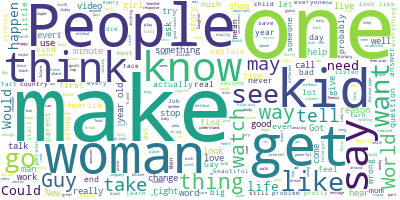

In [69]:
text_as_string = just_text.tostring()

type(text_as_string)

#text_as_string.decode("utf-8")

from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

my_stopwords = english_stopwords.append('PRON')

wordcloud = WordCloud(background_color="white", stopwords=english_stopwords, max_words=5000, contour_width=3, contour_color='steelblue')

my_cloud = wordcloud.generate(just_text_continuous)

wordcloud_image = wordcloud.to_image()

wordcloud_image

In [73]:
from gensim.models import Phrases
bigram = Phrases(just_text, min_count=10) #only if bigram occurs at least 10 times 

#how many bigrams have we extracted?
bigram.corpus_word_count

1052493

In [103]:
corpus = [
'Great course. Love the professor.',
'Great content. Textbook was great',
'This course has very hard assignments. Great content.',
'Love the professor.',
'Hard assignments though',
'Hard to understand.'
]
df = pd.DataFrame(corpus)
df.columns = ['reviews']
df

,reviews
0,Great course. Love the professor.
1,Great content. Textbook was great
2,This course has very hard assignments. Great c...
3,Love the professor.
4,Hard assignments though
5,Hard to understand.


In [106]:
df = pd.DataFrame(unique_headlines['lemmatized'])
df

,lemmatized
0,-PRON- be be call ' Walmart 's Worst Nightmare...
1,this be what sexism against men sound like
2,Kim Jong Un Would really hate for -PRON- to wa...
3,what -PRON- learn from the scientist be terrif...
4,a Bunch of Celebrities record a song to raise ...
...,...
12351,"a Pen , Paper , and watercolor tell one of the..."
12352,newsflash : Black People travel too . here be ...
12353,5 reason -PRON- May need to plan a Vacation - ...
12354,the next time -PRON- encounter a small Minded ...


In [132]:
df

,lemmatized
0,-PRON- be be call ' Walmart 's Worst Nightmare...
1,this be what sexism against men sound like
2,Kim Jong Un Would really hate for -PRON- to wa...
3,what -PRON- learn from the scientist be terrif...
4,a Bunch of Celebrities record a song to raise ...
...,...
12351,"a Pen , Paper , and watercolor tell one of the..."
12352,newsflash : Black People travel too . here be ...
12353,5 reason -PRON- May need to plan a Vacation - ...
12354,the next time -PRON- encounter a small Minded ...


In [138]:
df[df['lemmatized'].str.contains('zuckerberg')]

,lemmatized


In [158]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words=['pron'], ngram_range=(2,3), max_features = 1000)
# matrix of ngrams
ngrams = cv.fit_transform(df['lemmatized'])

# count frequency of ngrams
#count_values = ngrams.toarray().sum(axis=0)
# list of ngrams

new_df = pd.DataFrame(ngrams.toarray(), columns = cv.get_feature_names())
new_df

,10 year,100 year,15 year,16 year,30 second,50 year,able to,about be,about how,about race,...,world leader,would be,would have,would not,wrong with,year ago,year old,year old girl,young girl,young woman
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:

# needs to happen after fit_transform()
vocab = cv.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# output n-grams
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    print(ng_count, ng_text)

834 do not
656 be not
569 here be
480 in the
430 of the
399 want to
390 be the
361 that be
320 to be
311 the world
288 what be
259 there be
234 this be
228 can not
218 the most
218 and be
217 have to
214 talk about
212 to the
205 on the
205 go to
201 year old
195 try to
186 need to
181 how to
178 to make
177 but be
176 about the
174 to do
173 be so
171 if be
166 be what
163 this guy
159 one of
151 for the
149 why be
145 what happen
142 out of
142 be go
141 to get
136 be just
135 have ever
134 way to
132 what do
132 look like
132 be in
131 the good
127 lot of
125 have be
123 will not
123 who be
122 kind of
121 all the
119 look at
113 people be
113 be do
112 may be
111 to know
108 be why
108 at the
106 not have
104 not be
103 to say
103 one of the
101 be how
100 be like
97 watch this
97 be go to
95 to see
95 like this
94 the way
94 and the
93 this video
92 know about
92 be be
89 happen when
88 bunch of
87 with the
86 when be
86 think be
84 the first
84 that will
84 of people
84 listen to

In [ ]:
#new_df.sort_values('sum')

amazing how many generic nouns there are! kid, thing, woman, happen, girl, guy etc. 
also the verbs are incredibly generic! want, watch, like, know,s ee, say, get, go  
could I get at this by looking at the overall frequency in the English language?  
does clickbait employ more high-frequency nouns? 

In [67]:
# compute average word frequency?

from wordfreq import zipf_frequency

zipf_frequency('schaden', 'en', wordlist='small')

0.0

# get word freqs

In [4]:
upworthy_preprocessed_for_topic_model_numbered

,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr..."
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,..."
...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu..."
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu..."
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu..."
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o..."


In [23]:
def get_mean_freq(lemmatized):
    freqs = [zipf_frequency(word, 'en') for word in lemmatized]
    return sum(freqs) / len(freqs)

In [26]:
headline = upworthy_preprocessed_for_topic_model_numbered['preprocessed_headline'].iloc[1]
freqs = get_mean_freq(headline)
freqs

4.980666666666666

In [27]:
upworthy_preprocessed_for_topic_model_numbered['avg_word_freq'] = upworthy_preprocessed_for_topic_model_numbered['preprocessed_headline'].apply(get_mean_freq)
upworthy_preprocessed_for_topic_model_numbered

,number,clickability_test_id,headline,lede,lemmatized_headline,lemmatized_lede,preprocessed_headline,preprocessed_lede,avg_word_freq
0,0,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",4.980667
1,1,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",4.980667
2,2,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",-PRON- be be call ' Walmart 's Worst Nightmare...,< p > when -PRON- see * why * people be call -...,"[pron, be, be, call, walmart, s, worst, nightm...","[p, when, pron, see, why, people, be, call, pr...",4.980667
3,3,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",5.782500
4,4,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this be what sexism against men sound like,< p > disclosure : -PRON- be a dude . -PRON- h...,"[this, be, what, sexism, against, men, sound, ...","[p, disclosure, pron, be, a, dude, pron, have,...",5.782500
...,...,...,...,...,...,...,...,...,...
22661,150749,546d373426714cde76000018,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5 reason -PRON- May need to plan a Vacation - ...,< p > Travel be not just a luxury or indulgenc...,"[5, reason, pron, may, need, to, plan, a, vaca...","[p, travel, be, not, just, a, luxury, or, indu...",5.624545
22662,150755,546d373426714cde76000018,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the next time -PRON- encounter a small Minded ...,< p > Travel be not just a luxury or indulgenc...,"[the, next, time, pron, encounter, a, small, m...","[p, travel, be, not, just, a, luxury, or, indu...",5.285333
22663,150756,546d373426714cde76000018,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,-PRON- have never want to buy a plane ticket M...,< p > Travel be not just a luxury or indulgenc...,"[pron, have, never, want, to, buy, a, plane, t...","[p, travel, be, not, just, a, luxury, or, indu...",5.200500
22664,150813,54b6a21662646300182c0000,3 Ladies Having Too Much Fun At The Epicenter ...,<p>The Frackettes want to remind you of one im...,3 lady have too much Fun at the Epicenter of a...,< p > the Frackettes want to remind -PRON- of ...,"[3, lady, have, too, much, fun, at, the, epice...","[p, the, frackettes, want, to, remind, pron, o...",5.941667


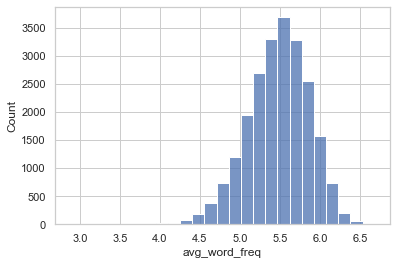

In [37]:
import seaborn as sns

sns.set_theme(style = 'whitegrid')

sns.histplot(x="avg_word_freq", bins = 25, data=upworthy_preprocessed_for_topic_model_numbered)


In [3]:
from wordfreq import zipf_frequency

zipf_frequency('the', 'en')

7.73